In [1]:
import sys
sys.path.append('../.')


from utils import *
from utils_plotting import *
from Data.DataGenerator import *
from Models.Models_normal import *
import torch.optim as optim
from Training.Analysis import fixed_model_batch_analysis
from Data.DataLoader import *
from Training.Spike_loss import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor


In [3]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
arch = (784, [256, 128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10])

model = MNIST_classifier(n_in=arch[0], layer_list=arch[1], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

state_dict = torch.load('/home/mila/m/mehrab.hamidi/scratch/training_res/january_res/mnist/normal/bias_0.0001/mnist_training/try_num3/epoch_50/model.pt', weights_only=False)
model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()



dataset_target_samples = train_samples
dataset_target_labels = train_labels

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


{'x': [-1102.3208, 1426.7286], 'y': [-1154.8231, 1168.7582]}
{'x': [-0.42421296, 694.6026], 'y': [-0.42421296, 697.8413]}
{'x': [-1102.3208, 1426.7286], 'y': [-1154.8231, 1168.7582], 'z': [-1562.7034, 1655.6218]}
{'x': [-0.42421296, 611.3702], 'y': [-0.42421296, 622.57104], 'z': [-0.42421296, 690.734]}


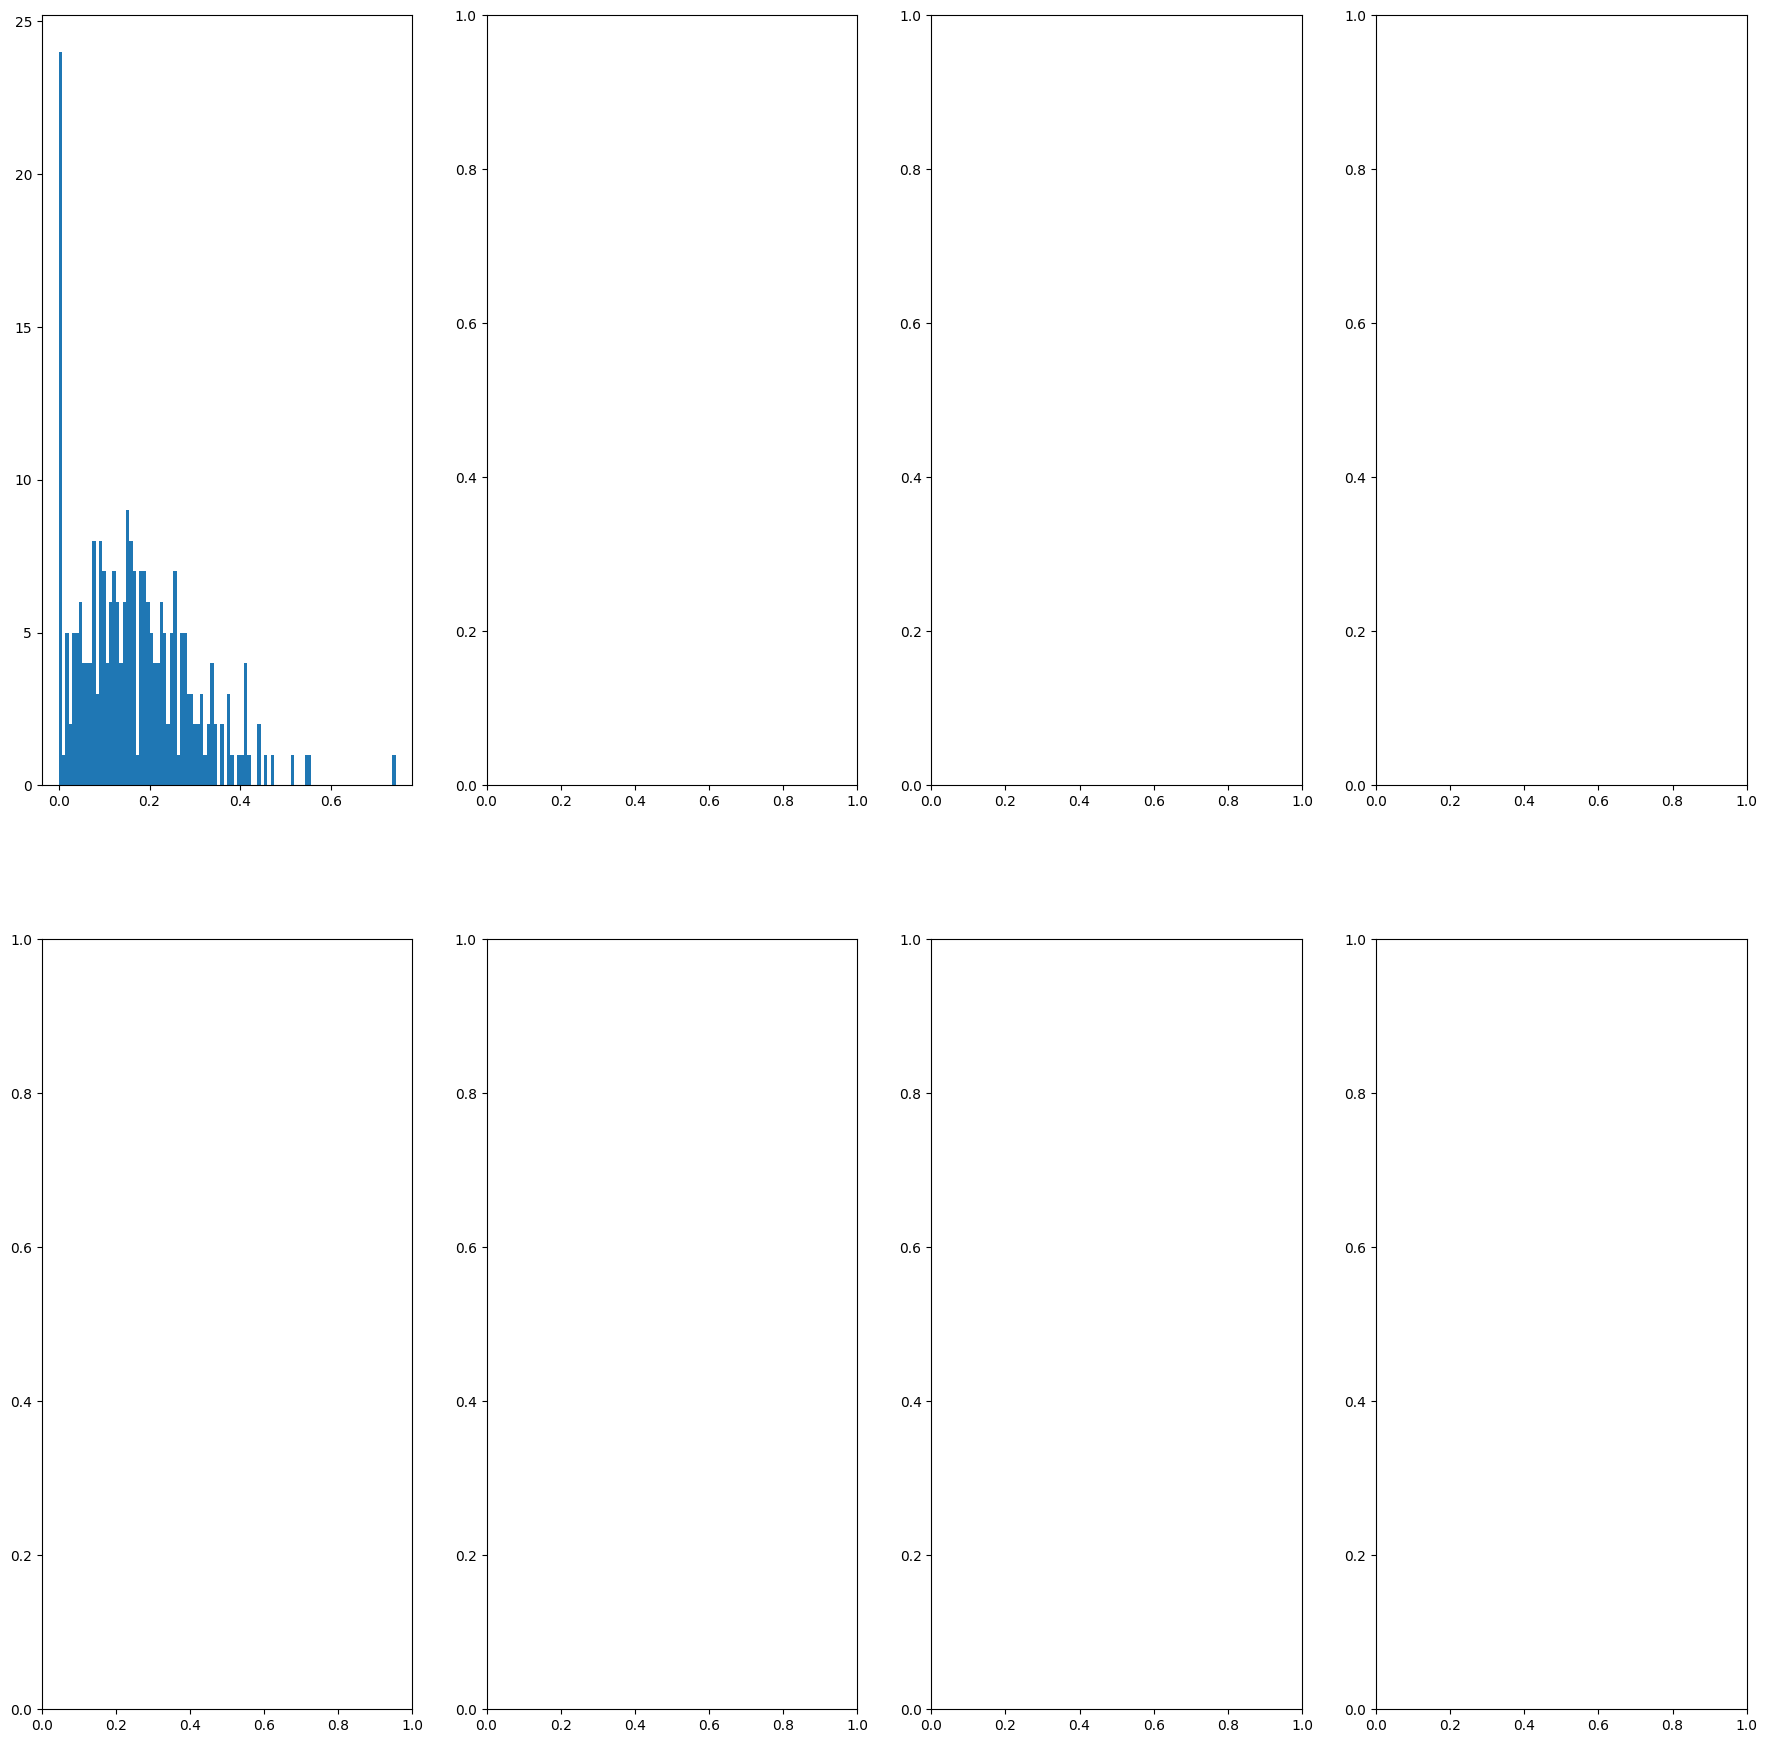

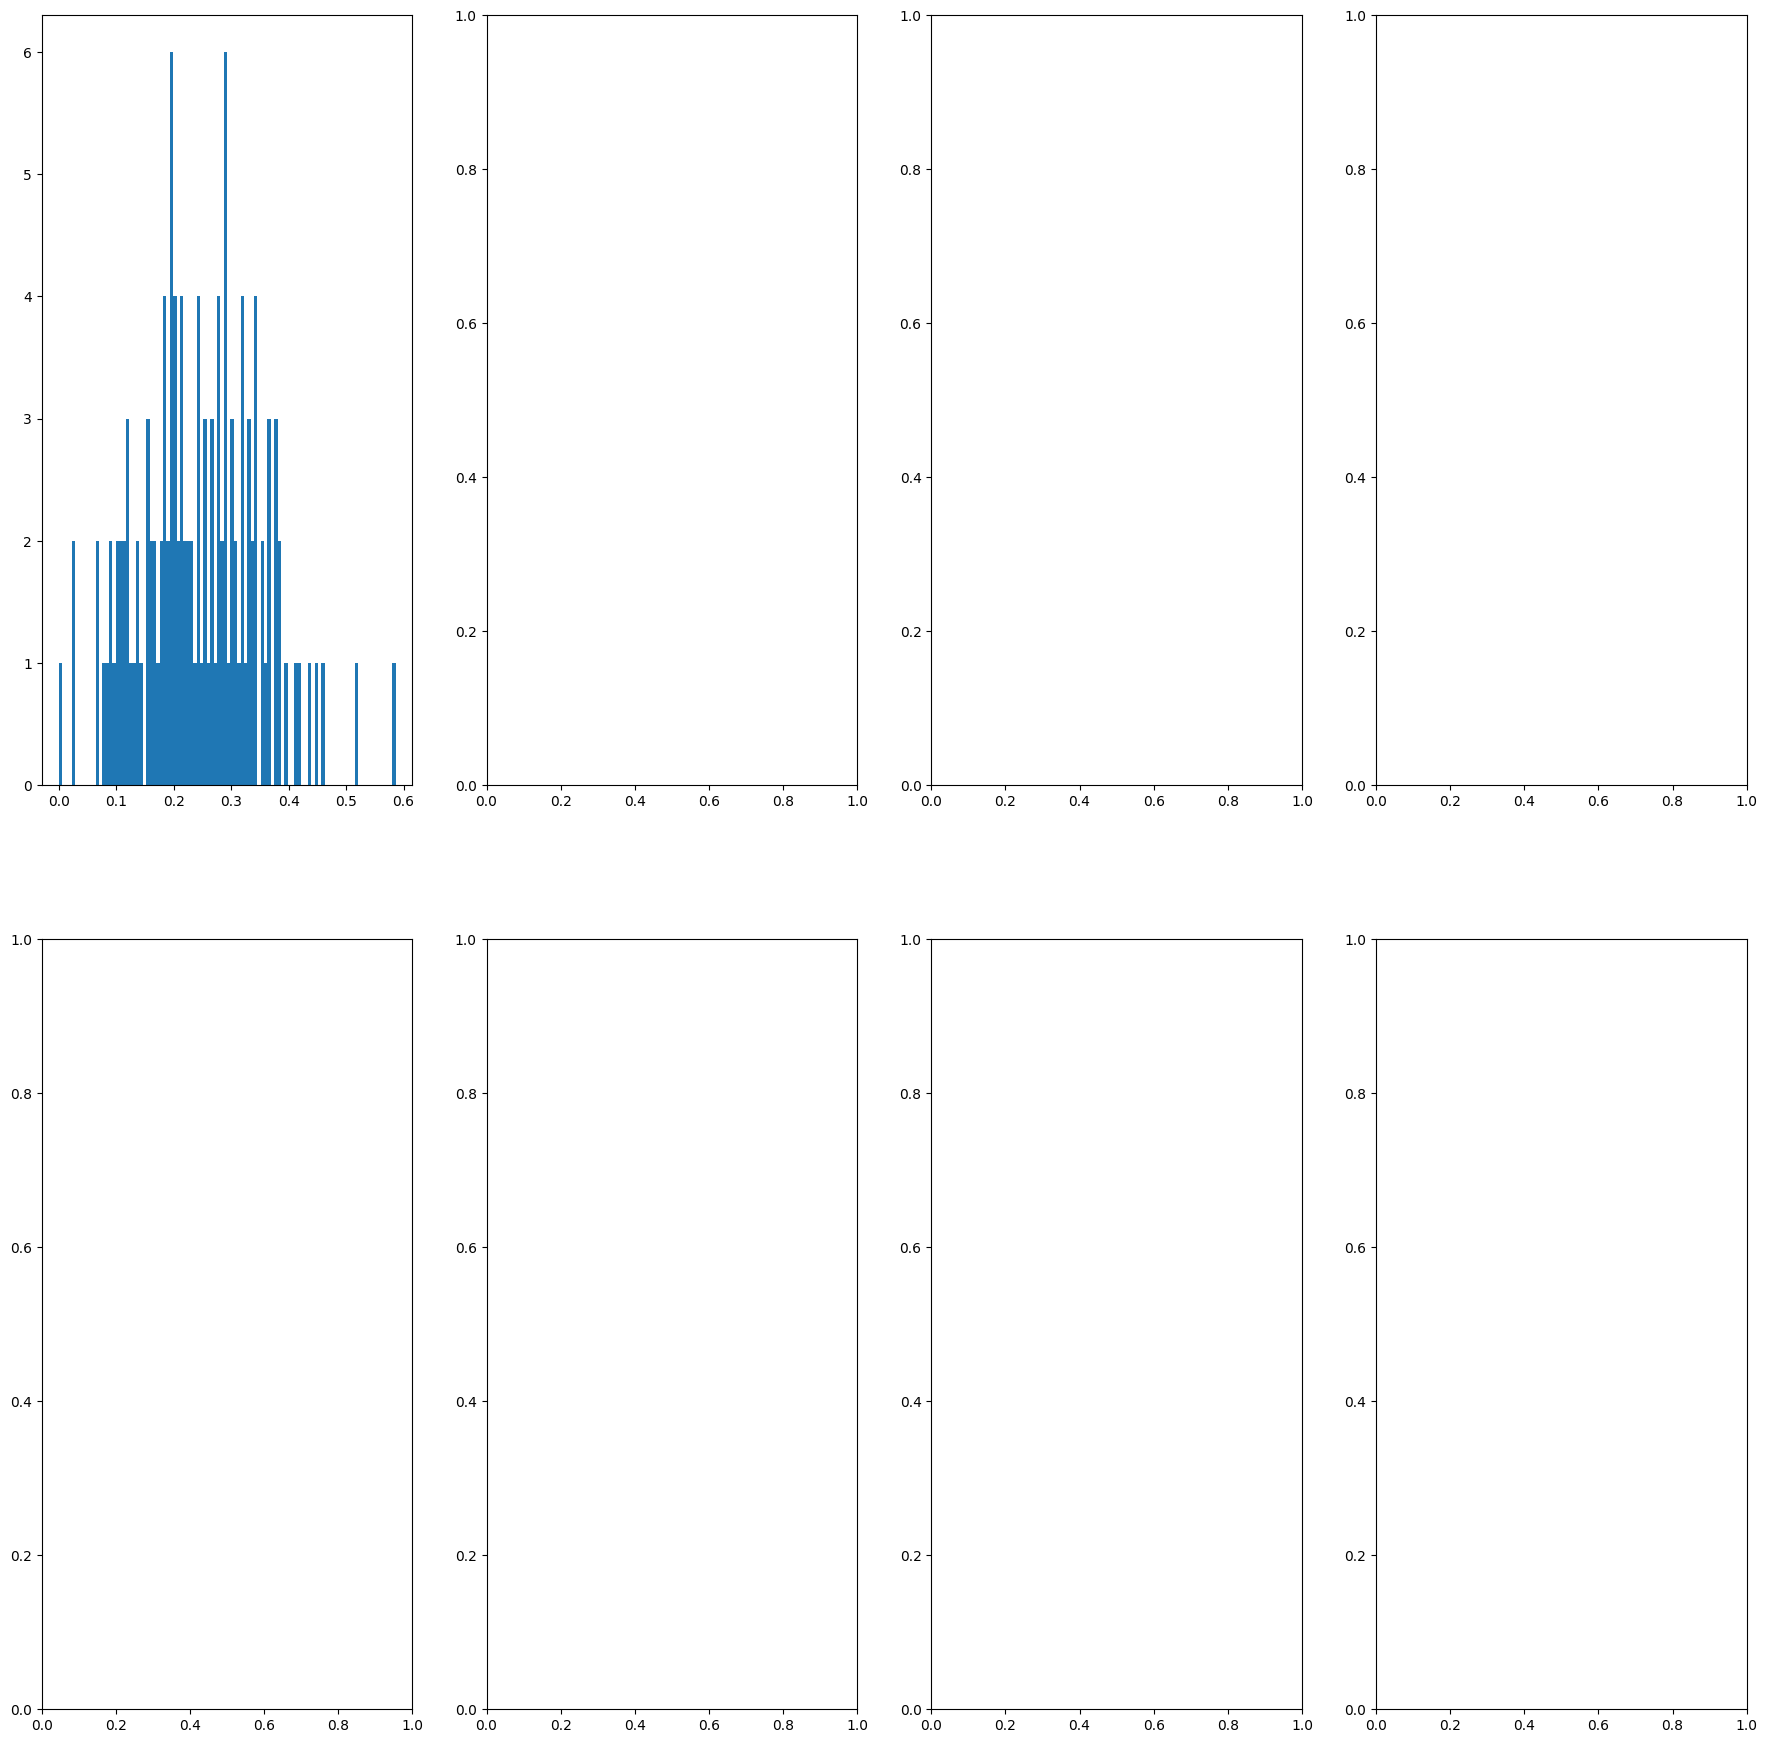

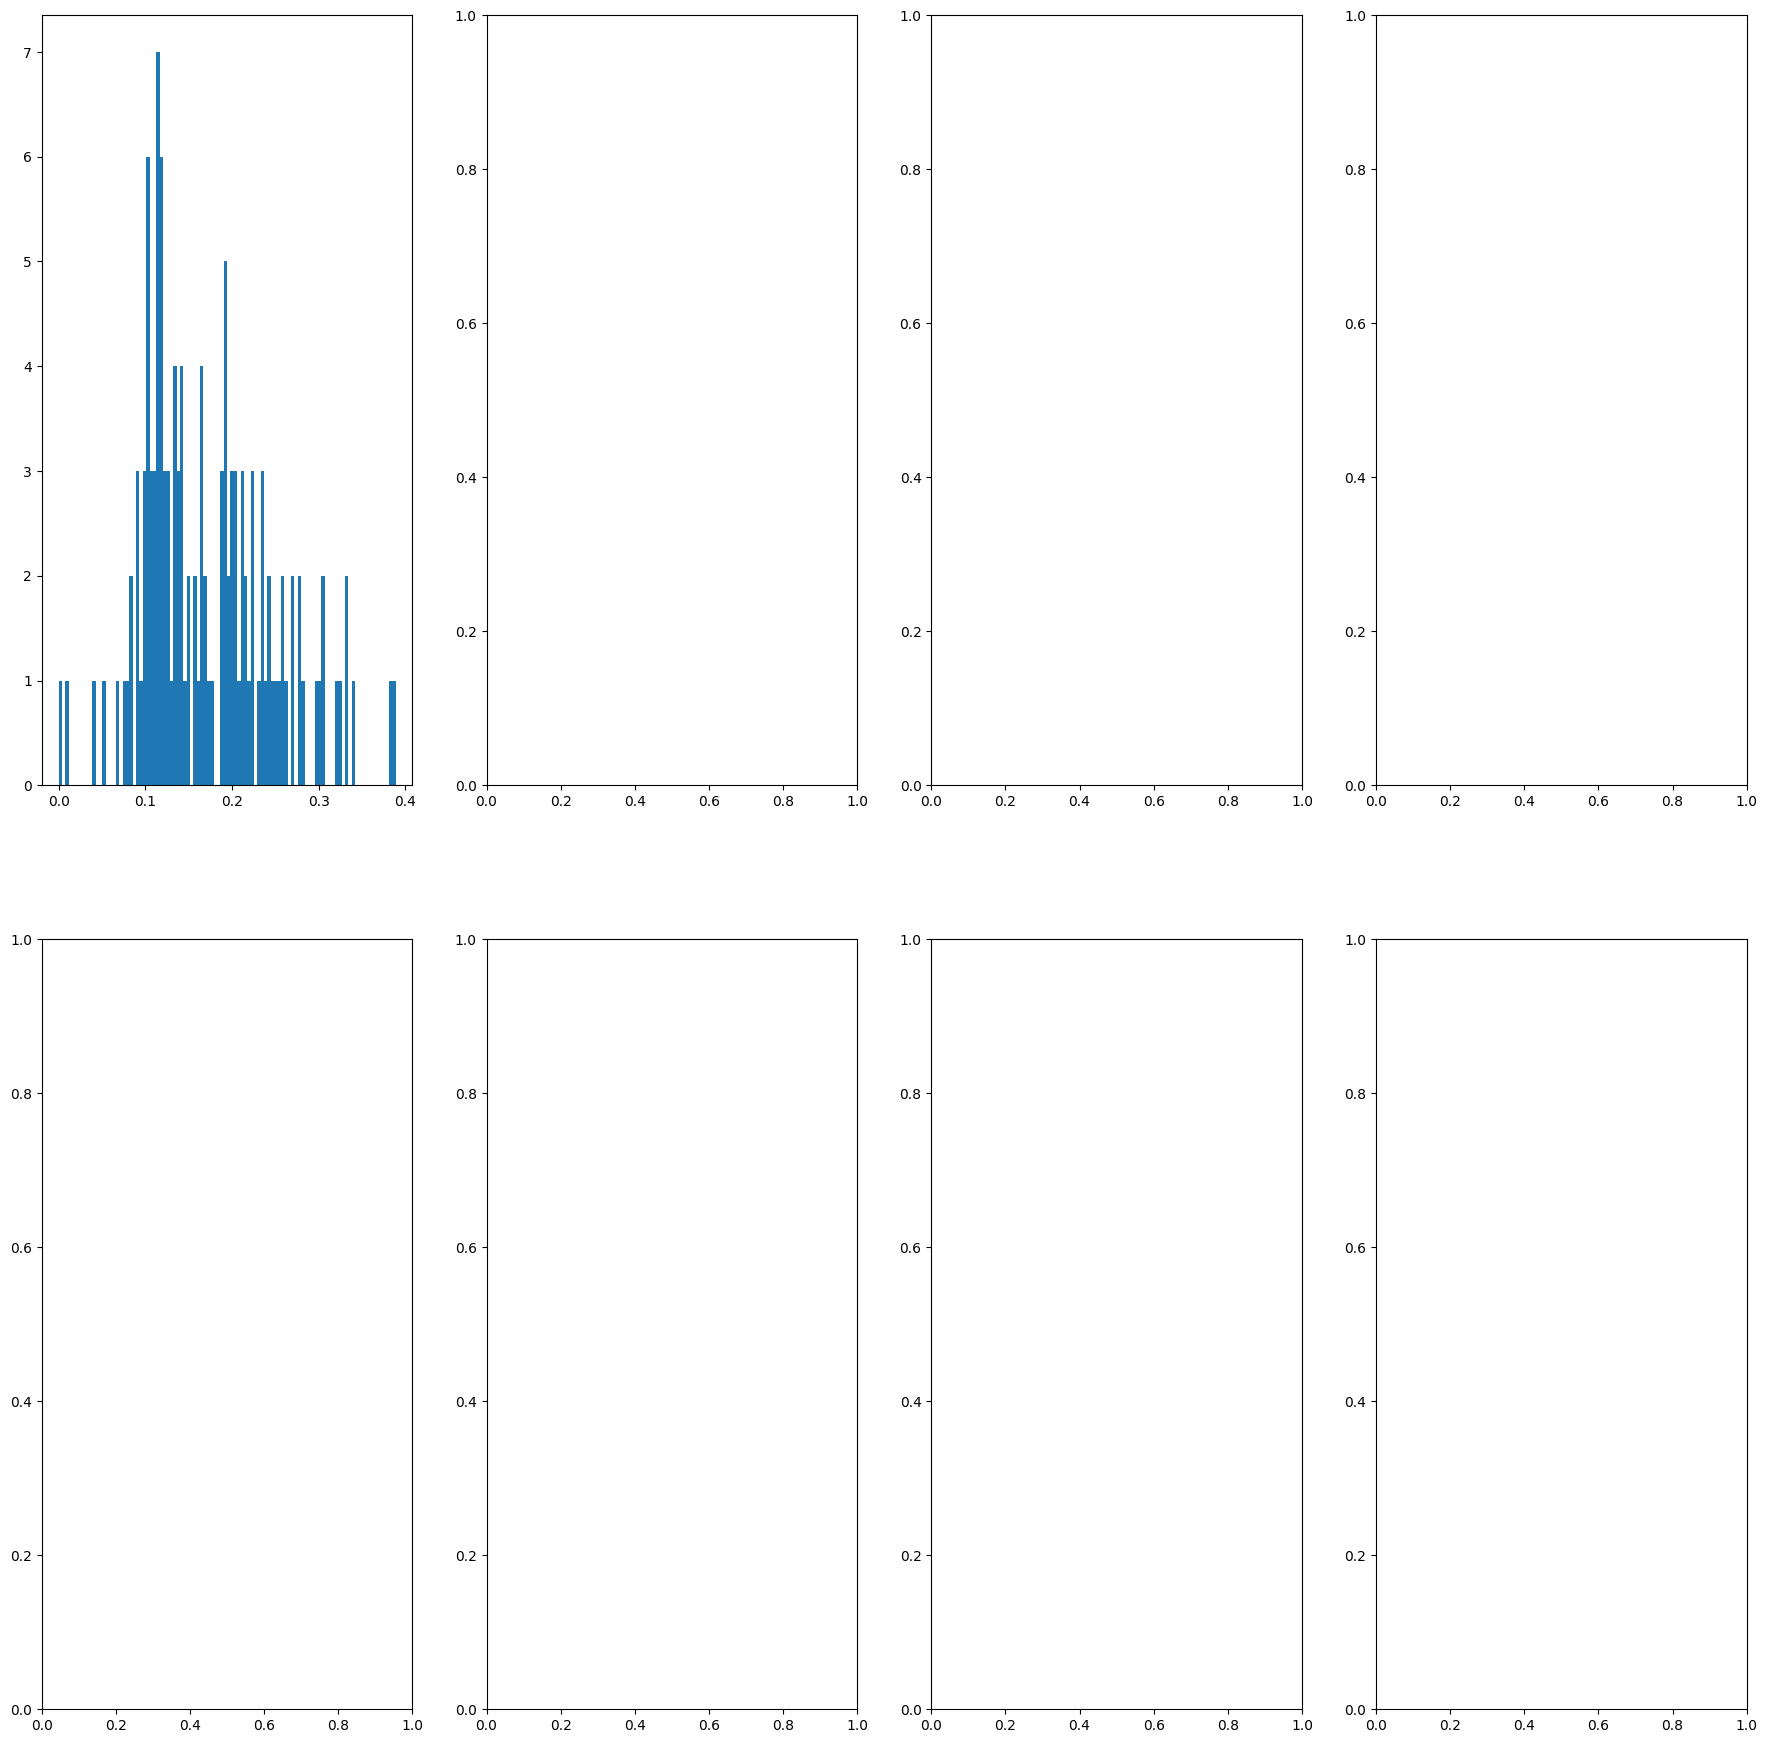

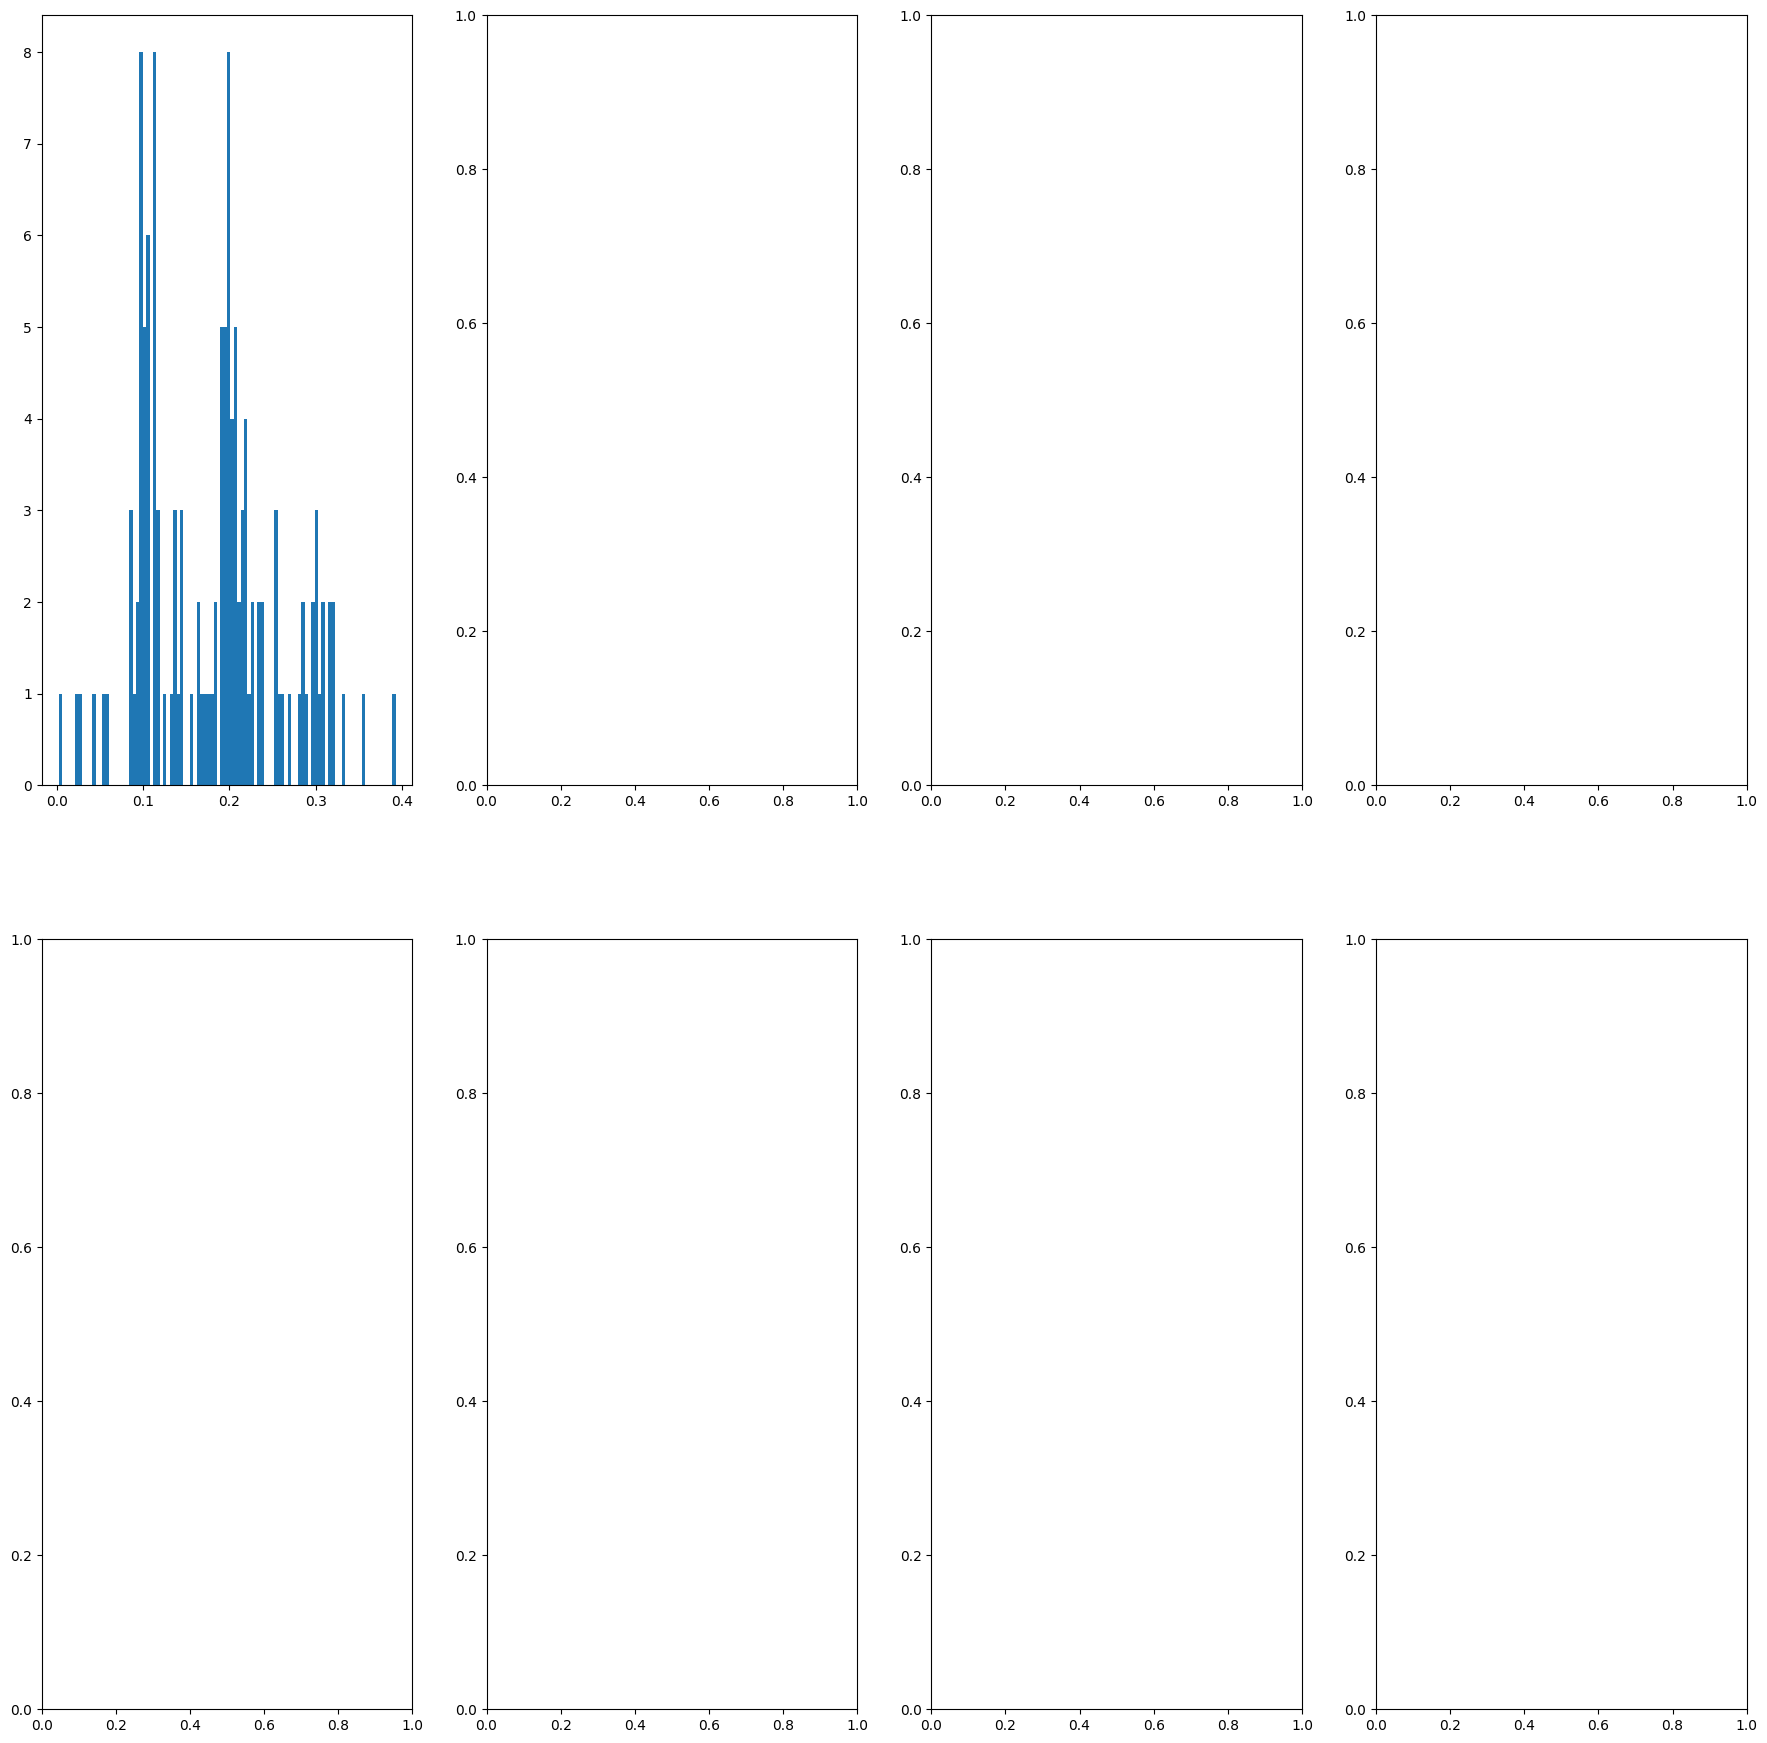

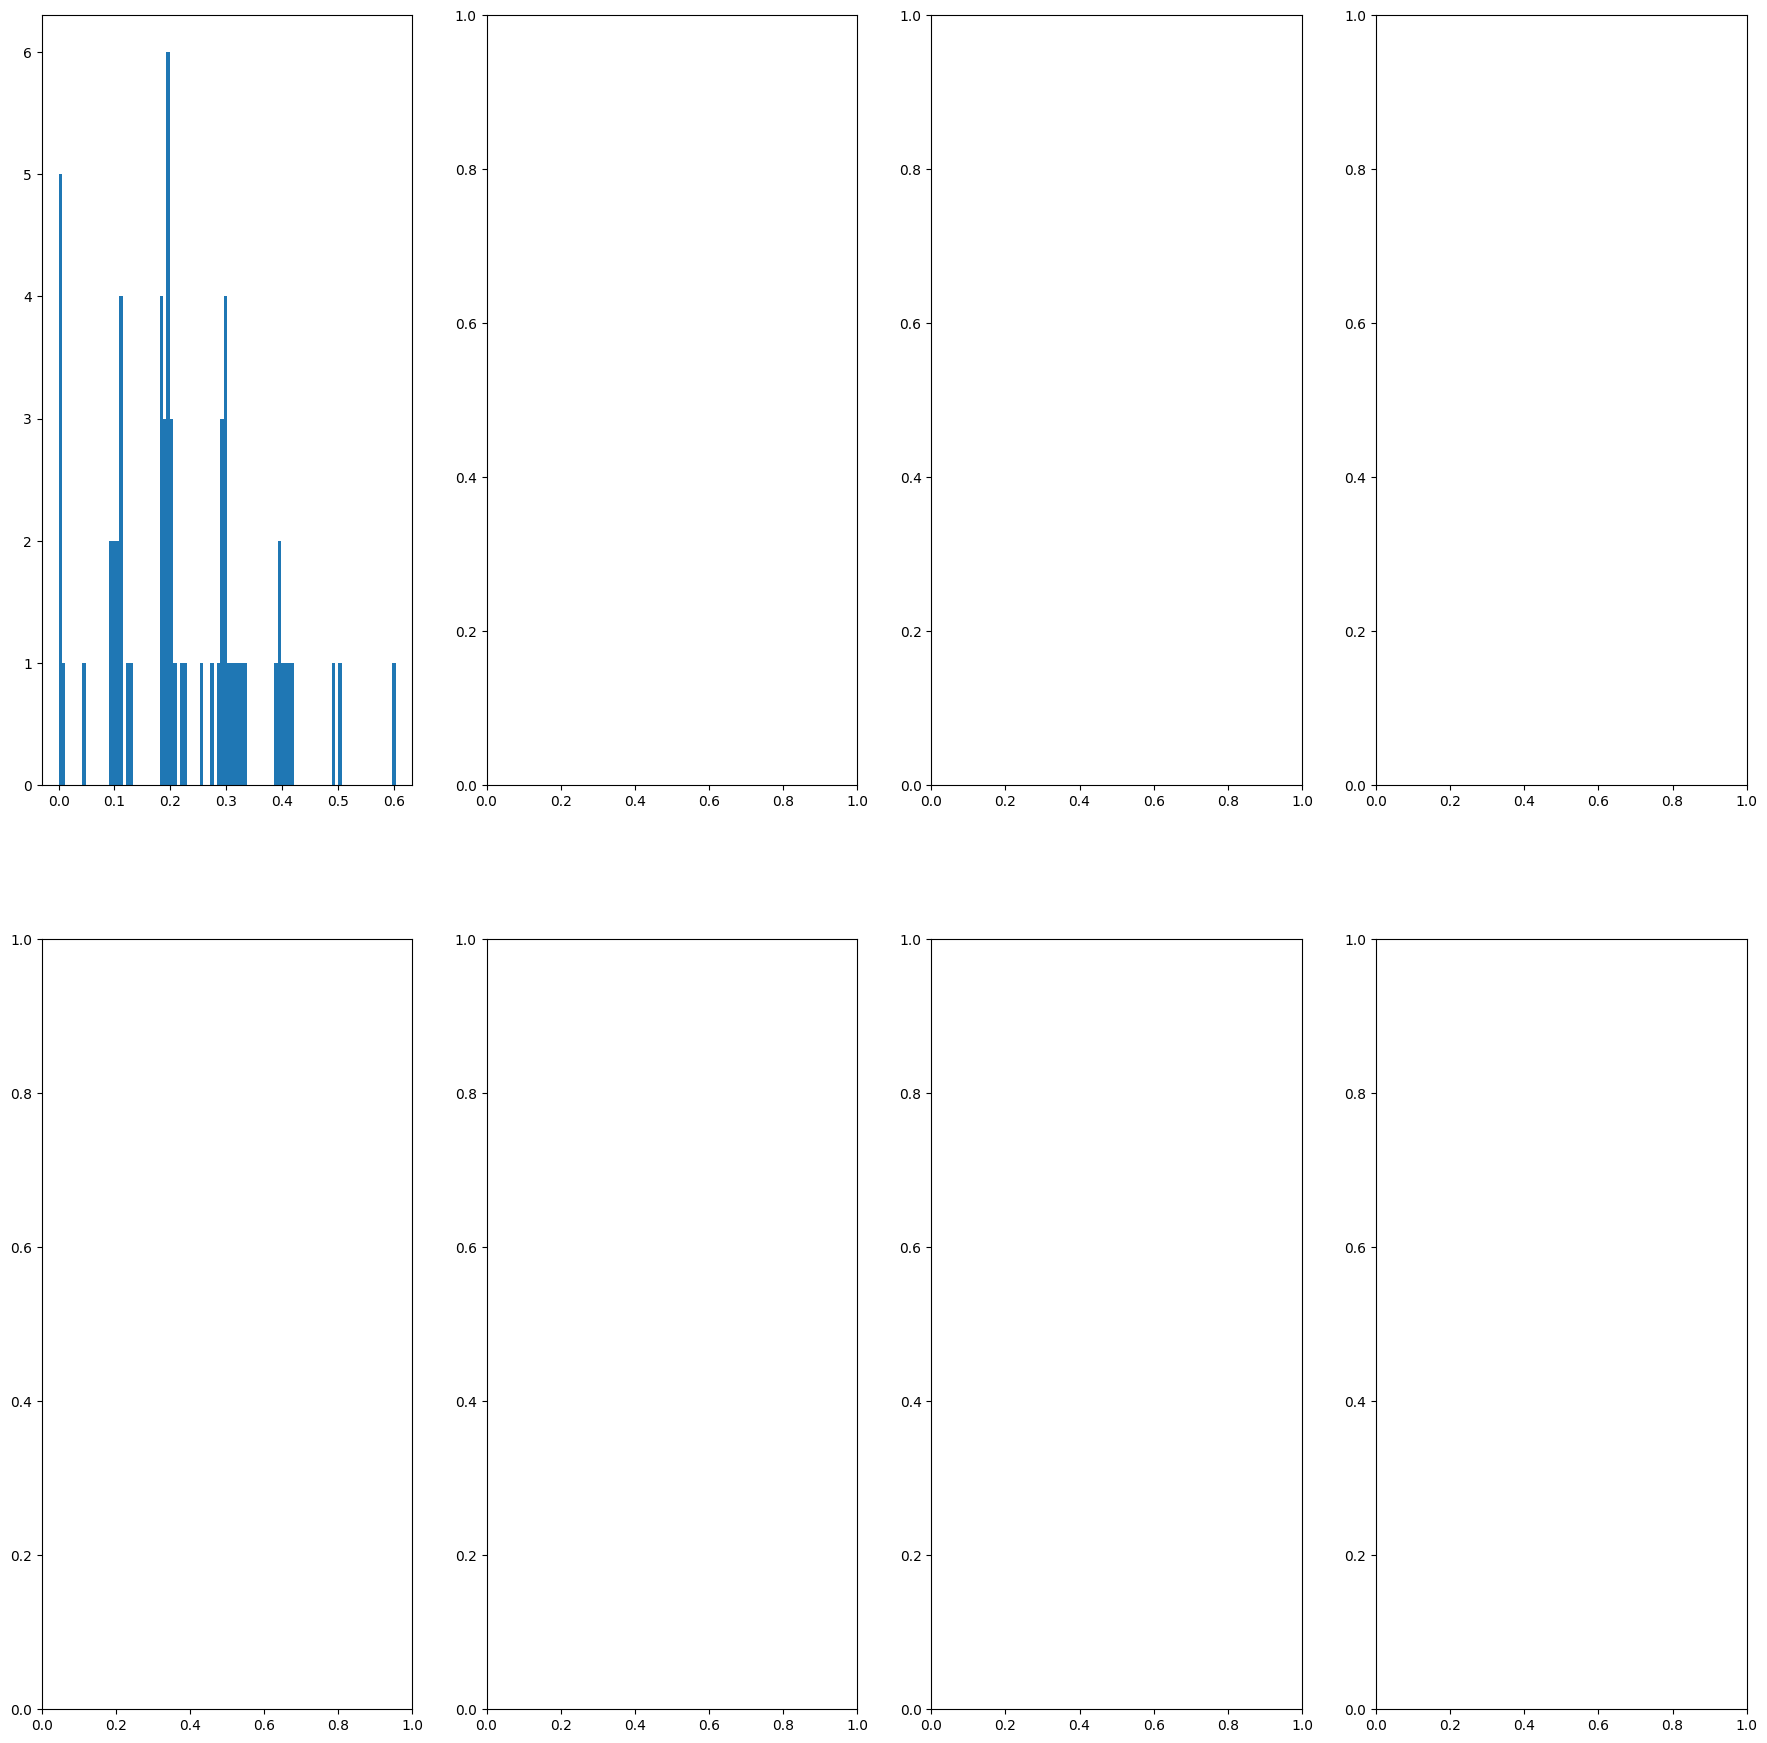

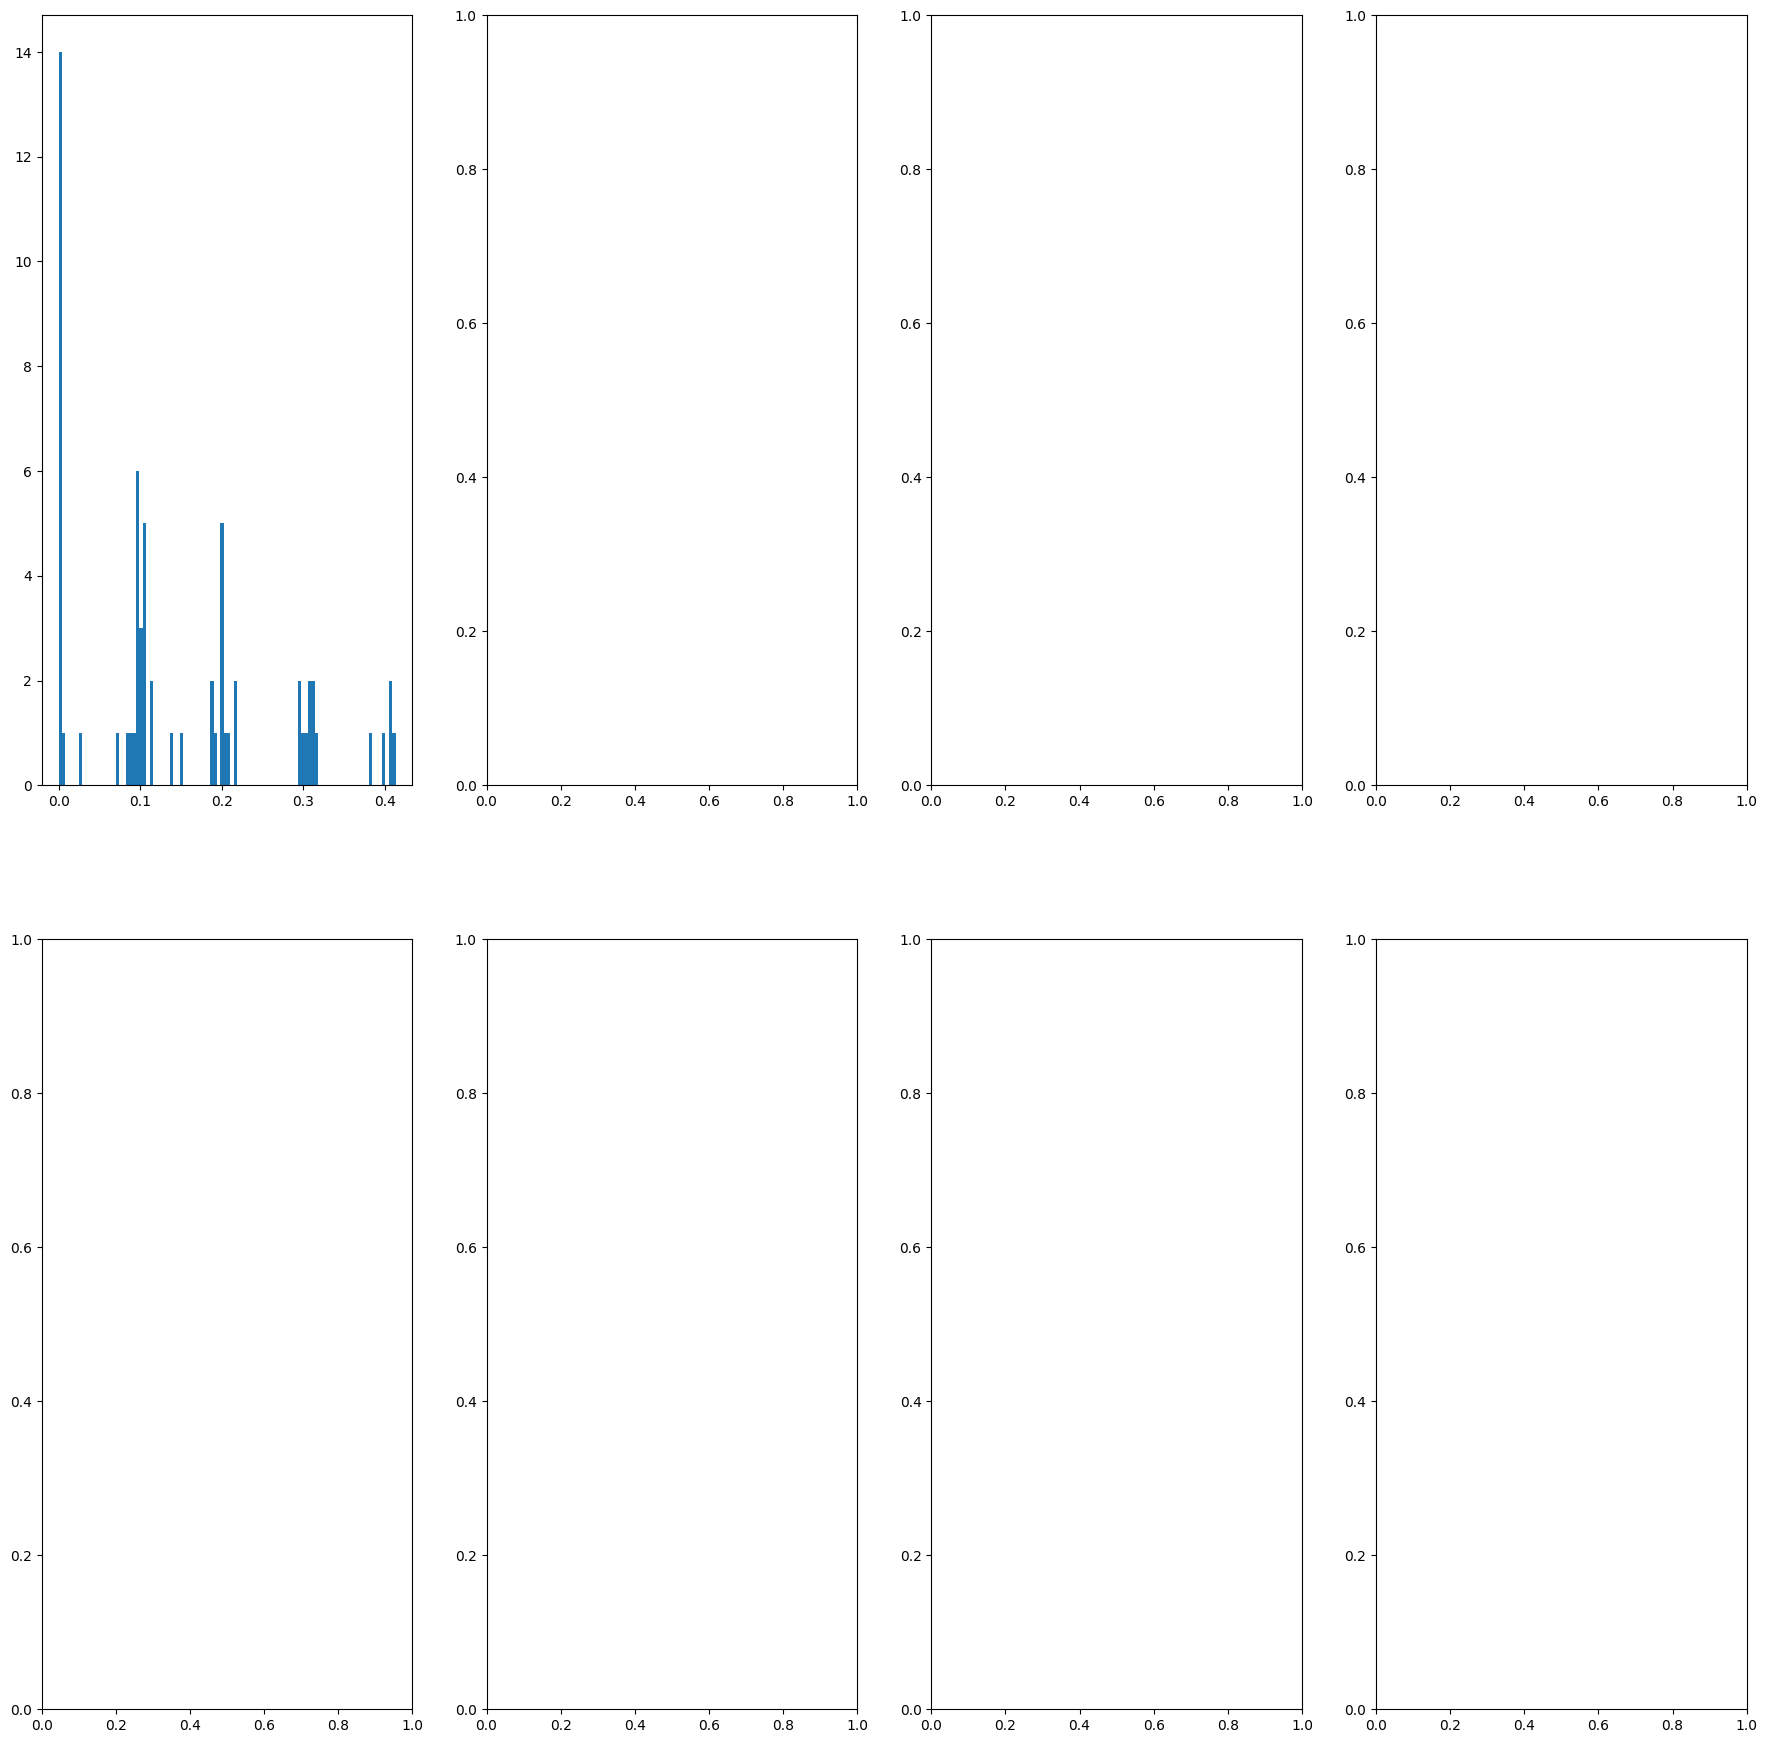

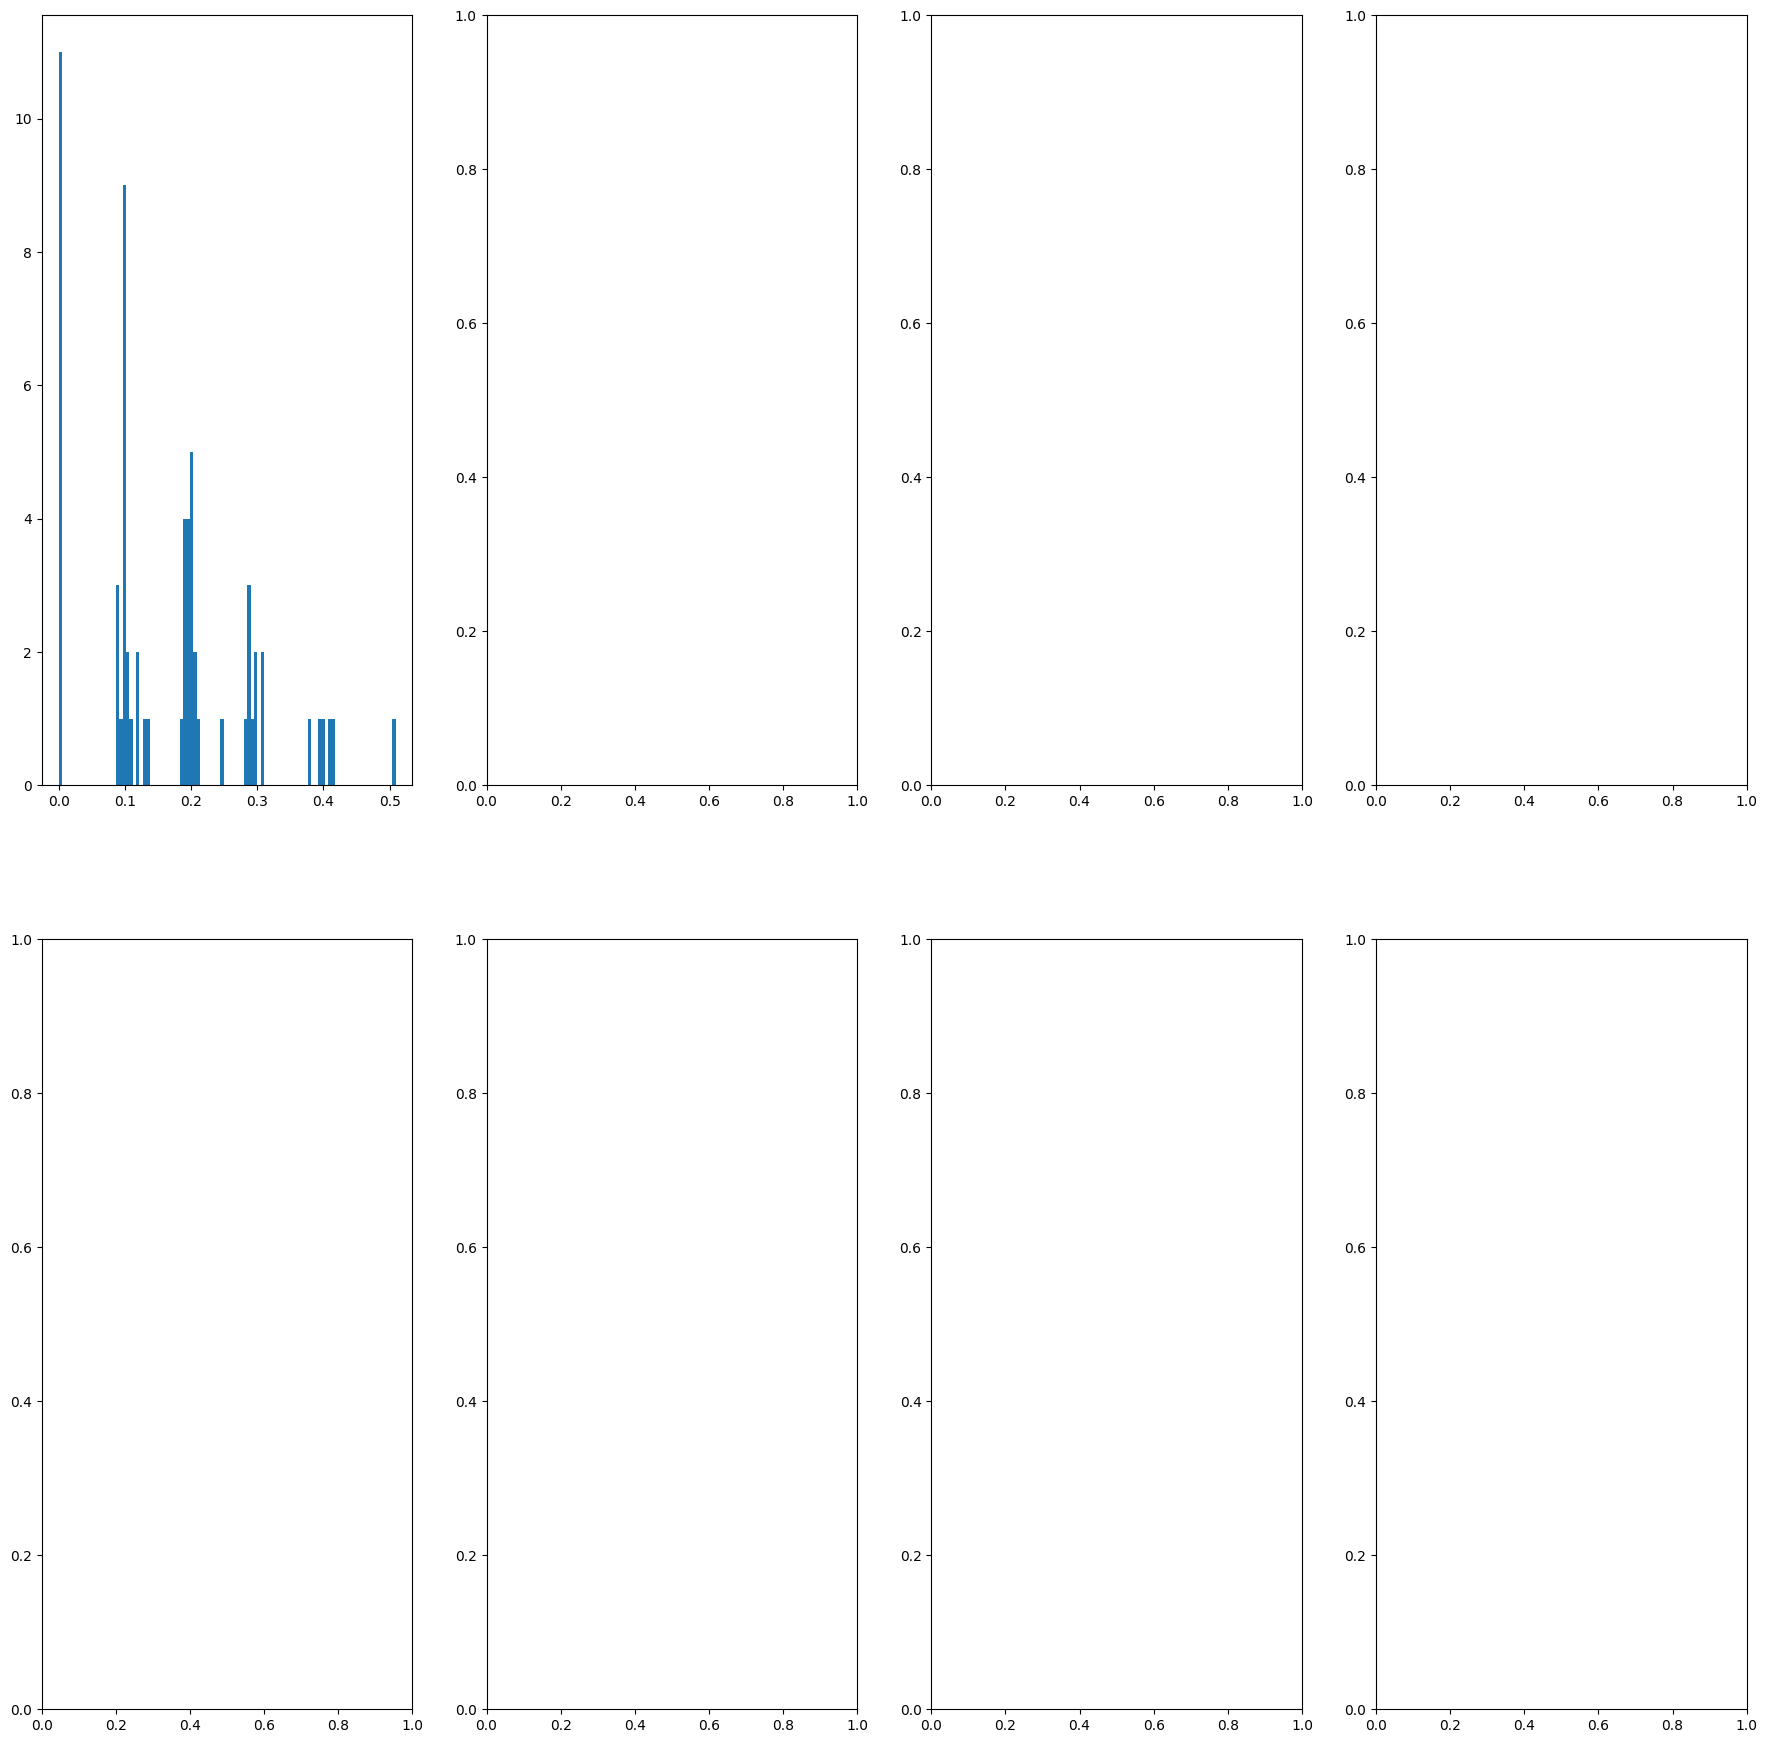

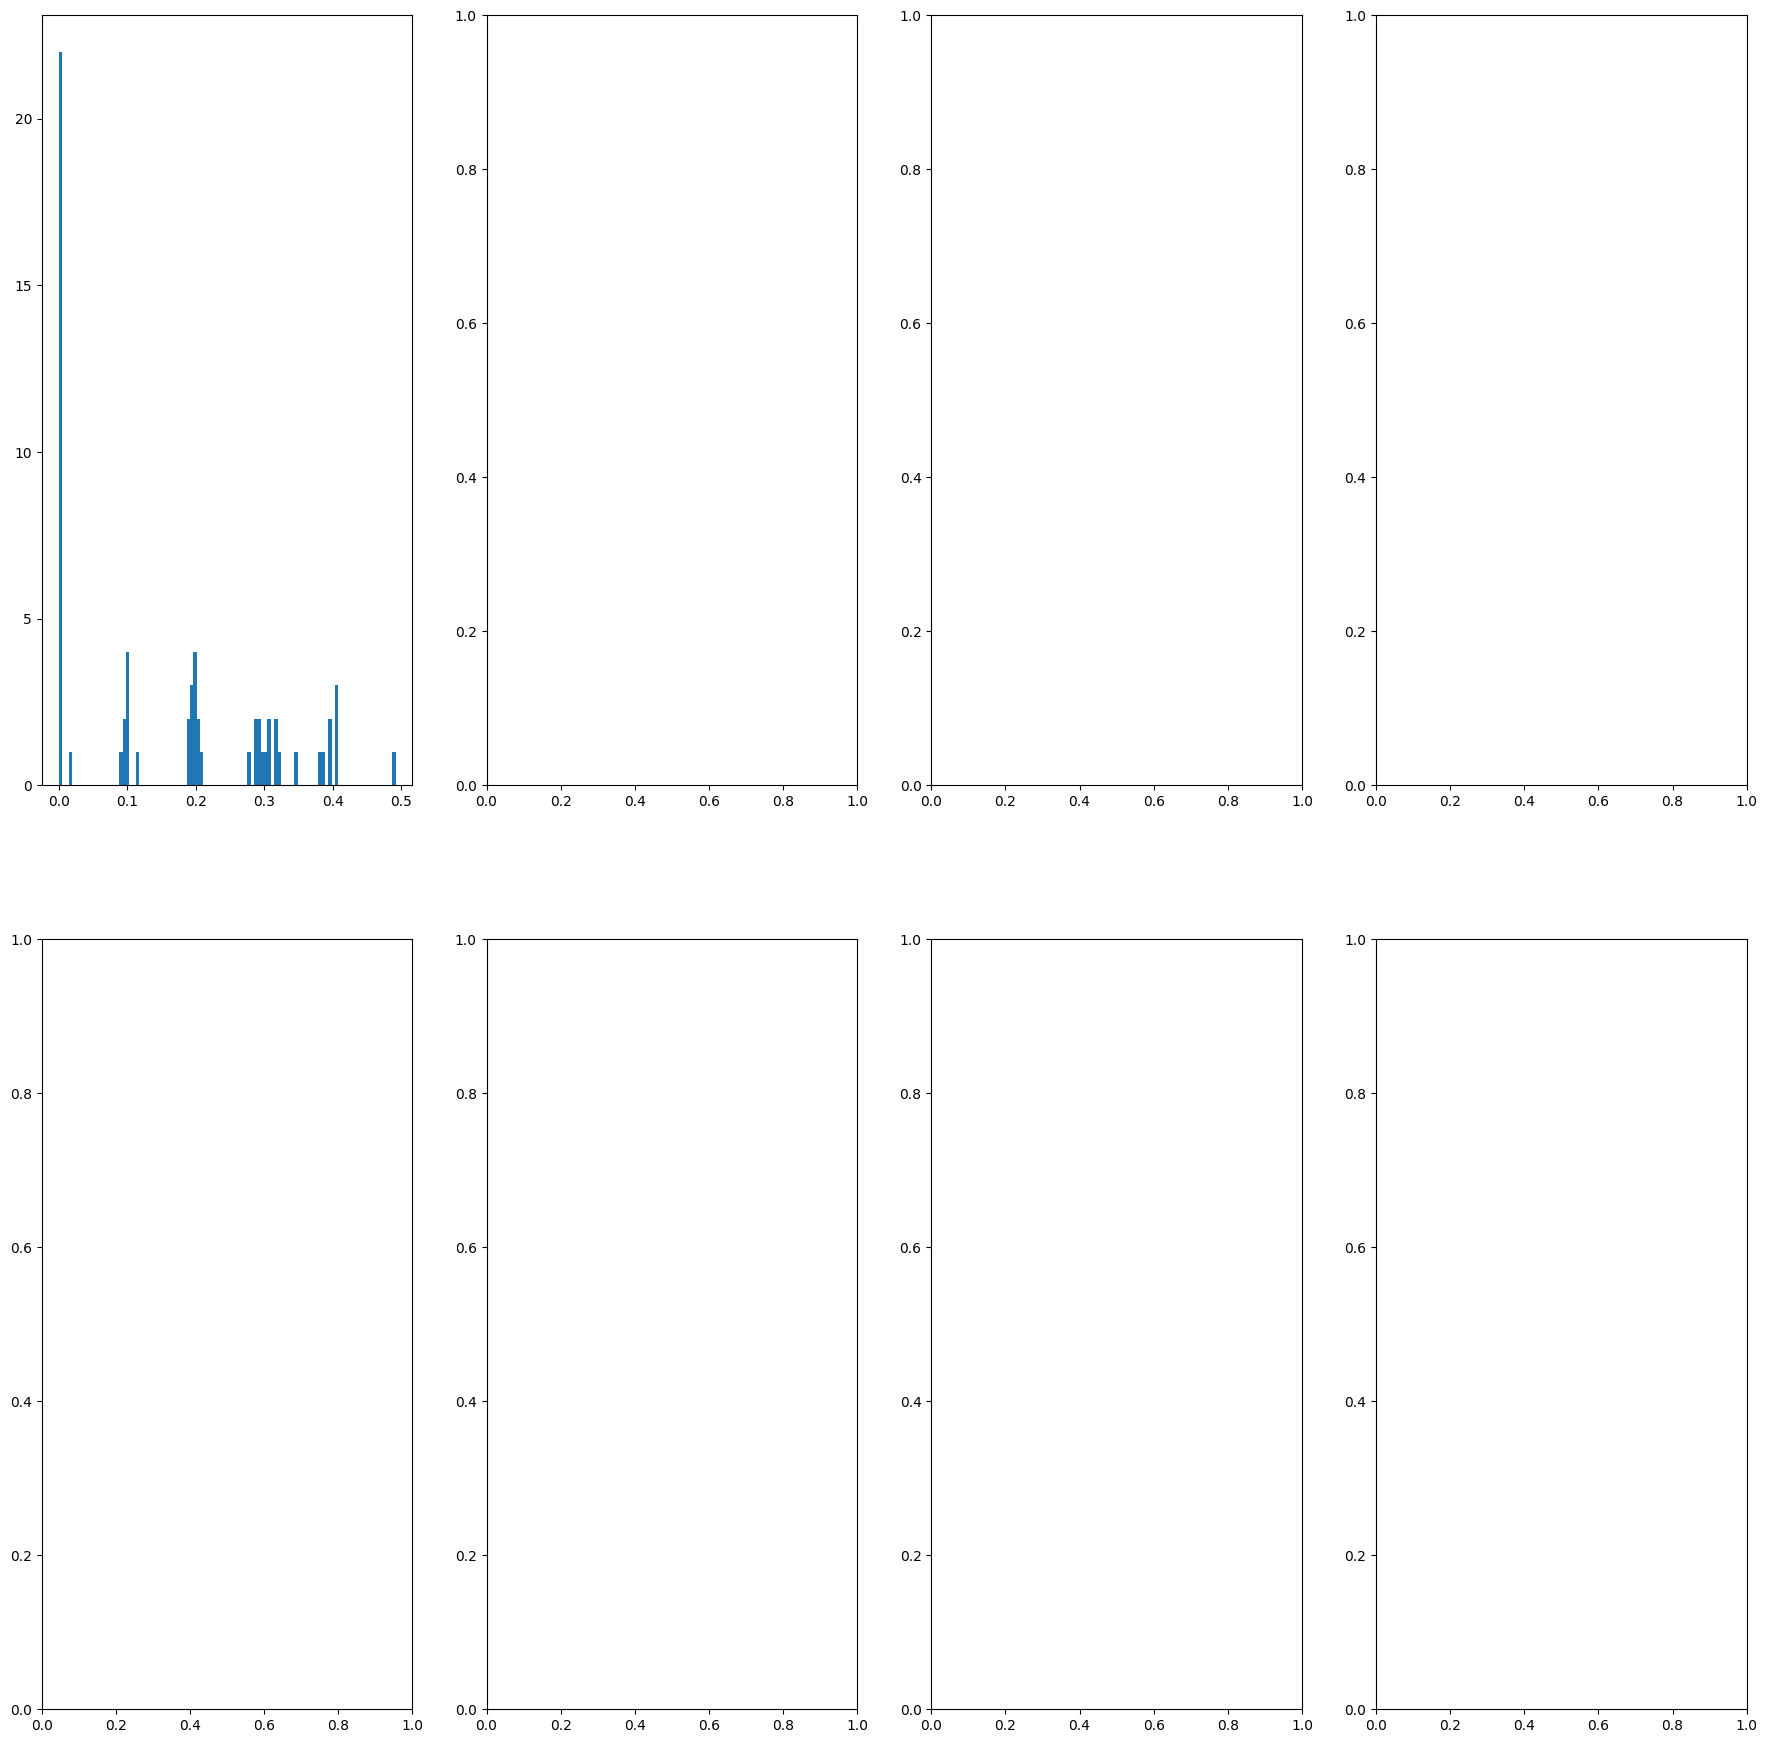

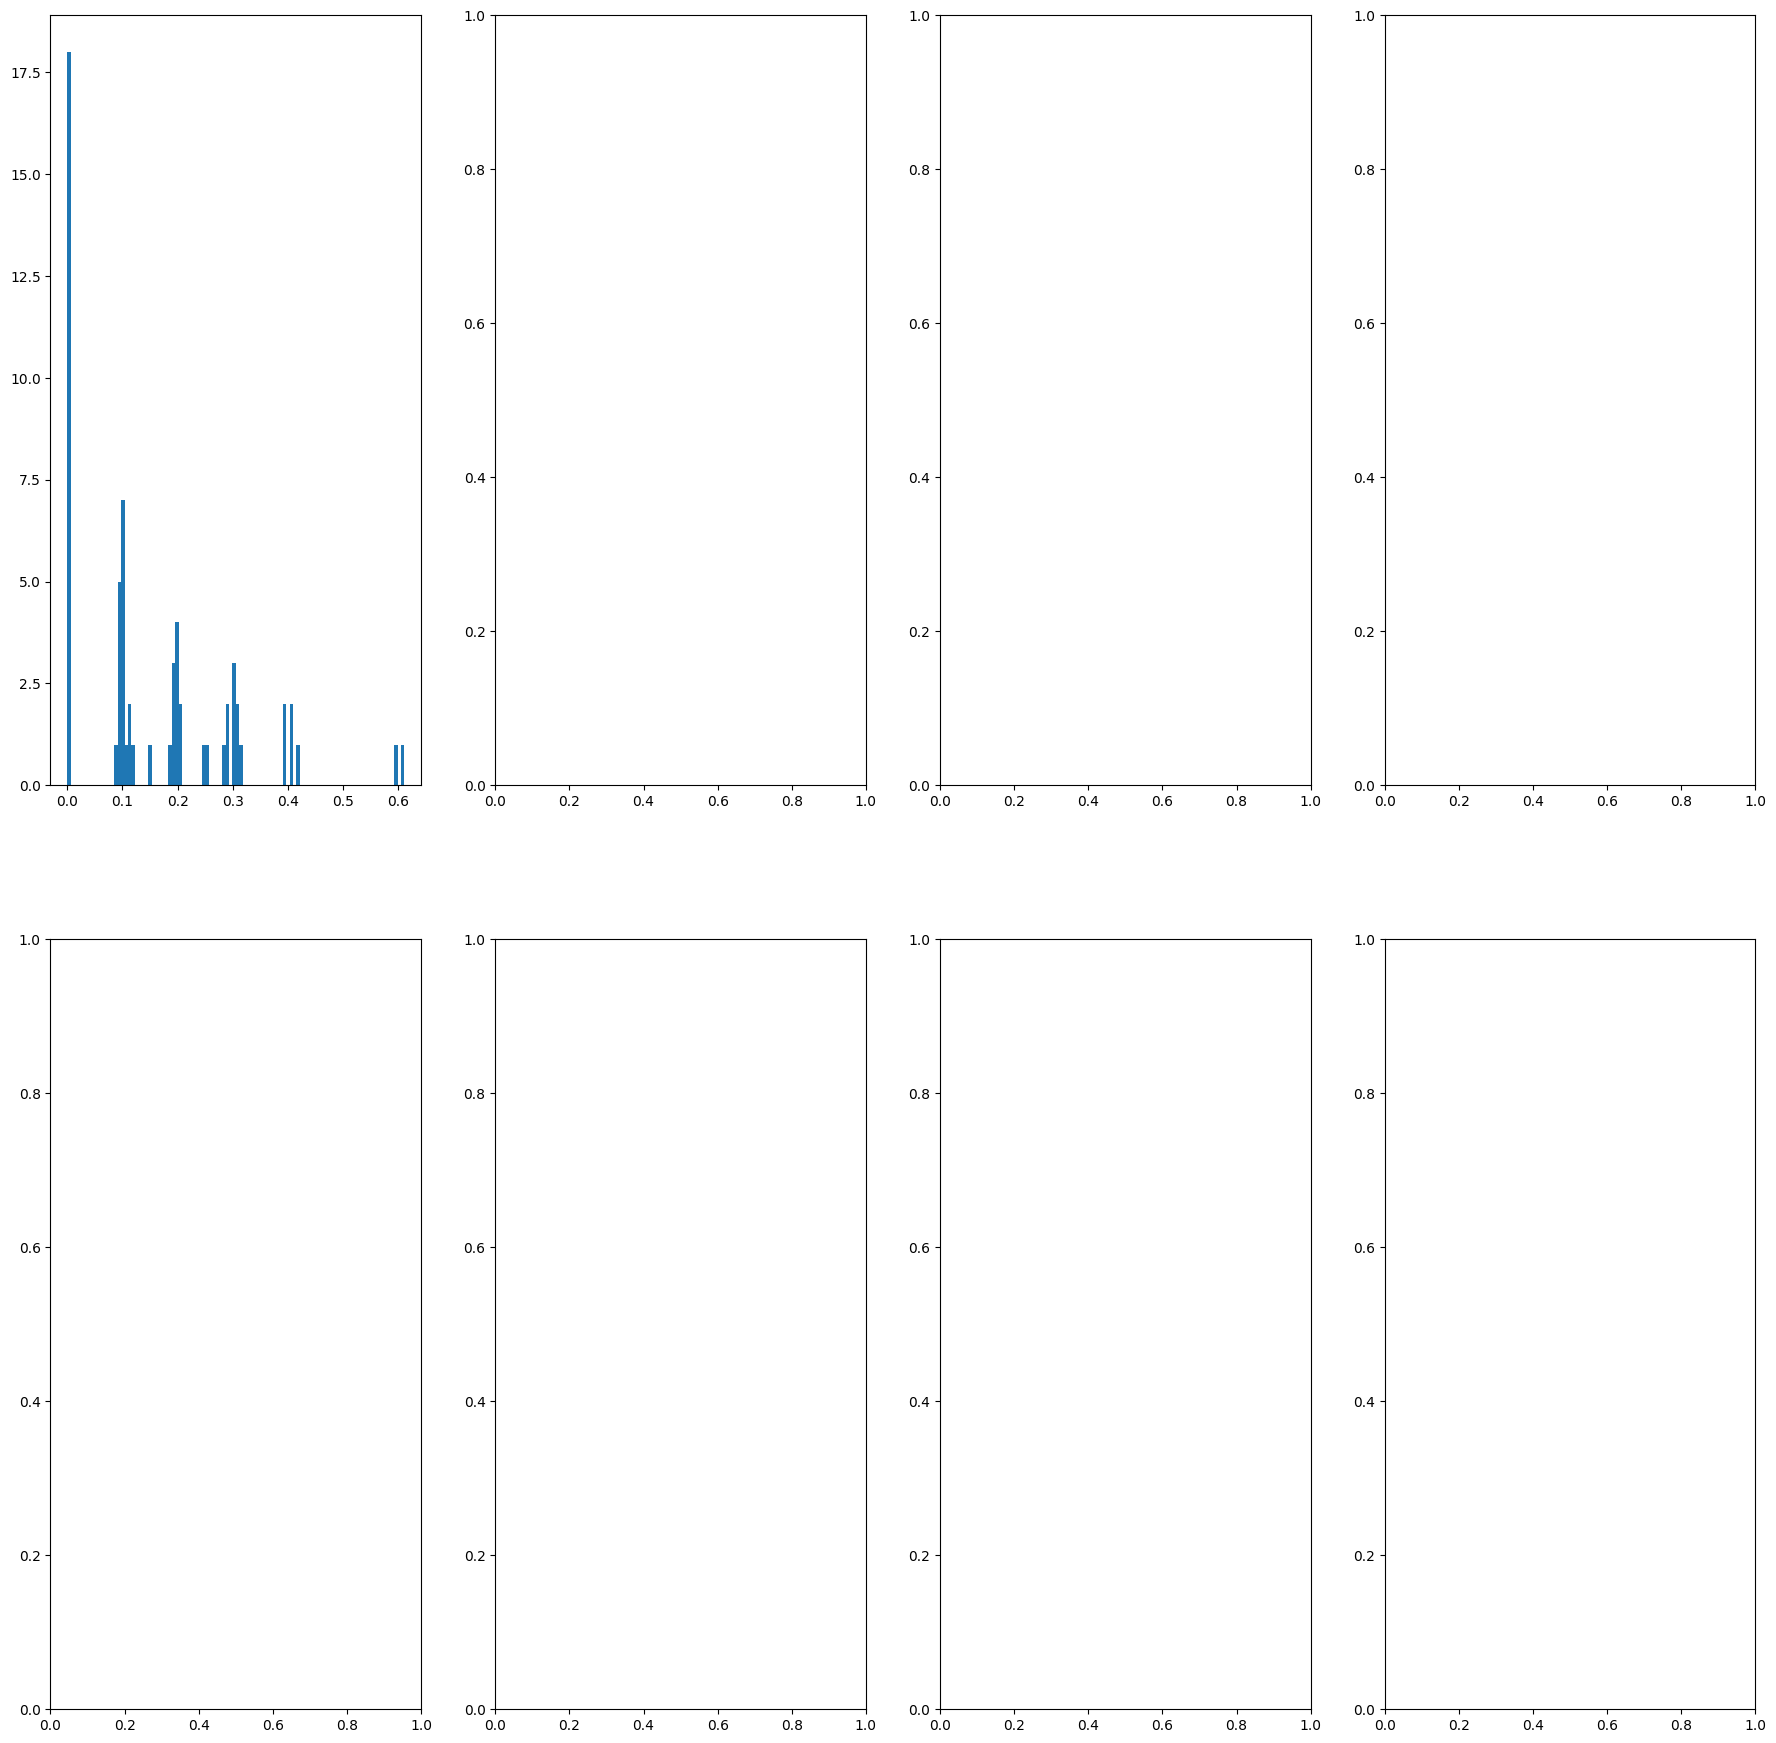

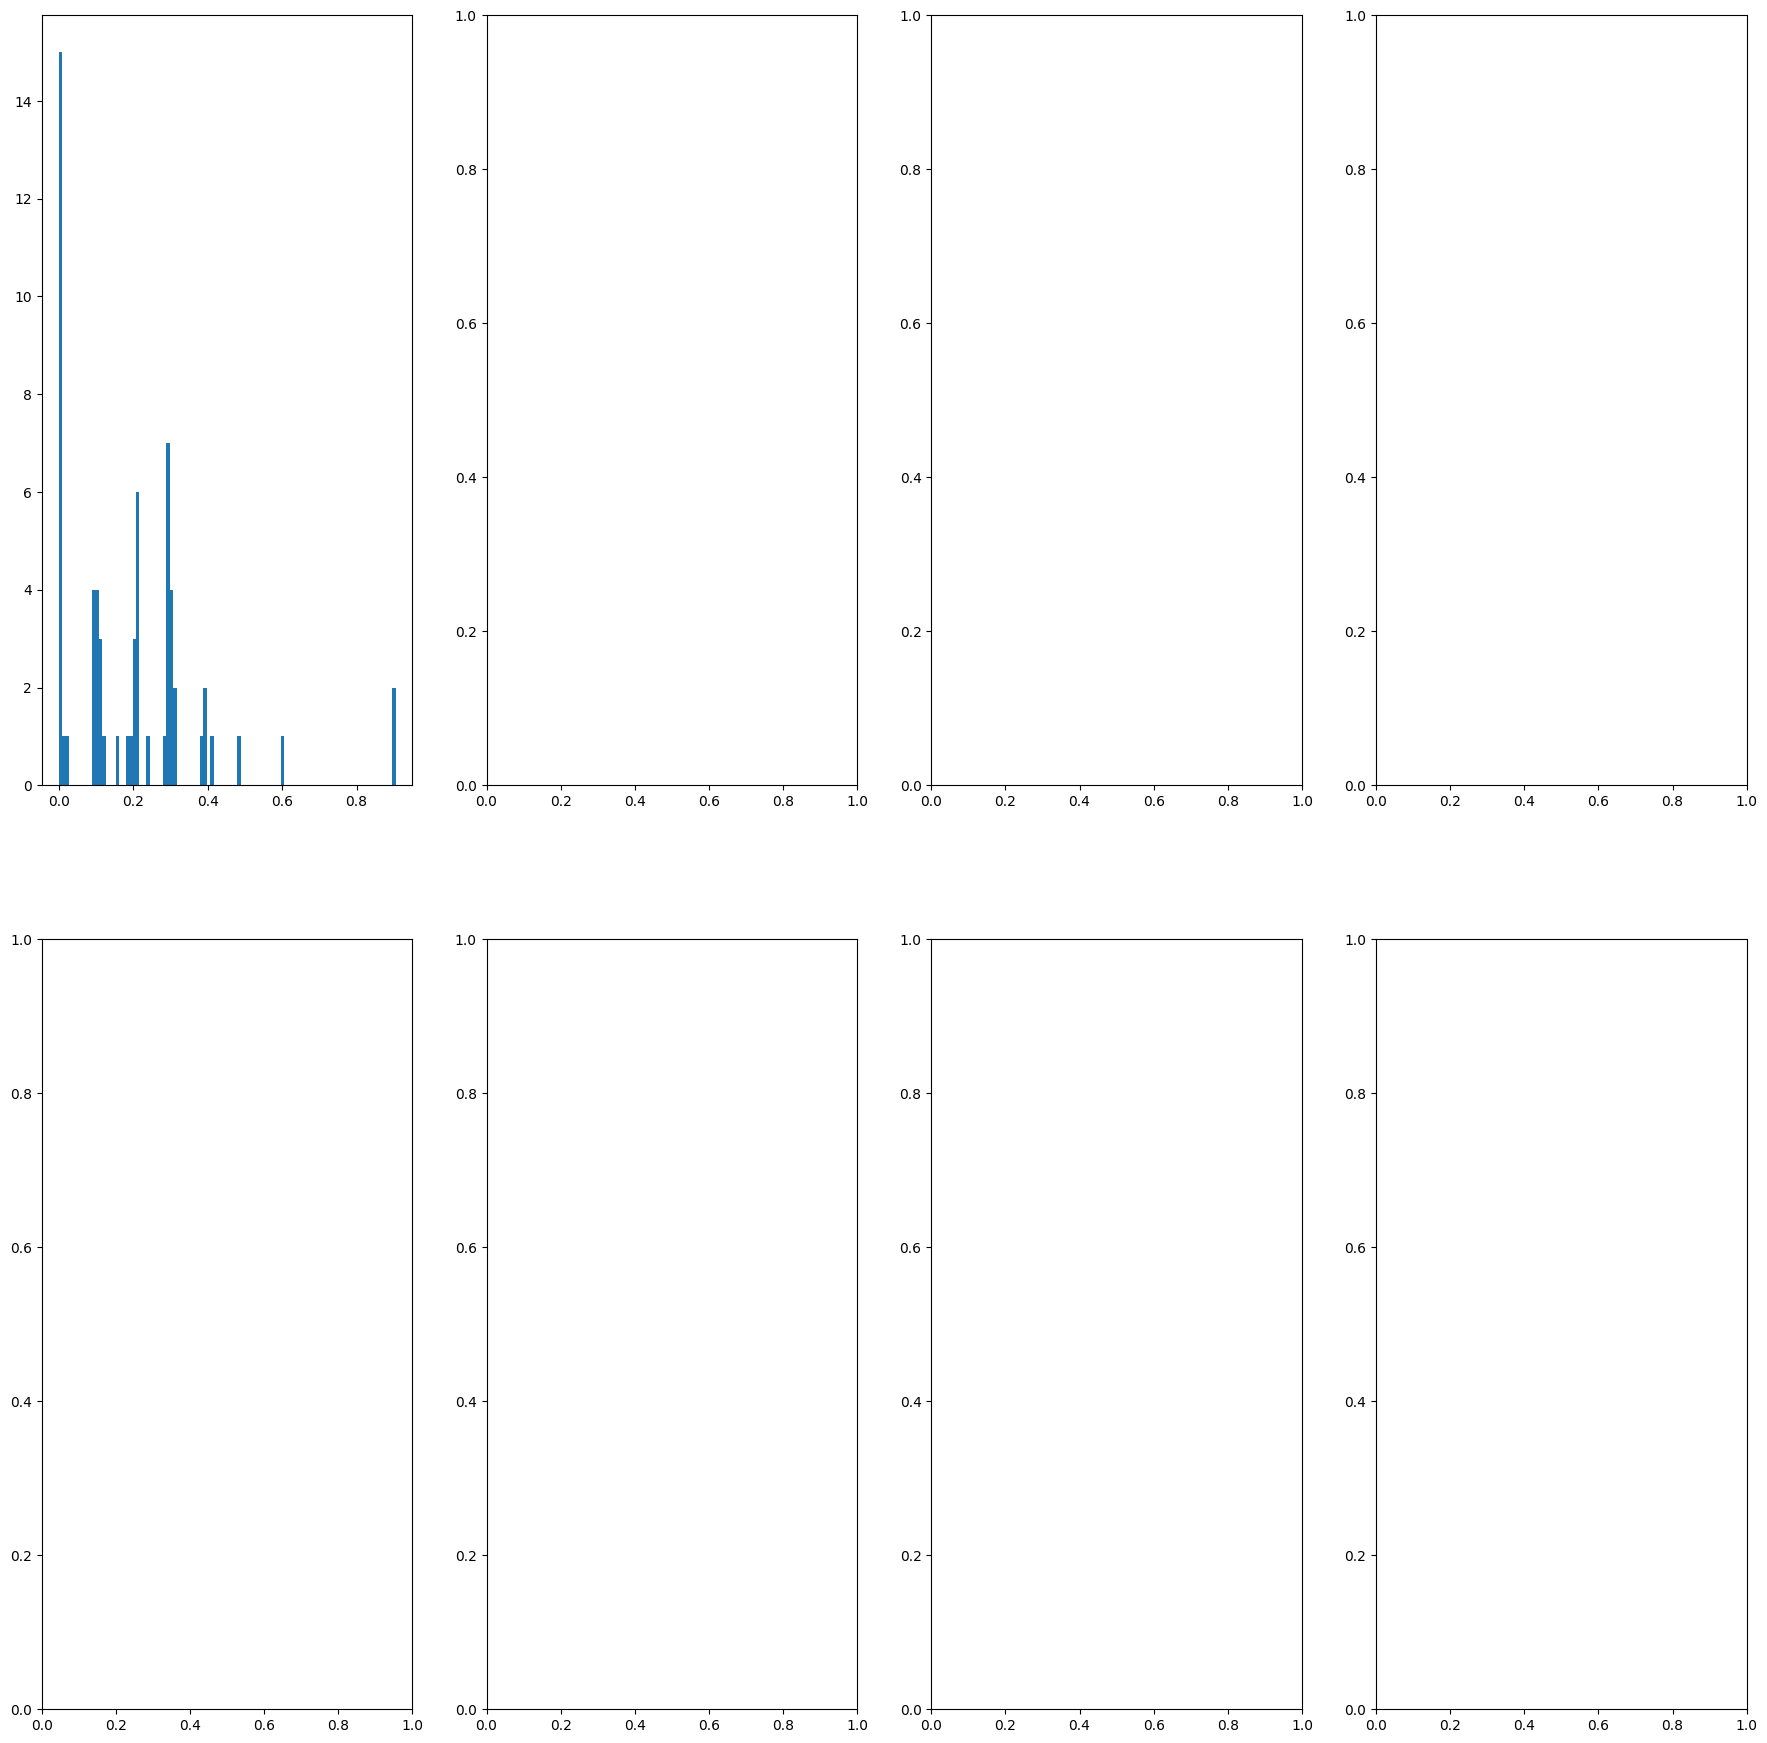

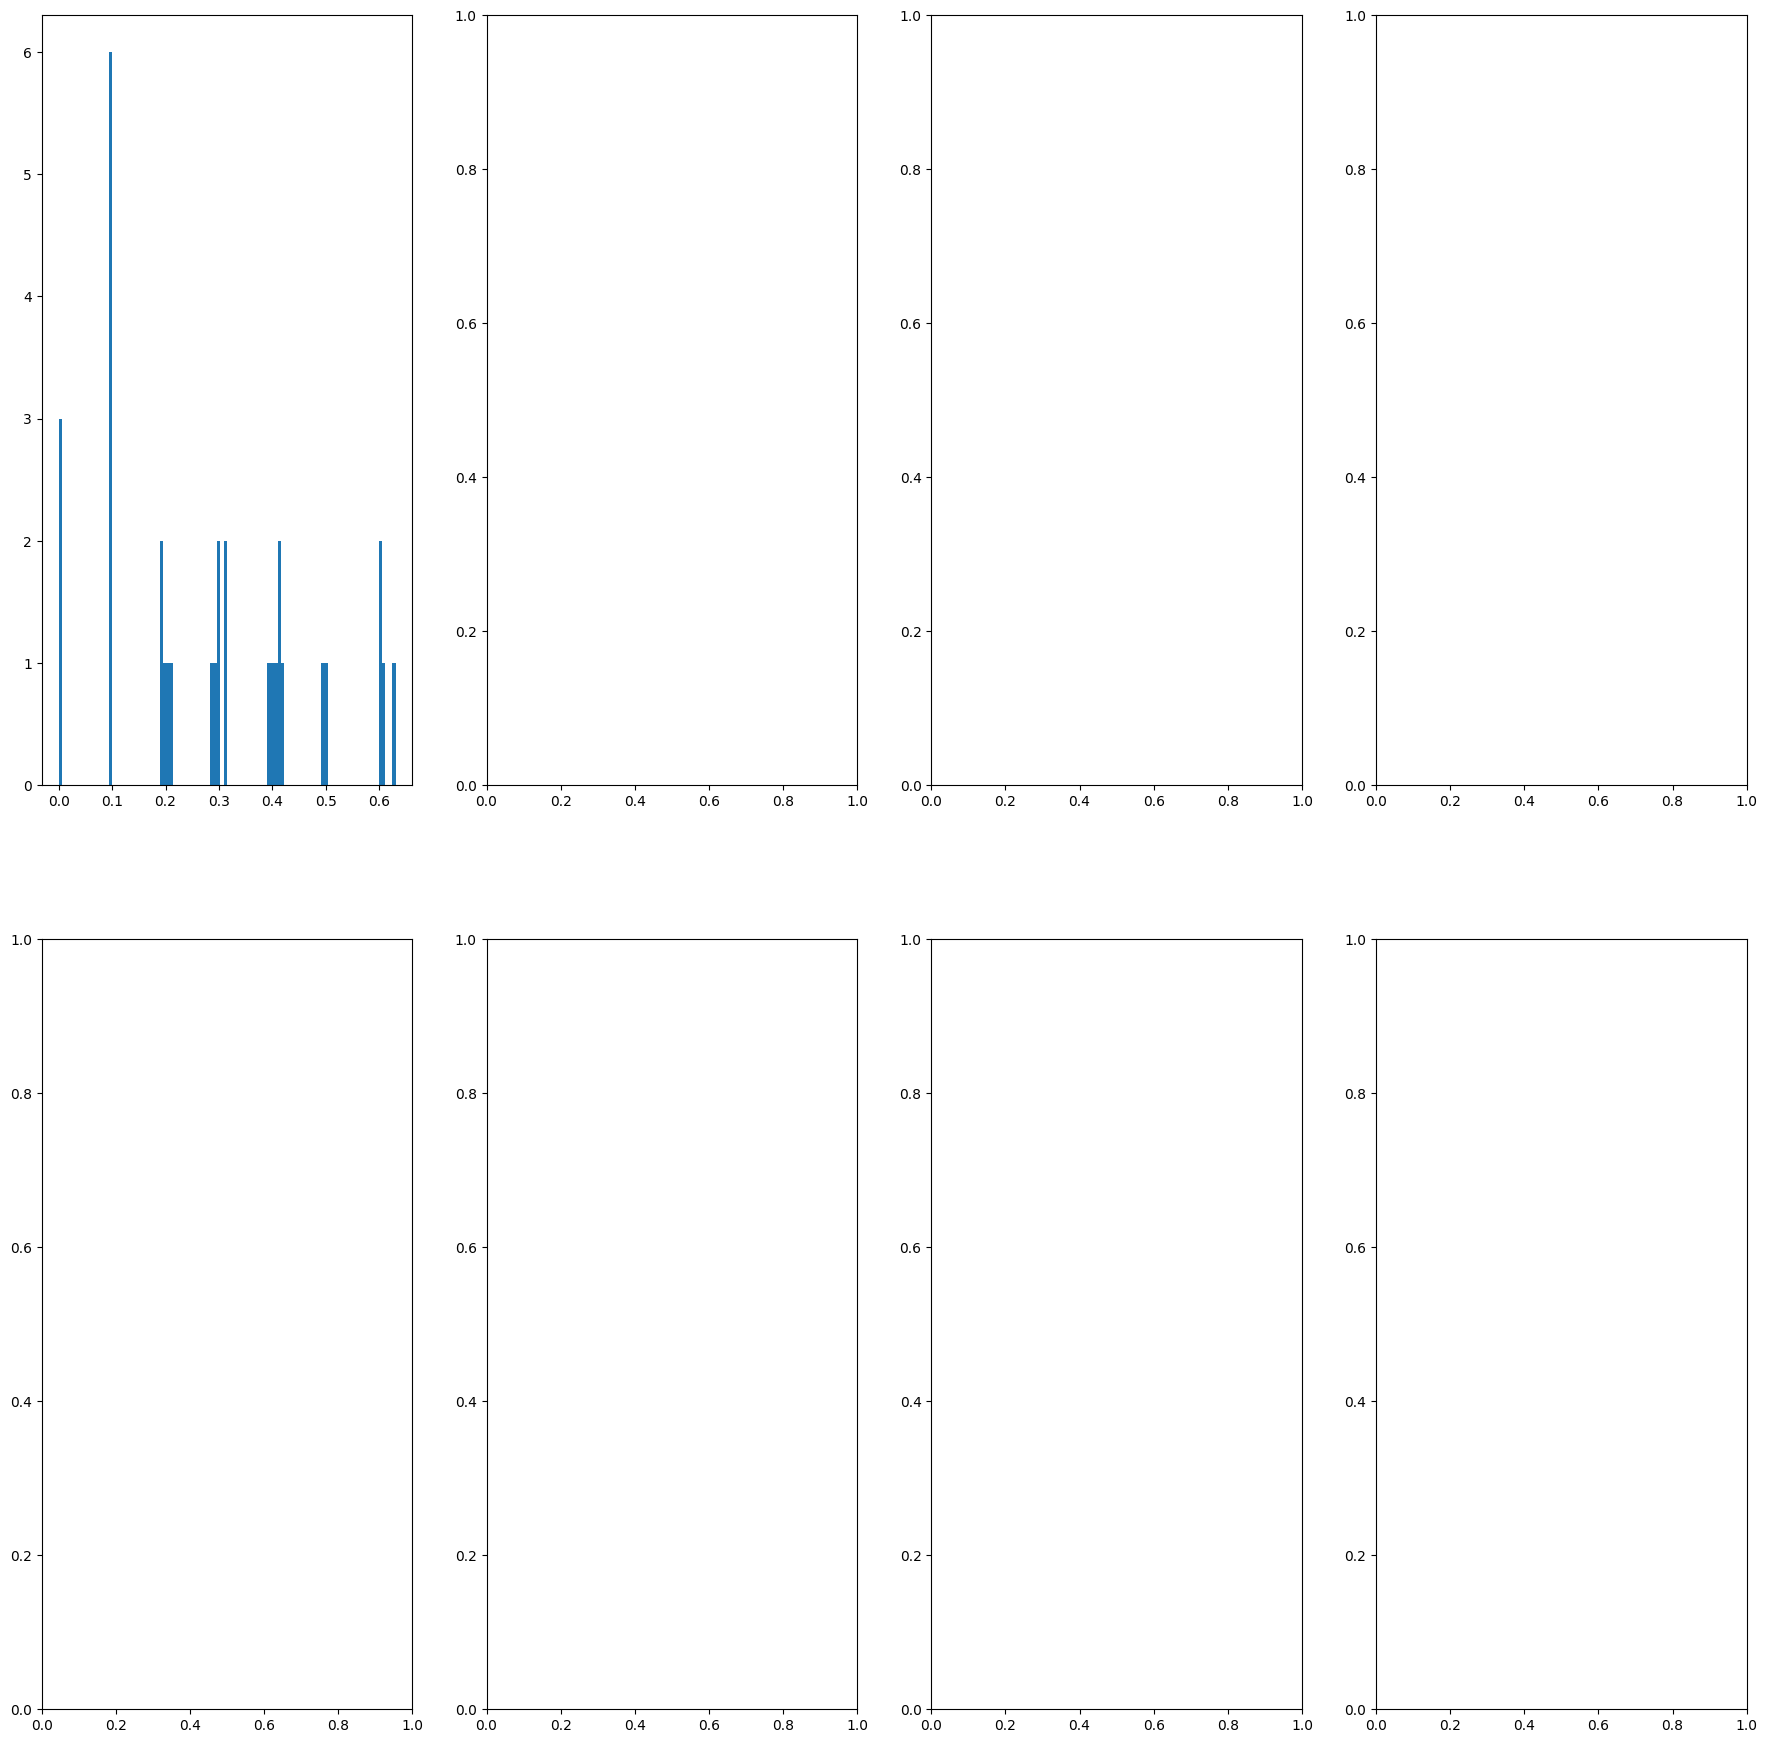

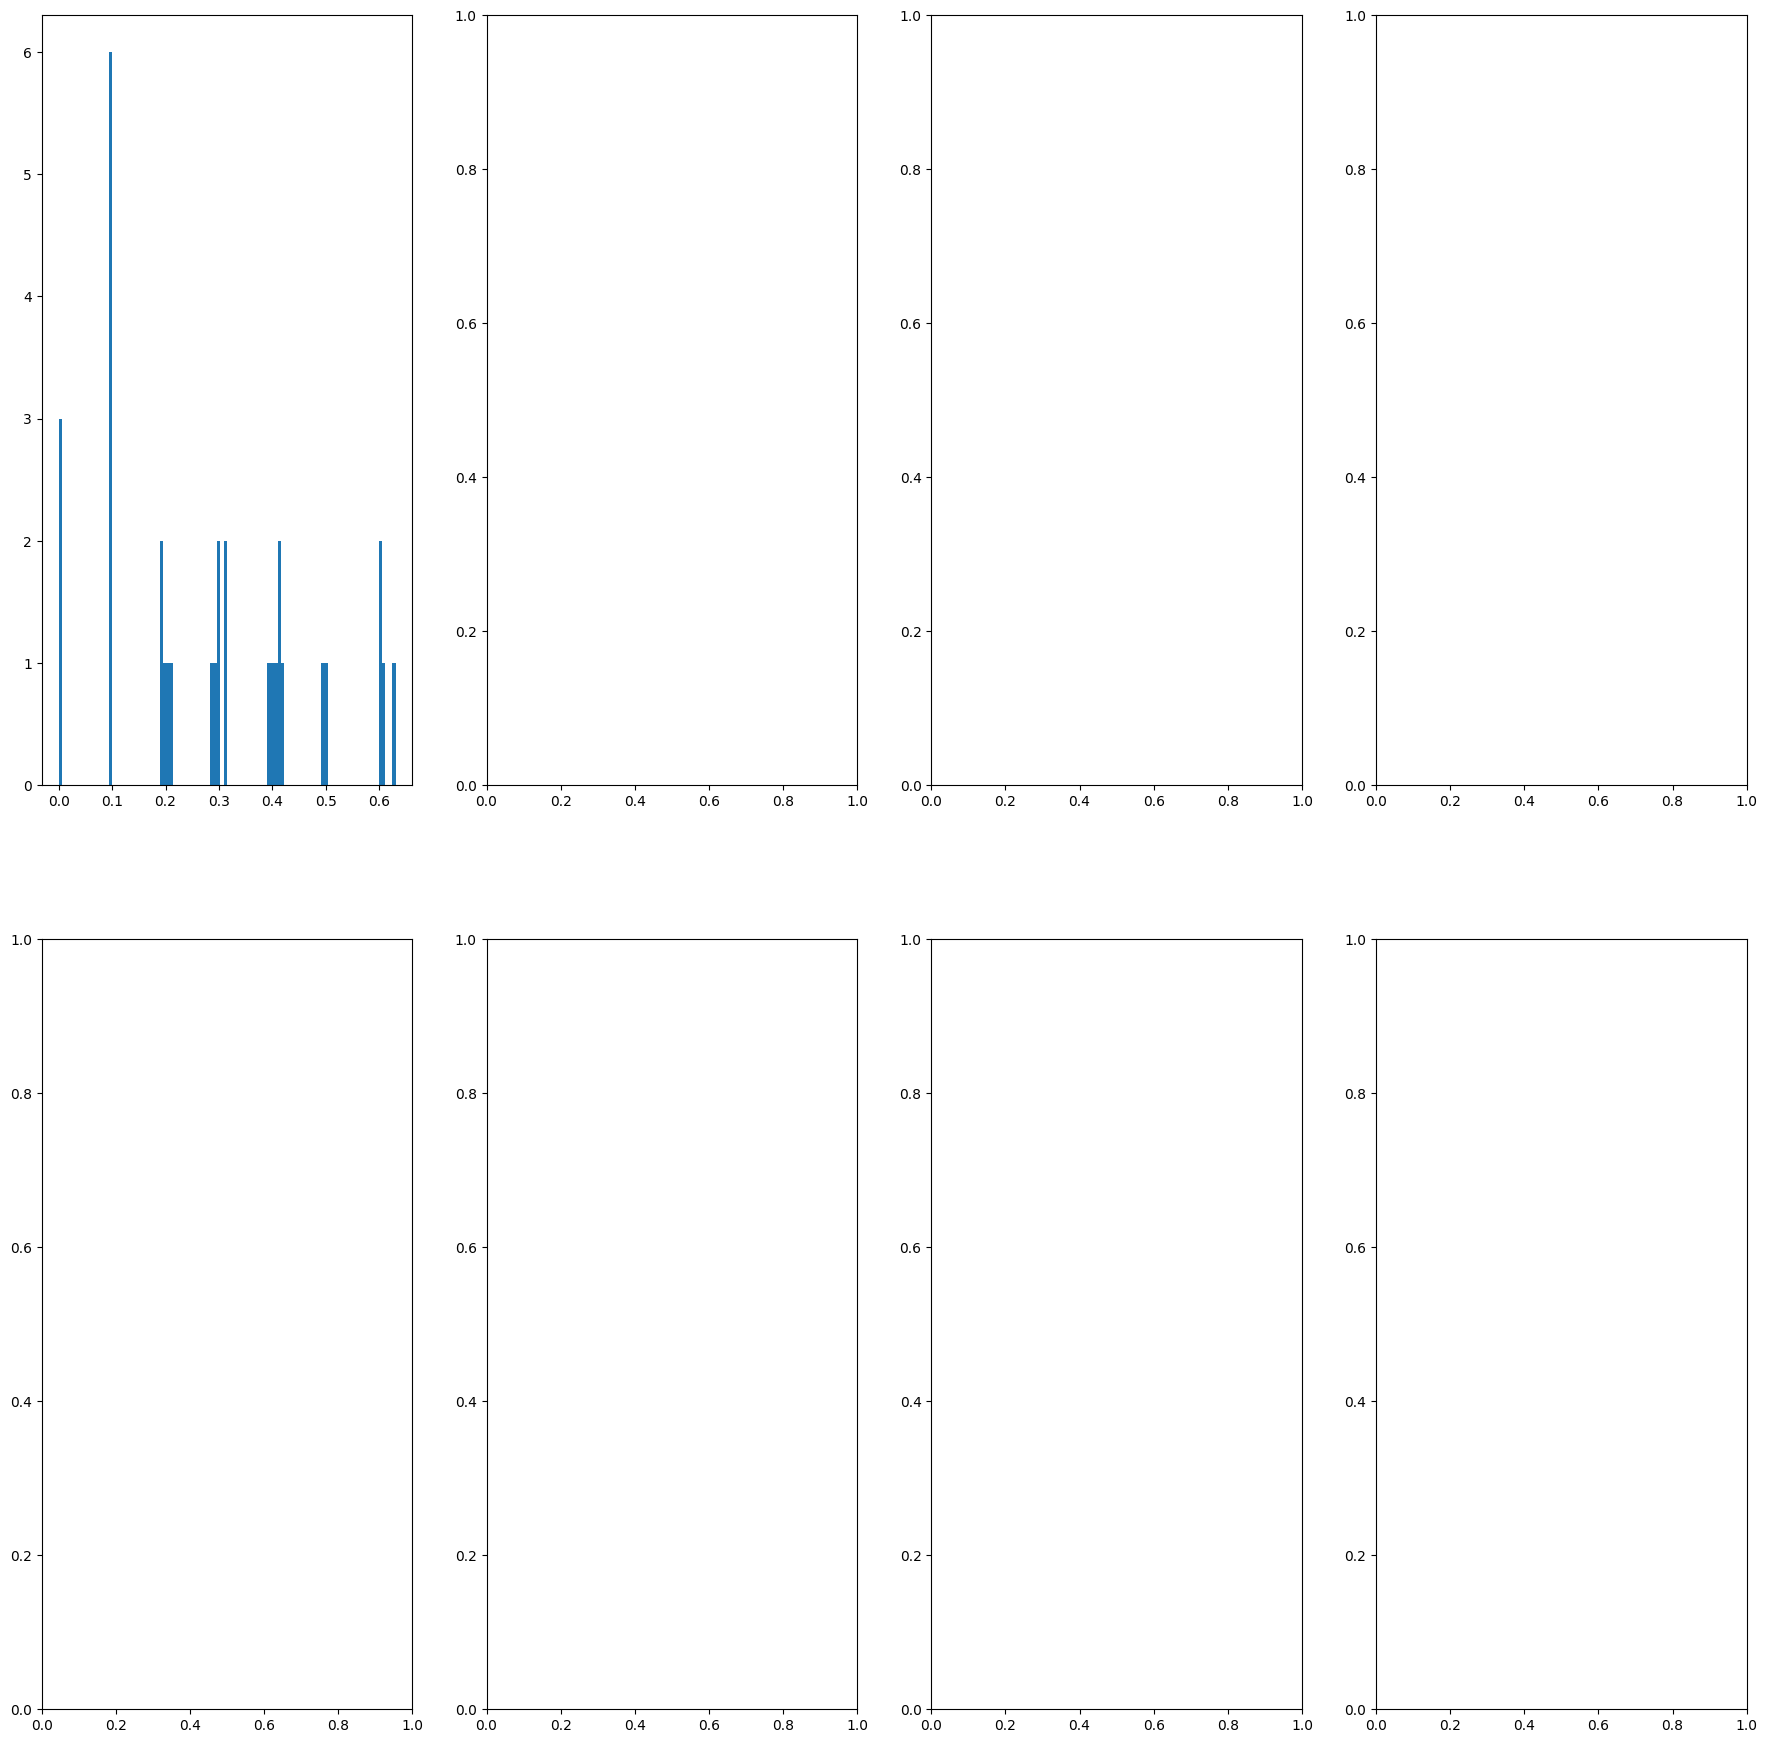

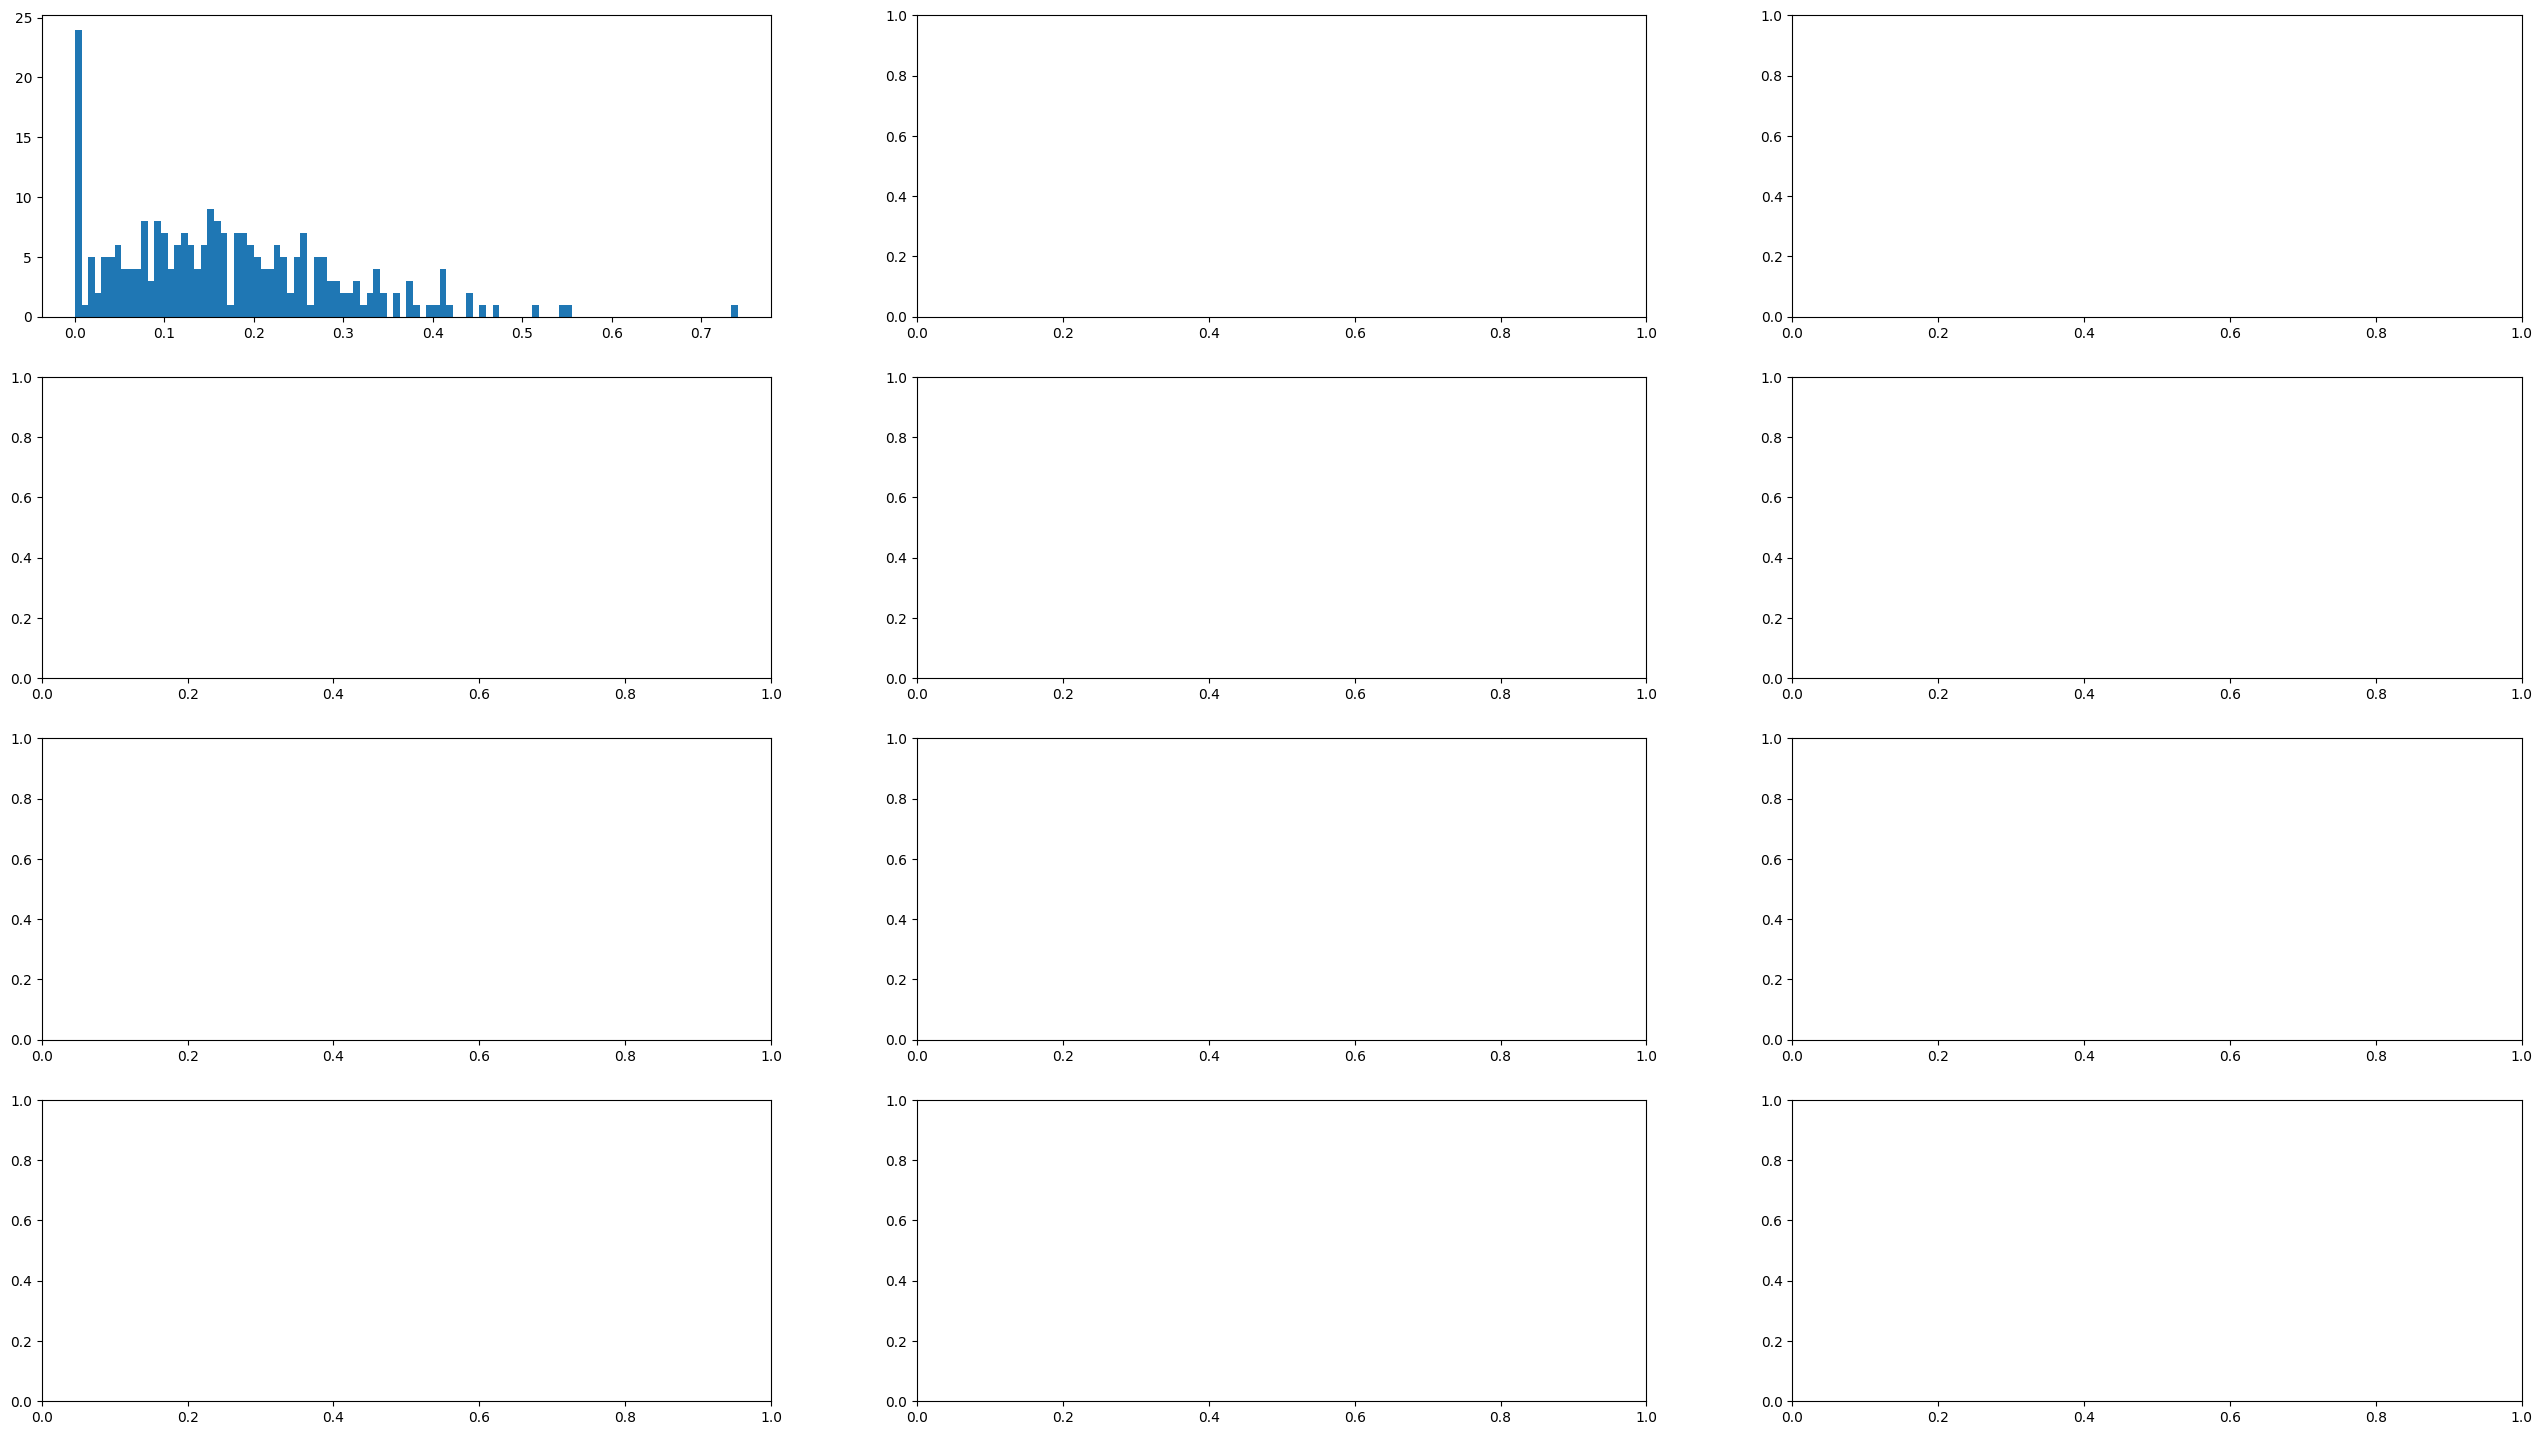

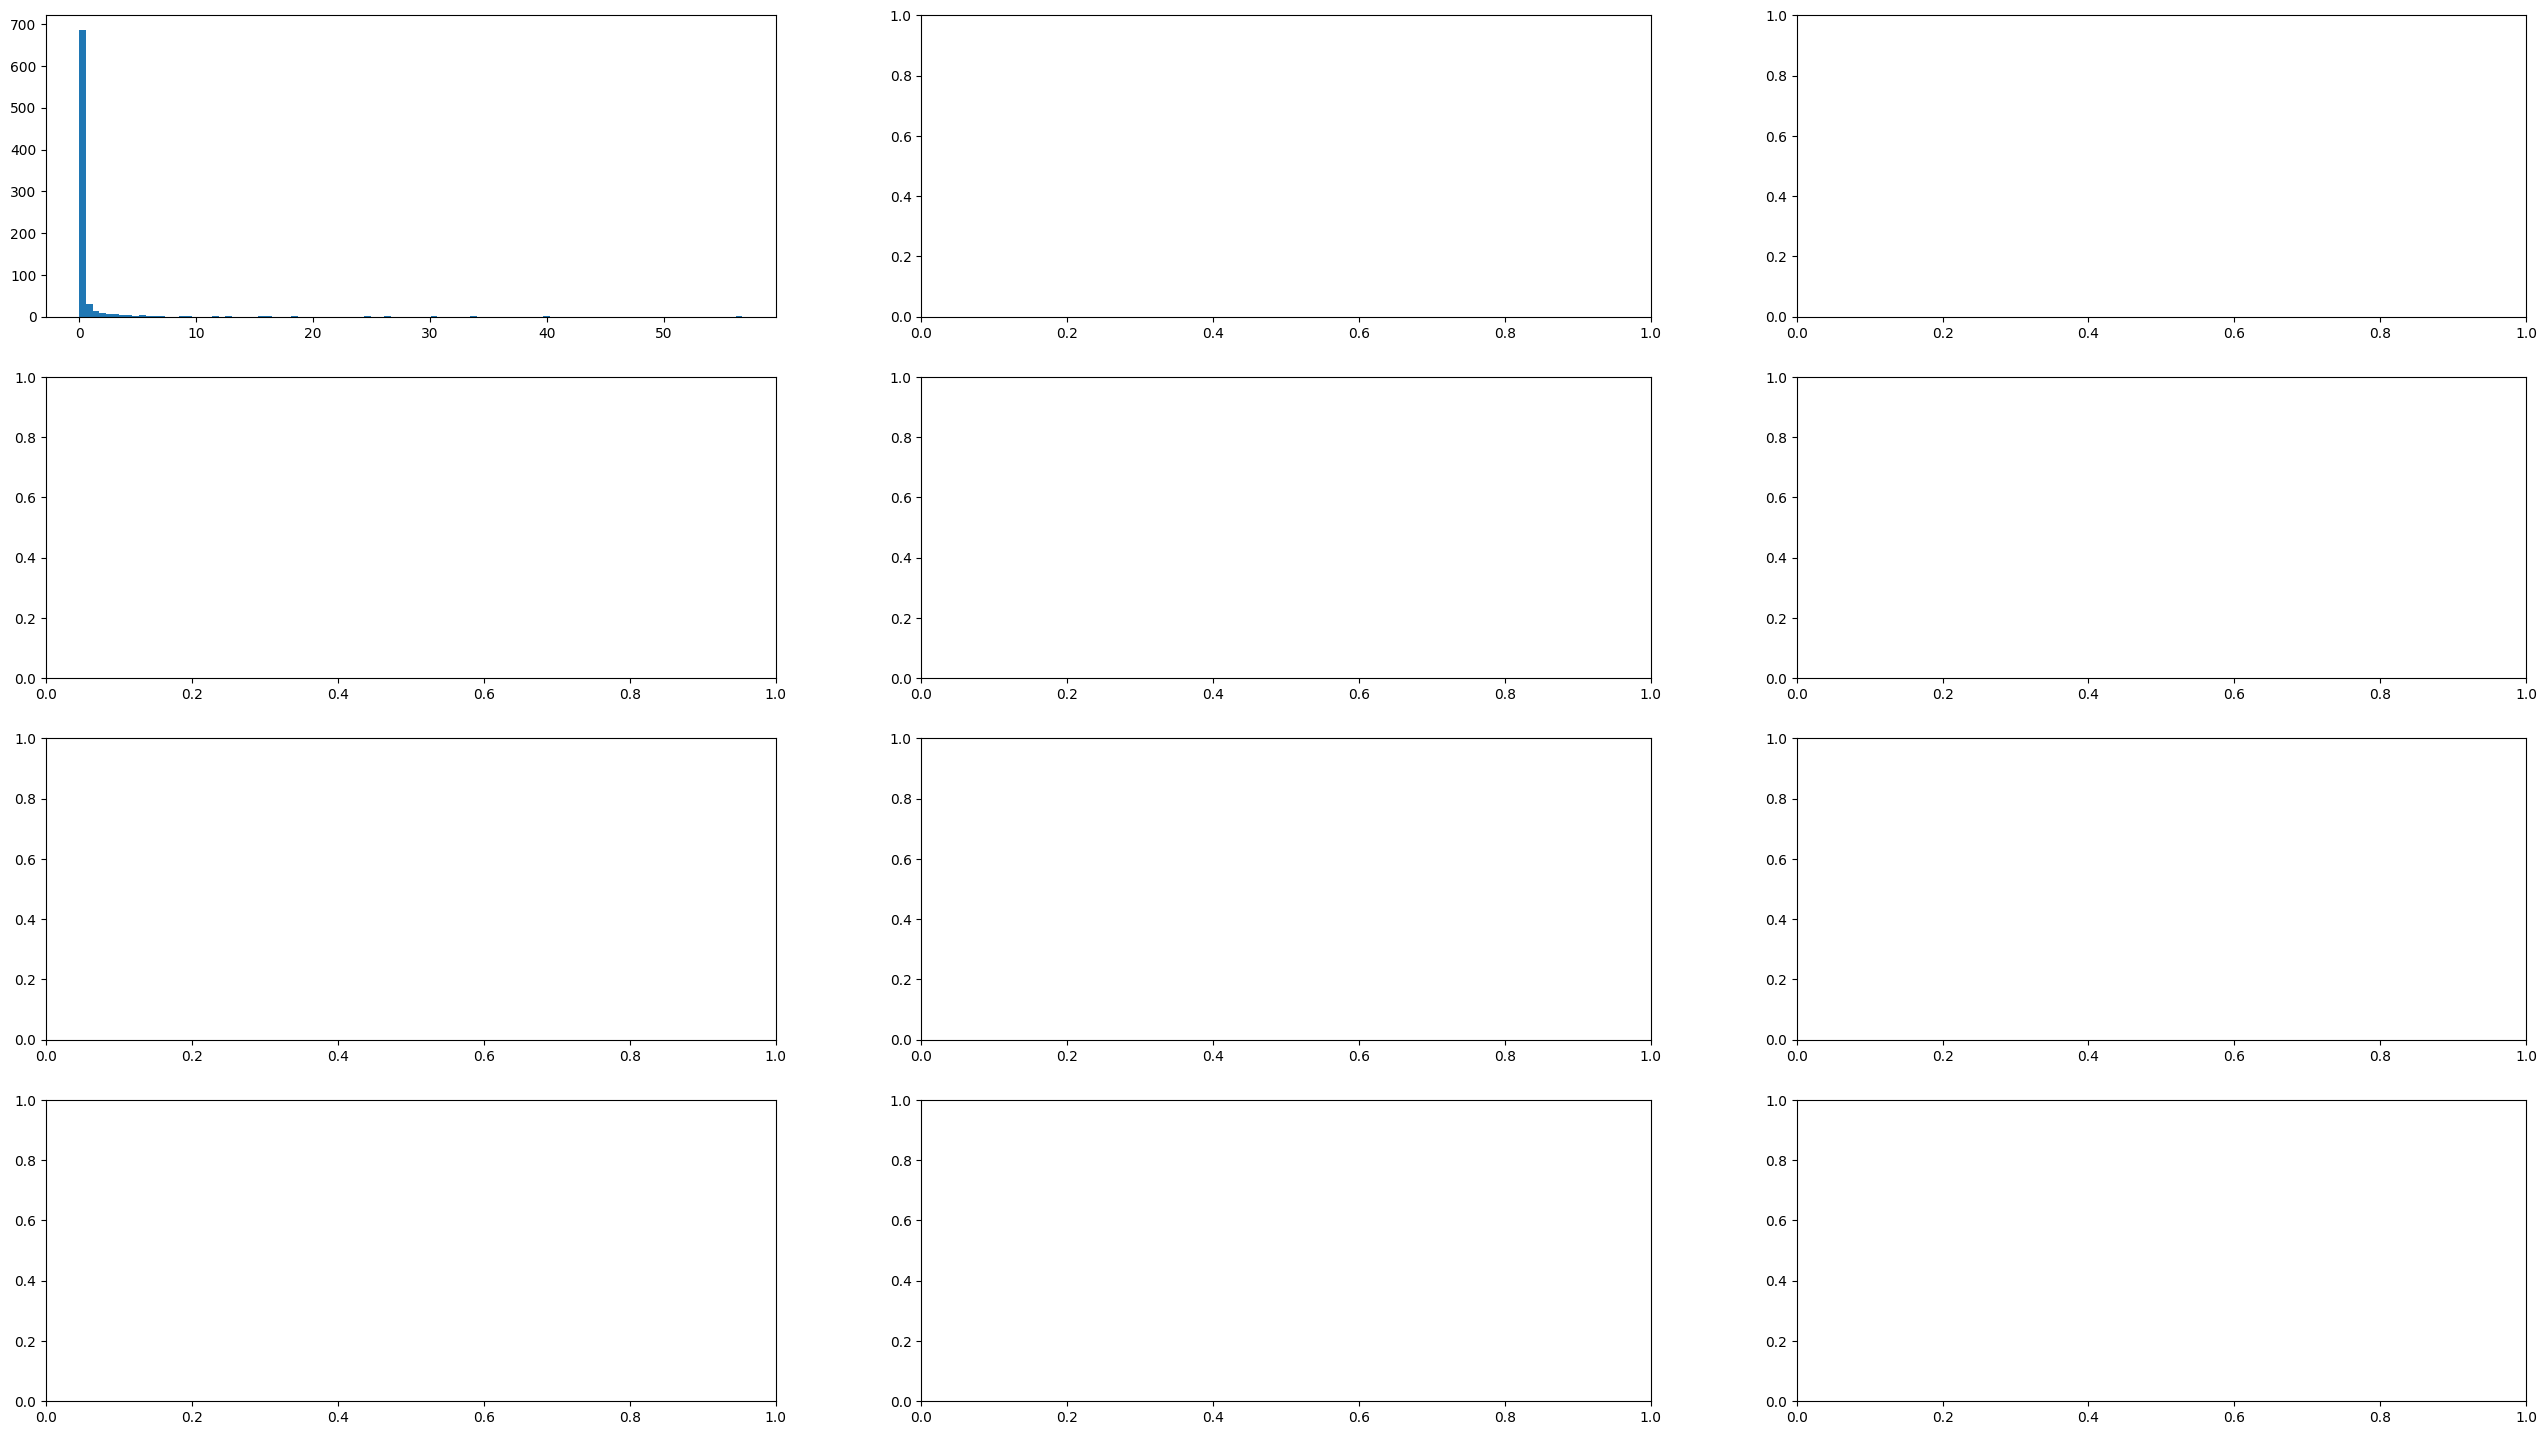

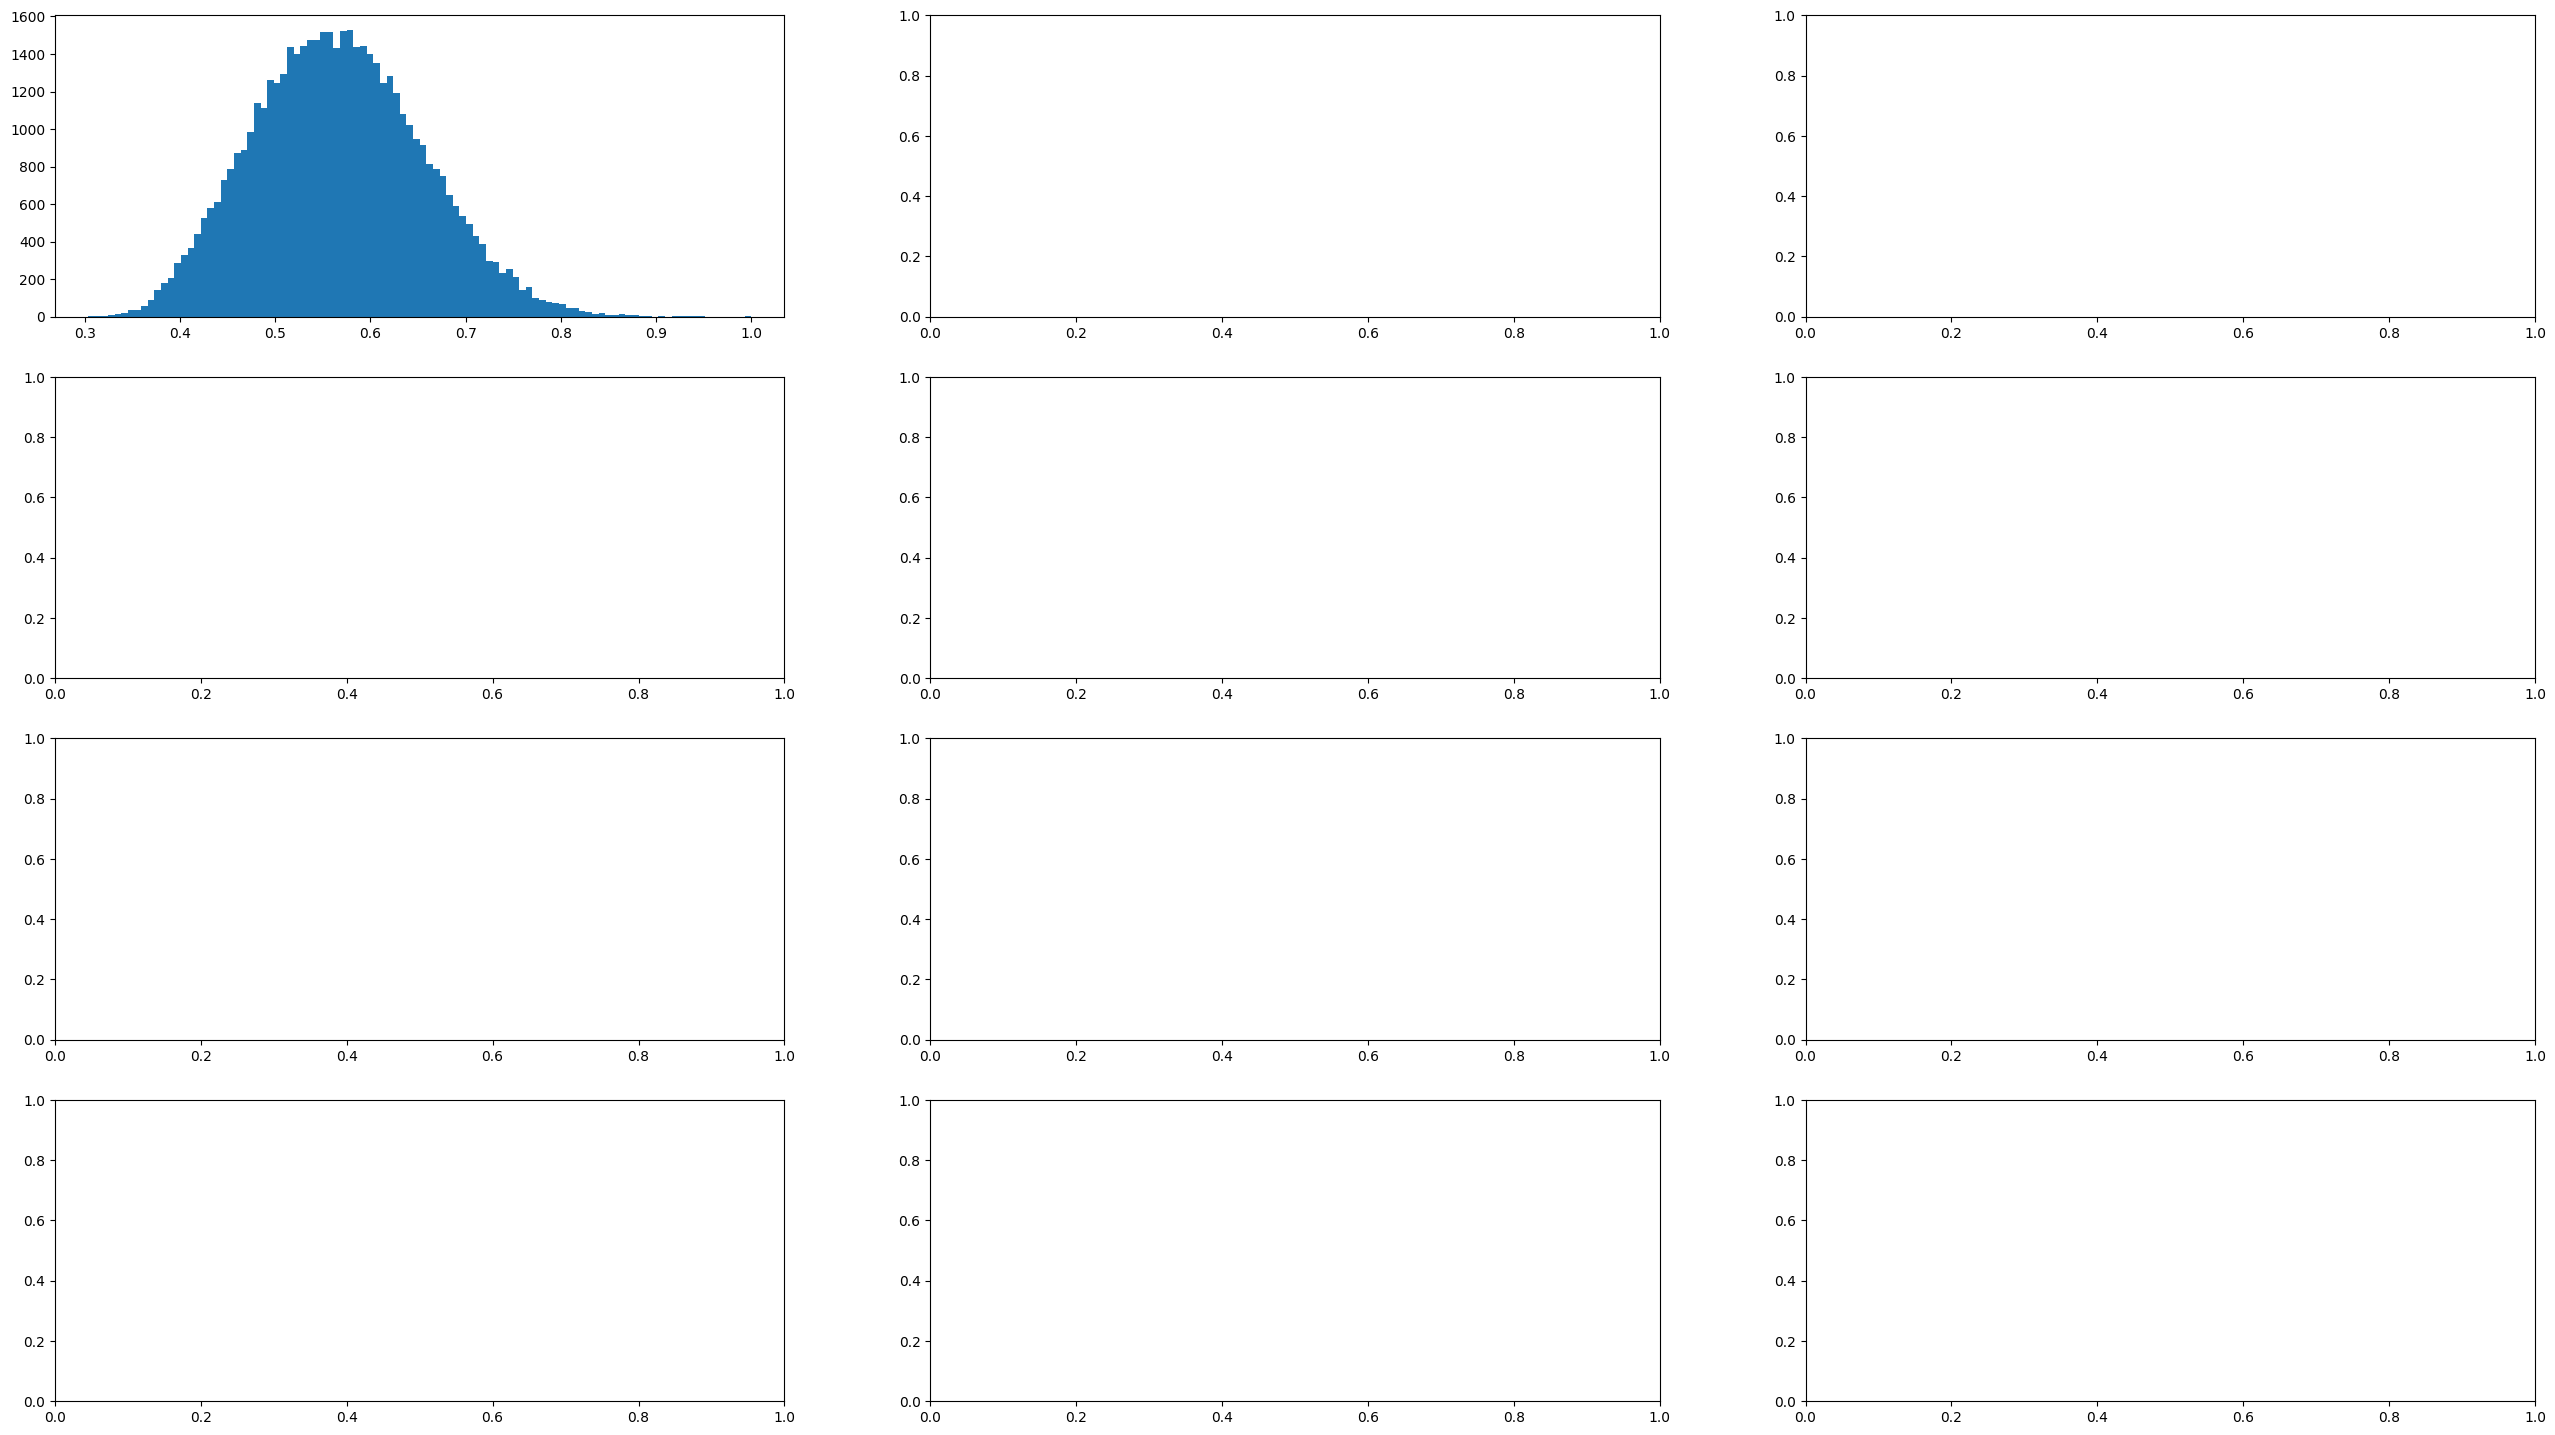

---


In [4]:
anal_path = '../../spike_analysis/test_new_algorithm25/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, dataset_target_samples, dataset_target_labels, device, '{}_{}'.format(anal_path, 'val_'), 'analyze', plotting=True)
plt.close()
print("---")

In [5]:
import numpy as np
from sklearn.linear_model import RANSACRegressor, LinearRegression


def find_multiple_hyperplanes_ransac(
    points,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01
):
    """
    Finds multiple hyperplanes in 'points' (NxD) via repeated RANSAC.
    Returns:
      - hyperplanes: list of (coef, intercept, n_inliers, total_error_for_inliers)
      - total_error: float
      - assigned_points: list of arrays, where assigned_points[i] = all points belonging to hyperplane i
    """
    residual_threshold *= (points.shape[1] - 1)
    # merge_threshold *= (points.shape[1] - 1)  # optionally scale it if desired
    
    def fit_hyperplane_ransac(points):
        n_dims = points.shape[1]
        # Randomly choose which dimension is "dependent"
        dependent_dim = np.random.randint(n_dims)
        
        X = np.delete(points, dependent_dim, axis=1)
        y = points[:, dependent_dim]
        
        ransac = RANSACRegressor(
            base_estimator=LinearRegression(),
            max_trials=1000,
            min_samples=n_dims,
            residual_threshold=residual_threshold,
            stop_probability=0.99
        )
        ransac.fit(X, y)
        return ransac, dependent_dim

    def get_hyperplane_eq(ransac, dependent_dim, n_dims):
        """
        Construct the "normal vector" (coef) and intercept
        from the RANSAC fit, making sure the hyperplane eq
        is of the form: coef dot x + intercept = 0
        """
        coef = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_
        
        full_coef = np.zeros(n_dims)
        full_coef[:dependent_dim] = coef[:dependent_dim]
        full_coef[dependent_dim+1:] = coef[dependent_dim:]
        # Put the "dependent dimension" term as -1 so that
        #   c1*x1 + ... + cd*x_d + (-1)*x_dep + intercept = 0
        full_coef[dependent_dim] = -1
        
        return full_coef, intercept

    def point_to_hyperplane_distance(point, coef, intercept):
        return np.abs(np.dot(coef, point) + intercept) / np.linalg.norm(coef)

    def hyperplane_distance(coef1, intercept1, coef2, intercept2):
        # angle between normal vectors
        cos_angle = np.dot(coef1, coef2) / (np.linalg.norm(coef1) * np.linalg.norm(coef2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        # distance between offsets
        d = np.abs(intercept1 - intercept2) / np.linalg.norm(coef1)
        return angle, d

    n_dims = points.shape[1]
    hyperplanes = []
    remaining_points = points.copy()
    assigned_points = []
    total_error = 0

    # --- 1) Iteratively find hyperplanes, remove inliers ---
    for _ in range(max_hyperplanes):
        if len(remaining_points) < min_points_for_hyperplane:
            break
        
        try:
            ransac, dependent_dim = fit_hyperplane_ransac(remaining_points)
        except:
            # If something goes wrong, just return what we have
            return [], 0, []
        
        coef, intercept = get_hyperplane_eq(ransac, dependent_dim, n_dims)
        
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]
        
        hyperplane_error = sum(
            point_to_hyperplane_distance(p, coef, intercept) for p in inlier_points
        )
        total_error += hyperplane_error
        
        hyperplanes.append((coef, intercept, len(inlier_points), hyperplane_error))
        assigned_points.append(inlier_points)
        
        # Remove inliers from the next iteration
        remaining_points = remaining_points[~inlier_mask]
    
    if len(hyperplanes) == 0:
        return [], 0, []

    # --- 2) Assign leftover points to the nearest hyperplane ---
    for point in remaining_points:
        distances = [
            point_to_hyperplane_distance(point, h[0], h[1]) for h in hyperplanes
        ]
        nearest_idx = np.argmin(distances)
        total_error += distances[nearest_idx]
        assigned_points[nearest_idx] = np.vstack([assigned_points[nearest_idx], point])

    # --- 3) Merge hyperplanes that are too close/parallel (optional) ---
    i = 0
    while i < len(hyperplanes):
        j = i + 1
        while j < len(hyperplanes):
            angle, dist = hyperplane_distance(
                hyperplanes[i][0], hyperplanes[i][1],
                hyperplanes[j][0], hyperplanes[j][1]
            )
            # If angle < merge_threshold, treat them as near the same orientation
            if angle < merge_threshold:
                # Merge them
                new_coef = (hyperplanes[i][0] + hyperplanes[j][0]) / 2
                new_intercept = (hyperplanes[i][1] + hyperplanes[j][1]) / 2
                new_inliers = hyperplanes[i][2] + hyperplanes[j][2]
                new_error = hyperplanes[i][3] + hyperplanes[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])
                
                hyperplanes[i] = (new_coef, new_intercept, new_inliers, new_error)
                assigned_points[i] = new_points
                
                del hyperplanes[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # --- 4) Sort hyperplanes by descending # of inliers ---
    hyperplanes = sorted(
        zip(hyperplanes, assigned_points), 
        key=lambda x: x[0][2],  # number of inliers
        reverse=True
    )
    hyperplanes, assigned_points = zip(*hyperplanes)

    return list(hyperplanes), total_error, list(assigned_points)


In [6]:
def project_points_onto_hyperplane(points, coef, intercept):
    """
    Project all points in NxD onto the hyperplane given by:
        coef . x + intercept = 0
    Then return an (N, D) array of the projected coordinates in the *original* space
    (all lying on the hyperplane).
    """
    w = coef
    w_norm = np.linalg.norm(w)
    if w_norm < 1e-12:
        # Degenerate case, just return the original
        return points.copy()
    
    w_unit = w / w_norm
    
    # For each point x, subtract the component along w_unit
    # that places the point exactly in the hyperplane
    # i.e. x_proj = x - ( (x dot w_unit) + intercept/||w|| ) w_unit
    offsets = np.dot(points, w_unit) + (intercept / w_norm)
    # shape (N,) -> repeat in each dimension
    x_proj = points - offsets[:, None] * w_unit[None, :]
    
    return x_proj


def reduce_to_subspace(points, coef):
    """
    Return an (N, D-1) representation of 'points' that lie in the hyperplane
    spanned by an orthonormal basis orthogonal to 'coef'.
    This effectively yields new coordinates in that (D-1)-dim subspace.
    """
    n_dims = points.shape[1]
    w = coef / np.linalg.norm(coef)
    
    # We want to construct an orthonormal basis for the subspace orthonormal to w.
    # A simple way is to use e.g. scipy's null_space, or do a Gram-Schmidt approach manually.
    #
    # For an nD normal vector w, the subspace is dimension (n-1). We want a basis B.
    # Let's do a quick approach with SVD on (w) to find the null space:
    u, s, vh = np.linalg.svd(w.reshape(1, -1))
    # The last (n-1) rows of vh^T form a basis for the orth space
    # But we need to check which row of V^T is the direction of w vs orth. 
    # Actually in a single row rank-1 matrix, we can just take the rows 1..(n-1) of vh.
    
    # vh has shape (n, n). The first row is w/||w||, the remaining rows are orthonormal to w
    B = vh[1:, :]  # shape (n-1, n)
    
    # Now project each point (which is already in the hyperplane) onto that basis:
    # new_coords shape: (N, n-1)
    new_coords = points @ B.T
    return new_coords


In [7]:
def hierarchical_spike_detection_nd(
    points,
    min_dim=1,
    max_recursion_depth=None,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01,
    recursion_level=0
):
    """
    Hierarchically peel off one dimension at a time by:
      1) Finding the best hyperplane in the current dimension (with RANSAC).
      2) Projecting onto that hyperplane -> reduces dimension by 1.
      3) Recursing until dimension == min_dim or no further hyperplane found.

    Returns a list of dicts, each describing one step's hyperplane + projected data, e.g.:
      [ 
        {
          'dimension': D, 
          'coef': best_coef,
          'intercept': best_intercept,
          'inlier_points': best_inlier_points (N_k x D),
          'projected_points': shape (N_k x (D-1))
        },
        ...
      ]
    """
    n_dims = points.shape[1]
    if max_recursion_depth is not None and recursion_level >= max_recursion_depth:
        # Reached recursion limit
        return []
    if n_dims <= min_dim:
        # Already at or below desired dimension
        return []
    if len(points) < min_points_for_hyperplane:
        # Not enough points to meaningfully do RANSAC
        return []
    
    # 1) Run your multiple-hyperplane detection in the current dimension
    hyperplanes, total_error, assigned_sets = find_multiple_hyperplanes_ransac(
        points,
        max_hyperplanes=max_hyperplanes,
        min_points_for_hyperplane=min_points_for_hyperplane,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold
    )
    if len(hyperplanes) == 0:
        # Could not find any hyperplane
        return []

    # 2) Select the "best" hyperplane by # of inliers
    #    (the find_multiple_hyperplanes_ransac() already sorts them,
    #     so hyperplanes[0] should be the one with the most inliers)
    best_coef, best_intercept, n_inliers, best_err = hyperplanes[0]
    best_inlier_points = assigned_sets[0]  # NxD

    # 3) Project all those inlier points exactly onto that hyperplane 
    #    (this is optional if we trust they already lie "near" it)
    best_inlier_points_on_hp = project_points_onto_hyperplane(
        best_inlier_points, best_coef, best_intercept
    )

    # 4) Convert from NxD on-hyperplane to Nx(D-1) subspace coords
    #    so we truly reduce dimension
    reduced_points = reduce_to_subspace(best_inlier_points_on_hp, best_coef)

    # 5) Recursively call the hierarchical approach again, 
    #    but only on the inliers (since they define the next "spike").
    next_steps = hierarchical_spike_detection_nd(
        reduced_points,
        min_dim=min_dim,
        max_recursion_depth=max_recursion_depth,
        max_hyperplanes=max_hyperplanes,
        min_points_for_hyperplane=min_points_for_hyperplane,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold,
        recursion_level=recursion_level + 1
    )

    # 6) Build the info for the current level
    this_level_info = {
        "dimension": n_dims,
        "coef": best_coef,
        "intercept": best_intercept,
        "n_inliers": n_inliers,
        "inlier_points_original_dim": best_inlier_points,      # shape NxD
        "inlier_points_on_hyperplane": best_inlier_points_on_hp,  # NxD but truly in hyperplane
        "projected_points_(D-1)": reduced_points               # Nx(D-1)
    }

    # Return a list: the current level plus all subsequent levels
    return [this_level_info] + next_steps


In [8]:
def generate_3d_lines(n_lines=3, points_per_line=200, noise=0.05, random_state=42):
    """
    Generate 3D data points lying near multiple lines.
    Each line is defined by a random point and a direction.
    """
    np.random.seed(random_state)
    data = []
    true_lines = []
    
    for _ in range(n_lines):
        # Random point on the line
        point = np.random.uniform(-1, 1, size=3)
        # Random direction (unit vector)
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        
        # Generate points along the line
        t = np.linspace(-1, 1, points_per_line)
        line_points = point + np.outer(t, direction)
        
        # Add Gaussian noise
        line_points += np.random.normal(scale=noise, size=line_points.shape)
        
        data.append(line_points)
        true_lines.append((point, direction))
    
    data = np.vstack(data)
    return data, true_lines


# Generate test data
data, true_lines = generate_3d_lines(n_lines=3, points_per_line=300, noise=0.02)

# Apply hierarchical spike detection
results = hierarchical_spike_detection_nd(
    data,
    min_dim=1,             # We stop once we get down to 1D 
    max_recursion_depth=3, # Or limit to 3 recursions
    max_hyperplanes=5,
    min_points_for_hyperplane=100,
    residual_threshold=0.05,
    merge_threshold=0.1
)

print(f"Detected {len(results)} hierarchical levels.")
for i, level in enumerate(results):
    print(f"Level {i+1}: Dimension was {level['dimension']}")
    print(f"  # inliers: {level['n_inliers']}")
    print(f"  shape of (D-1) projected data = {level['projected_points_(D-1)'].shape}")


Detected 2 hierarchical levels.
Level 1: Dimension was 3
  # inliers: 418
  shape of (D-1) projected data = (418, 2)
Level 2: Dimension was 2
  # inliers: 296
  shape of (D-1) projected data = (300, 1)


/home/mila/m/mehrab.hamidi/.conda/envs/py38_ssl/lib/python3.8/site-packages/sklearn/linear_model/_ransac.py:320: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/home/mila/m/mehrab.hamidi/.conda/envs/py38_ssl/lib/python3.8/site-packages/sklearn/linear_model/_ransac.py:320: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/home/mila/m/mehrab.hamidi/.conda/envs/py38_ssl/lib/python3.8/site-packages/sklearn/linear_model/_ransac.py:320: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/home/mila/m/mehrab.hamidi/.conda/envs/py38_ssl/lib/python3.8/site-packages/sklearn/linear_model/_ransac.py:320: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/home/mila/m/mehrab.hamidi/.conda/envs/py38_ssl/lib/python3.8/site-packa

/tmp/ipykernel_1128236/1588986160.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(results))


IndexError: index 2 is out of bounds for axis 1 with size 2

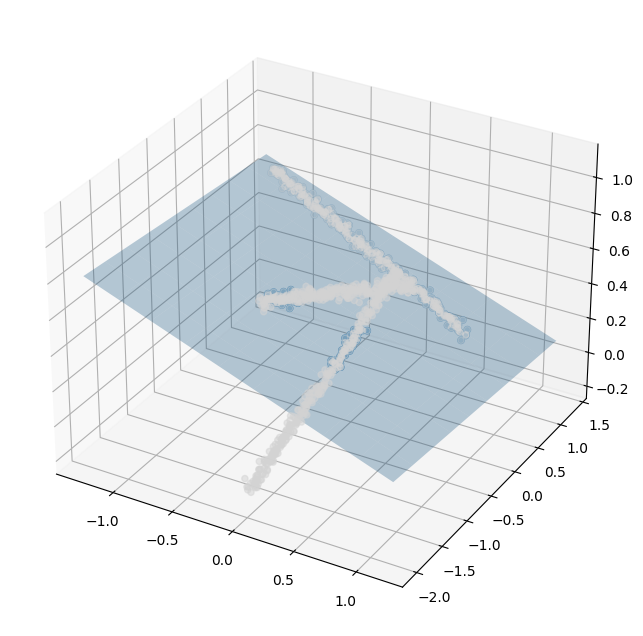

In [9]:
def plot_hyperplanes_3d(ax, coef, intercept, xlim, ylim, color='r', alpha=0.3):
    """
    Plot a hyperplane in 3D defined by coef . x + intercept = 0
    """
    # To plot the plane, we need to solve for z in terms of x and y
    # Assuming coef[2] != 0
    if coef[2] != 0:
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                             np.linspace(ylim[0], ylim[1], 10))
        zz = (-coef[0] * xx - coef[1] * yy - intercept) / coef[2]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[1] != 0:
        # Solve for y
        xx, zz = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                             np.linspace(-1, 1, 10))
        yy = (-coef[0] * xx - coef[2] * zz - intercept) / coef[1]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[0] != 0:
        # Solve for x
        yy, zz = np.meshgrid(np.linspace(ylim[0], ylim[1], 10),
                             np.linspace(-1, 1, 10))
        xx = (-coef[1] * yy - coef[2] * zz - intercept) / coef[0]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    else:
        # Degenerate case, do not plot
        pass

def visualize_results(data, results):
    """
    Visualize the original data points and the detected hyperplanes.
    Each hyperplane's inliers are colored uniquely.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all data points in light gray
    ax.scatter(data[:,0], data[:,1], data[:,2], color='lightgray', label='All Data', alpha=0.5)
    
    # Define a color map
    colors = cm.get_cmap('tab10', len(results))
    
    for idx, level in enumerate(results):
        inliers = level['inlier_points_original_dim']
        coef = level['coef']
        intercept = level['intercept']
        
        # Plot inlier points
        ax.scatter(inliers[:,0], inliers[:,1], inliers[:,2], 
                   color=colors(idx), 
                   label=f'Hyperplane {idx+1} Inliers')
        
        # Define plot limits based on data
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # Plot the hyperplane
        plot_hyperplanes_3d(ax, coef, intercept, xlim, ylim, color=colors(idx), alpha=0.3)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Hierarchical Spike Detection in 3D Data')
    ax.legend()
    plt.show()


visualize_results(data, results)


Detected 2 hierarchical levels.
Level 1: Dimension was 3
  # inliers: 518
  shape of (D-1) projected data = (571, 2)
Level 2: Dimension was 2
  # inliers: 300
  shape of (D-1) projected data = (300, 1)


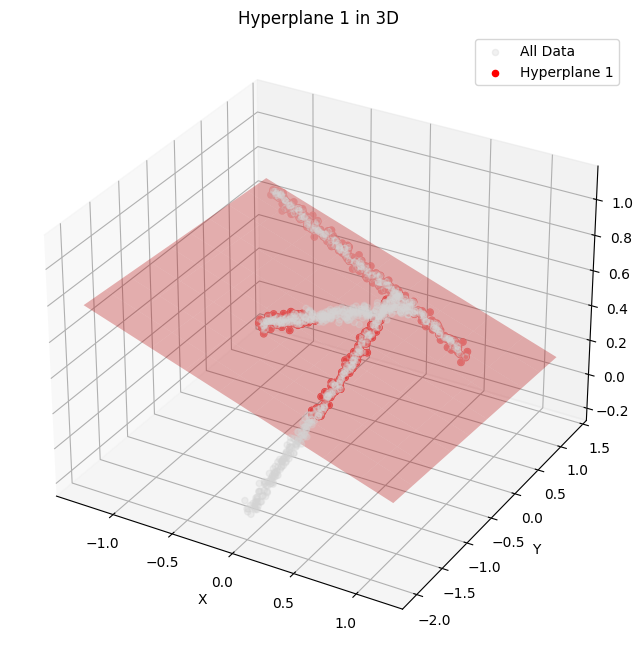

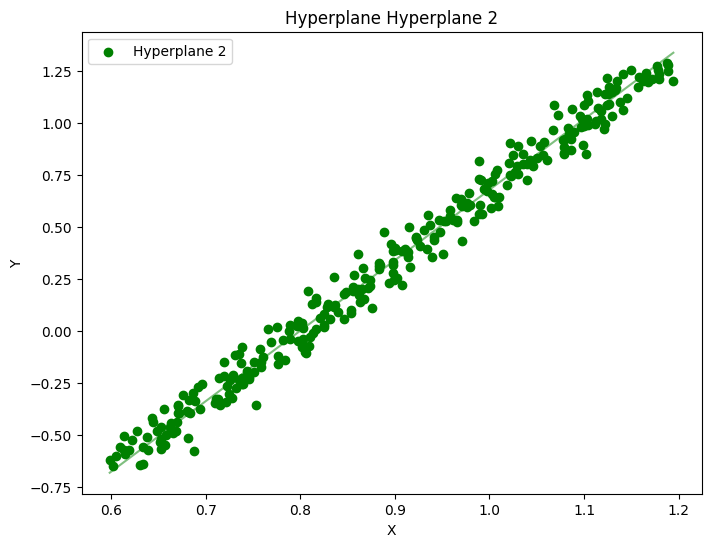

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib import cm

def find_multiple_hyperplanes_ransac(
    points,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01
):
    """
    Finds multiple hyperplanes in 'points' (NxD) via repeated RANSAC.
    Returns:
      - hyperplanes: list of (coef, intercept, n_inliers, total_error_for_inliers)
      - total_error: float
      - assigned_points: list of arrays, where assigned_points[i] = all points belonging to hyperplane i
    """
    residual_threshold *= (points.shape[1] - 1)
    # merge_threshold *= (points.shape[1] - 1)  # optionally scale it if desired

    def fit_hyperplane_ransac(points):
        n_dims = points.shape[1]
        # Randomly choose which dimension is "dependent"
        dependent_dim = np.random.randint(n_dims)
        
        X = np.delete(points, dependent_dim, axis=1)
        y = points[:, dependent_dim]
        
        ransac = RANSACRegressor(
            estimator=LinearRegression(),  # Updated parameter name
            max_trials=1000,
            min_samples=n_dims,
            residual_threshold=residual_threshold,
            stop_probability=0.99
        )
        ransac.fit(X, y)
        return ransac, dependent_dim

    def get_hyperplane_eq(ransac, dependent_dim, n_dims):
        """
        Construct the "normal vector" (coef) and intercept
        from the RANSAC fit, making sure the hyperplane eq
        is of the form: coef dot x + intercept = 0
        """
        coef = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_
        
        full_coef = np.zeros(n_dims)
        full_coef[:dependent_dim] = coef[:dependent_dim]
        full_coef[dependent_dim+1:] = coef[dependent_dim:]
        # Put the "dependent dimension" term as -1 so that
        #   c1*x1 + ... + cd*x_d + (-1)*x_dep + intercept = 0
        full_coef[dependent_dim] = -1
        
        return full_coef, intercept

    def point_to_hyperplane_distance(point, coef, intercept):
        return np.abs(np.dot(coef, point) + intercept) / np.linalg.norm(coef)

    def hyperplane_distance(coef1, intercept1, coef2, intercept2):
        # angle between normal vectors
        cos_angle = np.dot(coef1, coef2) / (np.linalg.norm(coef1) * np.linalg.norm(coef2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        # distance between offsets
        d = np.abs(intercept1 - intercept2) / np.linalg.norm(coef1)
        return angle, d

    n_dims = points.shape[1]
    hyperplanes = []
    remaining_points = points.copy()
    assigned_points = []
    total_error = 0

    # --- 1) Iteratively find hyperplanes, remove inliers ---
    for _ in range(max_hyperplanes):
        if len(remaining_points) < min_points_for_hyperplane:
            break
        
        try:
            ransac, dependent_dim = fit_hyperplane_ransac(remaining_points)
        except Exception as e:
            print(f"RANSAC failed: {e}")
            break
        
        coef, intercept = get_hyperplane_eq(ransac, dependent_dim, n_dims)
        
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]
        
        if len(inlier_points) == 0:
            break
        
        hyperplane_error = sum(
            point_to_hyperplane_distance(p, coef, intercept) for p in inlier_points
        )
        total_error += hyperplane_error
        
        hyperplanes.append((coef, intercept, len(inlier_points), hyperplane_error))
        assigned_points.append(inlier_points)
        
        # Remove inliers from the next iteration
        remaining_points = remaining_points[~inlier_mask]
    
    if len(hyperplanes) == 0:
        return [], 0, []
    
    # --- 2) Assign leftover points to the nearest hyperplane ---
    for point in remaining_points:
        distances = [
            point_to_hyperplane_distance(point, h[0], h[1]) for h in hyperplanes
        ]
        nearest_idx = np.argmin(distances)
        total_error += distances[nearest_idx]
        assigned_points[nearest_idx] = np.vstack([assigned_points[nearest_idx], point])
    
    # --- 3) Merge hyperplanes that are too close/parallel (optional) ---
    i = 0
    while i < len(hyperplanes):
        j = i + 1
        while j < len(hyperplanes):
            angle, dist = hyperplane_distance(
                hyperplanes[i][0], hyperplanes[i][1],
                hyperplanes[j][0], hyperplanes[j][1]
            )
            # If angle < merge_threshold, treat them as near the same orientation
            if angle < merge_threshold:
                # Merge them
                new_coef = (hyperplanes[i][0] + hyperplanes[j][0]) / 2
                new_intercept = (hyperplanes[i][1] + hyperplanes[j][1]) / 2
                new_inliers = hyperplanes[i][2] + hyperplanes[j][2]
                new_error = hyperplanes[i][3] + hyperplanes[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])
                
                hyperplanes[i] = (new_coef, new_intercept, new_inliers, new_error)
                assigned_points[i] = new_points
                
                # Remove the merged hyperplane
                del hyperplanes[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # --- 4) Sort hyperplanes by descending # of inliers ---
    if hyperplanes:
        hyperplanes, assigned_points = zip(*sorted(
            zip(hyperplanes, assigned_points), 
            key=lambda x: x[0][2],  # number of inliers
            reverse=True
        ))
        hyperplanes = list(hyperplanes)
        assigned_points = list(assigned_points)
    
    return hyperplanes, total_error, assigned_points

def project_points_onto_hyperplane(points, coef, intercept):
    """
    Project all points in NxD onto the hyperplane given by:
        coef . x + intercept = 0
    Then return an (N, D) array of the projected coordinates in the *original* space
    (all lying on the hyperplane).
    """
    w = coef
    w_norm = np.linalg.norm(w)
    if w_norm < 1e-12:
        # Degenerate case, just return the original
        return points.copy()
    
    w_unit = w / w_norm
    
    # For each point x, subtract the component along w_unit
    # that places the point exactly in the hyperplane
    # i.e. x_proj = x - ( (x dot w_unit) + intercept/||w|| ) w_unit
    offsets = np.dot(points, w_unit) + (intercept / w_norm)
    # shape (N,) -> repeat in each dimension
    x_proj = points - offsets[:, None] * w_unit[None, :]
    
    return x_proj

def reduce_to_subspace(points, coef):
    """
    Return an (N, D-1) representation of 'points' that lie in the hyperplane
    spanned by an orthonormal basis orthogonal to 'coef'.
    This effectively yields new coordinates in that (D-1)-dim subspace.
    """
    n_dims = points.shape[1]
    w = coef / np.linalg.norm(coef)
    
    # Use SVD to find a basis for the null space of w
    # This gives us an orthonormal basis for the hyperplane
    u, s, vh = np.linalg.svd(w.reshape(1, -1))
    # The last (n_dims - 1) rows of vh are orthonormal and span the hyperplane
    B = vh[1:, :]  # shape (n_dims-1, n_dims)
    
    # Now project each point (which is already in the hyperplane) onto that basis:
    # new_coords shape: (N, n_dims-1)
    new_coords = points @ B.T
    return new_coords

def hierarchical_spike_detection_nd(
    points,
    min_dim=1,
    max_recursion_depth=None,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01,
    recursion_level=0
):
    """
    Hierarchically peel off one dimension at a time by:
      1) Finding the best hyperplane in the current dimension (with RANSAC).
      2) Projecting onto that hyperplane -> reduces dimension by 1.
      3) Recursing until dimension == min_dim or no further hyperplane found.

    Returns a list of dicts, each describing one step's hyperplane + projected data, e.g.:
      [ 
        {
          'dimension': D, 
          'coef': best_coef,
          'intercept': best_intercept,
          'n_inliers': n_inliers,
          'inlier_points_original_dim': best_inlier_points (N_k x D),
          'inlier_points_on_hyperplane': best_inlier_points_on_hp (N_k x D),
          'projected_points_(D-1)': reduced_points               # Nx(D-1)
        },
        ...
      ]
    """
    n_dims = points.shape[1]
    if max_recursion_depth is not None and recursion_level >= max_recursion_depth:
        # Reached recursion limit
        return []
    if n_dims <= min_dim:
        # Already at or below desired dimension
        return []
    if len(points) < min_points_for_hyperplane:
        # Not enough points to meaningfully do RANSAC
        return []
    
    # 1) Run your multiple-hyperplane detection in the current dimension
    hyperplanes, total_error, assigned_sets = find_multiple_hyperplanes_ransac(
        points,
        max_hyperplanes=max_hyperplanes,
        min_points_for_hyperplane=min_points_for_hyperplane,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold
    )
    if not hyperplanes:
        # Could not find any hyperplane
        return []

    # 2) Select the "best" hyperplane by # of inliers
    #    (the find_multiple_hyperplanes_ransac() already sorts them,
    #     so hyperplanes[0] should be the one with the most inliers)
    best_coef, best_intercept, n_inliers, best_err = hyperplanes[0]
    best_inlier_points = assigned_sets[0]  # NxD

    # 3) Project all those inlier points exactly onto that hyperplane 
    #    (this is optional if we trust they already lie "near" it)
    best_inlier_points_on_hp = project_points_onto_hyperplane(
        best_inlier_points, best_coef, best_intercept
    )

    # 4) Convert from NxD on-hyperplane to Nx(D-1) subspace coords
    #    so we truly reduce dimension
    reduced_points = reduce_to_subspace(best_inlier_points_on_hp, best_coef)

    # 5) Recursively call the hierarchical approach again, 
    #    but only on the inliers (since they define the next "spike").
    next_steps = hierarchical_spike_detection_nd(
        reduced_points,
        min_dim=min_dim,
        max_recursion_depth=max_recursion_depth,
        max_hyperplanes=max_hyperplanes,
        min_points_for_hyperplane=min_points_for_hyperplane,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold,
        recursion_level=recursion_level + 1
    )

    # 6) Build the info for the current level
    this_level_info = {
        "dimension": n_dims,
        "coef": best_coef,
        "intercept": best_intercept,
        "n_inliers": n_inliers,
        "inlier_points_original_dim": best_inlier_points,      # shape NxD
        "inlier_points_on_hyperplane": best_inlier_points_on_hp,  # NxD but truly in hyperplane
        "projected_points_(D-1)": reduced_points               # Nx(D-1)
    }

    # Return a list: the current level plus all subsequent levels
    return [this_level_info] + next_steps

def generate_3d_lines(n_lines=3, points_per_line=300, noise=0.02, random_state=42):
    """
    Generate 3D data points lying near multiple lines.
    Each line is defined by a random point and a direction.
    """
    np.random.seed(random_state)
    data = []
    true_lines = []
    
    for _ in range(n_lines):
        # Random point on the line
        point = np.random.uniform(-1, 1, size=3)
        # Random direction (unit vector)
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        
        # Generate points along the line
        t = np.linspace(-1, 1, points_per_line)
        line_points = point + np.outer(t, direction)
        
        # Add Gaussian noise
        line_points += np.random.normal(scale=noise, size=line_points.shape)
        
        data.append(line_points)
        true_lines.append((point, direction))
    
    data = np.vstack(data)
    return data, true_lines

def plot_hyperplanes_3d(ax, coef, intercept, xlim, ylim, color='r', alpha=0.3):
    """
    Plot a hyperplane in 3D defined by coef . x + intercept = 0
    """
    # To plot the plane, we need to solve for z in terms of x and y
    # Assuming coef[2] != 0
    if coef[2] != 0:
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                             np.linspace(ylim[0], ylim[1], 10))
        zz = (-coef[0] * xx - coef[1] * yy - intercept) / coef[2]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[1] != 0:
        # Solve for y
        xx, zz = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                             np.linspace(-1, 1, 10))
        yy = (-coef[0] * xx - coef[2] * zz - intercept) / coef[1]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[0] != 0:
        # Solve for x
        yy, zz = np.meshgrid(np.linspace(-1, 1, 10),
                             np.linspace(-1, 1, 10))
        xx = (-coef[1] * yy - coef[2] * zz - intercept) / coef[0]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    else:
        # Degenerate case, do not plot
        pass

def visualize_results(data, results):
    """
    Visualize the original data points and the detected hyperplanes.
    Each hyperplane's inliers are colored uniquely.
    Only plots inliers that have 3 dimensions.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all data points in light gray
    ax.scatter(data[:,0], data[:,1], data[:,2], color='lightgray', label='All Data', alpha=0.3)
    
    # Define a color map using the updated Matplotlib approach
    cmap = matplotlib.colormaps.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, len(results))]
    
    for idx, level in enumerate(results):
        inliers = level['inlier_points_original_dim']
        coef = level['coef']
        intercept = level['intercept']
        
        # Check if inliers have exactly 3 dimensions
        if inliers.shape[1] != 3:
            print(f"Skipping visualization for Level {idx+1} due to insufficient dimensions (D={inliers.shape[1]}).")
            continue
        
        # Plot inlier points
        ax.scatter(inliers[:,0], inliers[:,1], inliers[:,2], 
                   color=colors[idx], 
                   label=f'Hyperplane {idx+1} Inliers')
        
        # Define plot limits based on data
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # Plot the hyperplane
        plot_hyperplanes_3d(ax, coef, intercept, xlim, ylim, color=colors[idx], alpha=0.3)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Hierarchical Spike Detection in 3D Data')
    ax.legend()
    plt.show()

def visualize_results_2d(inliers, coef, intercept, color, label):
    plt.figure(figsize=(8, 6))
    plt.scatter(inliers[:,0], inliers[:,1], color=color, label=label)
    # Plot the line representing the hyperplane
    x = np.linspace(np.min(inliers[:,0]), np.max(inliers[:,0]), 10)
    y = (-coef[0] * x - intercept) / coef[1]
    plt.plot(x, y, color=color, alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Hyperplane {label}')
    plt.legend()
    plt.show()

def visualize_results_1d(inliers, coef, intercept, color, label):
    plt.figure(figsize=(8, 2))
    plt.scatter(inliers, np.zeros_like(inliers), color=color, label=label)
    plt.xlabel('X')
    plt.title(f'Hyperplane {label}')
    plt.legend()
    plt.show()

def visualize_all_levels(data, results):
    for idx, level in enumerate(results):
        inliers = level['inlier_points_original_dim']
        coef = level['coef']
        intercept = level['intercept']
        label = f'Hyperplane {idx+1}'
        
        if inliers.shape[1] == 3:
            # 3D Plot
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(data[:,0], data[:,1], data[:,2], color='lightgray', label='All Data', alpha=0.3)
            ax.scatter(inliers[:,0], inliers[:,1], inliers[:,2], color='r', label=label)
            plot_hyperplanes_3d(ax, coef, intercept, ax.get_xlim(), ax.get_ylim(), color='r', alpha=0.3)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f'Hyperplane {idx+1} in 3D')
            ax.legend()
            plt.show()
        
        elif inliers.shape[1] == 2:
            # 2D Plot
            visualize_results_2d(inliers, coef, intercept, 'g', label)
        
        elif inliers.shape[1] == 1:
            # 1D Plot
            visualize_results_1d(inliers, coef, intercept, 'b', label)
        
        else:
            print(f"Unsupported dimensionality for Level {idx+1}: {inliers.shape[1]}")



# Generate test data
data, true_lines = generate_3d_lines(n_lines=3, points_per_line=300, noise=0.02)

# Apply hierarchical spike detection
results = hierarchical_spike_detection_nd(
    data,
    min_dim=1,             # We stop once we get down to 1D 
    max_recursion_depth=4, # Allow up to 4 recursive calls to detect all hyperplanes
    max_hyperplanes=5,
    min_points_for_hyperplane=100,
    residual_threshold=0.1,  # Adjusted for tighter fitting
    merge_threshold=0.01        # Adjusted to prevent over-merging
)

print(f"Detected {len(results)} hierarchical levels.")
for i, level in enumerate(results):
    print(f"Level {i+1}: Dimension was {level['dimension']}")
    print(f"  # inliers: {level['n_inliers']}")
    print(f"  shape of (D-1) projected data = {level['projected_points_(D-1)'].shape}")

# Visualize the results
visualize_all_levels(data, results)



Detected 2 hierarchical levels.
Level 1 => dimension was 3
   # inliers: 518
   shape of rotated data: (571, 2)
   coef (normal): [-0.23086047 -0.02314346 -1.        ]

Level 2 => dimension was 2
   # inliers: 223
   shape of rotated data: (296, 1)
   coef (normal): [-1.         -3.35865527]



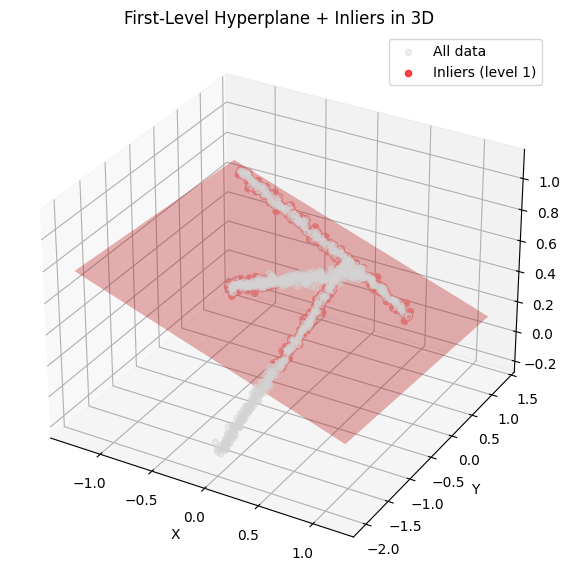

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib import cm

# ------------------------------------------------------------------------
# 1) RANSAC-based detection of multiple hyperplanes
# ------------------------------------------------------------------------
def find_multiple_hyperplanes_ransac(
    points,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01
):
    """
    Finds multiple hyperplanes in 'points' (NxD) via repeated RANSAC.
    Returns:
      - hyperplanes: list of (coef, intercept, n_inliers, total_error_for_inliers)
      - total_error: float
      - assigned_points: list of arrays, where assigned_points[i] = all points belonging to hyperplane i
    """
    residual_threshold *= (points.shape[1] - 1)

    def fit_hyperplane_ransac(sub_points):
        n_dims = sub_points.shape[1]
        # Randomly choose which dimension is "dependent"
        dependent_dim = np.random.randint(n_dims)
        X = np.delete(sub_points, dependent_dim, axis=1)
        y = sub_points[:, dependent_dim]

        ransac = RANSACRegressor(
            estimator=LinearRegression(),  # Updated parameter name
            max_trials=1000,
            min_samples=n_dims,
            residual_threshold=residual_threshold,
            stop_probability=0.99
        )
        ransac.fit(X, y)
        return ransac, dependent_dim

    def get_hyperplane_eq(ransac, dependent_dim, n_dims):
        """
        Construct the "normal vector" (coef) and intercept
        from the RANSAC fit, so that coef . x + intercept = 0.
        The 'dependent_dim' is set to -1 in the full_coef to place
        that dimension in the normal.
        """
        coef = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_

        full_coef = np.zeros(n_dims)
        full_coef[:dependent_dim] = coef[:dependent_dim]
        full_coef[dependent_dim+1:] = coef[dependent_dim:]
        # the dimension chosen as 'dependent_dim' has the coefficient -1
        full_coef[dependent_dim] = -1
        return full_coef, intercept

    def point_to_hyperplane_distance(pt, cf, itcpt):
        return np.abs(np.dot(cf, pt) + itcpt) / np.linalg.norm(cf)

    def hyperplane_distance(cf1, it1, cf2, it2):
        """Angle and distance between two hyperplanes."""
        cos_angle = np.dot(cf1, cf2) / (np.linalg.norm(cf1) * np.linalg.norm(cf2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        d = np.abs(it1 - it2) / np.linalg.norm(cf1)
        return angle, d

    n_dims = points.shape[1]
    hyperplanes = []
    assigned_points = []
    total_error = 0

    remaining_points = points.copy()

    # --- Repeatedly find hyperplanes ---
    for _ in range(max_hyperplanes):
        if len(remaining_points) < min_points_for_hyperplane:
            break

        try:
            ransac, dep_dim = fit_hyperplane_ransac(remaining_points)
        except Exception as e:
            print(f"RANSAC failed: {e}")
            break

        cf, itcpt = get_hyperplane_eq(ransac, dep_dim, n_dims)
        inlier_mask = ransac.inlier_mask_
        inlier_pts = remaining_points[inlier_mask]
        if len(inlier_pts) == 0:
            break

        # Calculate error
        hyperplane_err = sum(point_to_hyperplane_distance(p, cf, itcpt) for p in inlier_pts)
        total_error += hyperplane_err

        # Save results
        hyperplanes.append((cf, itcpt, len(inlier_pts), hyperplane_err))
        assigned_points.append(inlier_pts)

        # Remove inliers
        remaining_points = remaining_points[~inlier_mask]

    if len(hyperplanes) == 0:
        return [], 0, []

    # Assign leftover points to nearest hyperplane
    for pt in remaining_points:
        dists = [point_to_hyperplane_distance(pt, h[0], h[1]) for h in hyperplanes]
        idx_min = np.argmin(dists)
        total_error += dists[idx_min]
        assigned_points[idx_min] = np.vstack([assigned_points[idx_min], pt])

    # Merge hyperplanes if angle < merge_threshold
    i = 0
    while i < len(hyperplanes):
        j = i + 1
        while j < len(hyperplanes):
            angle, dist = hyperplane_distance(
                hyperplanes[i][0], hyperplanes[i][1],
                hyperplanes[j][0], hyperplanes[j][1]
            )
            if angle < merge_threshold:
                # Merge them
                new_coef = (hyperplanes[i][0] + hyperplanes[j][0]) / 2
                new_itcpt = (hyperplanes[i][1] + hyperplanes[j][1]) / 2
                new_inliers = hyperplanes[i][2] + hyperplanes[j][2]
                new_error = hyperplanes[i][3] + hyperplanes[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])

                hyperplanes[i] = (new_coef, new_itcpt, new_inliers, new_error)
                assigned_points[i] = new_points

                del hyperplanes[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # Sort by descending # inliers
    hyperplanes, assigned_points = zip(
        *sorted(zip(hyperplanes, assigned_points), key=lambda x: x[0][2], reverse=True)
    )
    return list(hyperplanes), total_error, list(assigned_points)


# ------------------------------------------------------------------------
# 2) Rotating Data to Eliminate One Dimension
# ------------------------------------------------------------------------
def rotate_data_and_drop_dimension(points, coef):
    """
    Rotate 'points' so that 'coef' (the hyperplane normal) becomes the
    LAST basis vector, and then drop that last dimension.

    Steps:
      1. Normalize 'coef' -> w
      2. Construct orthonormal basis Q = [v1, v2, ..., v_{D-1}, w]
         so that w is the last column.
      3. Compute points_rot = points * Q  (shape: NxD)
      4. Return points_rot[:, :D-1], i.e. drop the last dimension
         which corresponds to 'w'.

    This effectively removes the dimension spanned by 'coef'.
    """
    D = points.shape[1]
    w = coef / np.linalg.norm(coef)

    # We can use SVD or a Gram-Schmidt procedure to build an orthonormal basis
    # for R^D whose last vector is w.
    # Quick approach:
    #   - Start with an identity matrix I_D
    #   - Ensure the last row of I_D is replaced by w, then orthonormalize columns
    # Or do it more systematically with a method that ensures w is included.

    # Method: create a matrix M of shape (D, 1) with w
    # Perform SVD or QR on that matrix to find orth that includes w
    # But simpler is to do a "span(w)" + "span(...) = R^D".
    #
    # We'll do a partial approach:
    #  - Put w as the last row of a D x D matrix
    #  - fill the rest with random vectors, orthonormalize
    # or use Householder reflection. But let's do a straightforward approach with SVD:

    # We'll create a matrix 'A' = [w; some random vectors], shape (k, D).
    # Then do a full SVD or QR. We'll keep the top D vectors.
    # Actually, let's do a simpler approach:
    #   1) Use np.eye(D) => shape (D,D).
    #   2) Replace the last row with w
    #   3) Orthonormalize columns of that new matrix => Q.

    # Step 1: create a matrix with eye
    M = np.eye(D)
    # We want w as the last row or last column? We want w to be the last column.
    # So let's put w as the last column:
    M[:, -1] = w  # shape (D, D), last column = w

    # Step 2: Orthonormalize the columns of M => Q
    # We'll do QR decomposition
    Q, _ = np.linalg.qr(M)  # Q is D x D orthonormal

    # Now the last column of Q might not be exactly w, but it will be collinear.
    # Because w was in the last column, after QR, we get a valid orthonormal basis.
    # We can check the orientation if we want a specific sign, but typically it's fine.

    # Rotate data
    points_rot = points @ Q  # shape (N, D)

    # Return dropping the last dimension
    # The last dimension is the "direction" of w
    # So we keep the first D-1 columns => shape (N, D-1)
    return points_rot[:, :D-1]


# ------------------------------------------------------------------------
# 3) Hierarchical procedure: now uses rotation for dimension reduction
# ------------------------------------------------------------------------
def hierarchical_spike_detection_nd(
    points,
    min_dim=1,
    max_recursion_depth=None,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01,
    recursion_level=0
):
    """
    Hierarchically peel off one dimension at a time by:
      1) Finding the best hyperplane in the current dimension (with RANSAC).
      2) 'Rotate' the data so that the hyperplane normal becomes the last dimension
         and then drop that dimension => reduces dimension by 1.
      3) Recurse until dimension == min_dim or no further hyperplane found.

    Returns a list of dicts, each describing one step's hyperplane + data:
      [ 
        {
          'dimension': D, 
          'coef': best_coef,
          'intercept': best_intercept,
          'n_inliers': n_inliers,
          'inlier_points_original_dim': best_inlier_points (N_k x D),
          'rotated_points_(D-1)': new_points_after_rotation (N_k x (D-1))
        },
        ...
      ]
    """
    D = points.shape[1]
    if max_recursion_depth is not None and recursion_level >= max_recursion_depth:
        # Reached recursion limit
        return []
    if D <= min_dim:
        # Already at or below desired dimension
        return []
    if len(points) < min_points_for_hyperplane:
        # Not enough points to meaningfully do RANSAC
        return []
    
    # 1) Detect hyperplanes in the current dimension
    hyperplanes, total_error, assigned_sets = find_multiple_hyperplanes_ransac(
        points,
        max_hyperplanes=max_hyperplanes,
        min_points_for_hyperplane=min_points_for_hyperplane,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold
    )
    if not hyperplanes:
        # Could not find any hyperplane
        return []

    # 2) Select the "best" hyperplane (the first one, since sorted by # inliers)
    best_coef, best_intercept, n_inliers, best_err = hyperplanes[0]
    best_inlier_points = assigned_sets[0]  # shape NxD

    # 3) Rotate data so that 'best_coef' is the last dimension, then drop it
    #    => shape Nx(D-1)
    rotated_points = rotate_data_and_drop_dimension(best_inlier_points, best_coef)

    # 4) Recursively detect next hyperplane in the new (D-1) space
    next_steps = hierarchical_spike_detection_nd(
        rotated_points,
        min_dim=min_dim,
        max_recursion_depth=max_recursion_depth,
        max_hyperplanes=max_hyperplanes,
        min_points_for_hyperplane=min_points_for_hyperplane,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold,
        recursion_level=recursion_level + 1
    )

    this_level_info = {
        "dimension": D,
        "coef": best_coef,
        "intercept": best_intercept,
        "n_inliers": n_inliers,
        "inlier_points_original_dim": best_inlier_points,
        "rotated_points_(D-1)": rotated_points
    }

    return [this_level_info] + next_steps


# ------------------------------------------------------------------------
# 4) Example data generation & visualizations
# ------------------------------------------------------------------------
def generate_3d_lines(n_lines=3, points_per_line=300, noise=0.02, random_state=42):
    """
    Generate 3D data points lying near multiple lines.
    Each line is defined by a random point and direction.
    """
    np.random.seed(random_state)
    data = []
    for _ in range(n_lines):
        point = np.random.uniform(-1, 1, size=3)
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)

        t = np.linspace(-1, 1, points_per_line)
        line_points = point + np.outer(t, direction)

        # Add Gaussian noise
        line_points += np.random.normal(scale=noise, size=line_points.shape)
        data.append(line_points)

    data = np.vstack(data)
    return data


# ------------------------------------------------------------------------
# 5) Visualization Helpers
# ------------------------------------------------------------------------
def plot_hyperplanes_3d(ax, coef, intercept, xlim, ylim, color='r', alpha=0.3):
    """
    Plot a hyperplane in 3D defined by coef . x + intercept = 0
    """
    if coef[2] != 0:
        xx, yy = np.meshgrid(
            np.linspace(xlim[0], xlim[1], 10),
            np.linspace(ylim[0], ylim[1], 10)
        )
        zz = (-coef[0]*xx - coef[1]*yy - intercept) / coef[2]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[1] != 0:
        xx, zz = np.meshgrid(
            np.linspace(xlim[0], xlim[1], 10),
            np.linspace(-1, 1, 10)
        )
        yy = (-coef[0]*xx - coef[2]*zz - intercept) / coef[1]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[0] != 0:
        yy, zz = np.meshgrid(
            np.linspace(-1, 1, 10),
            np.linspace(-1, 1, 10)
        )
        xx = (-coef[1]*yy - coef[2]*zz - intercept) / coef[0]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)


def visualize_hierarchical_results(data, results):
    """
    Visualize only the 3D part (the original data and the best hyperplane).
    This won't show lines in the reduced subspace, but it at least
    shows the plane in 3D with inliers for level 1.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],
               color='lightgray', alpha=0.4, label='All data')

    if len(results) > 0:
        # Only the first level is guaranteed to be 3D
        best_level = results[0]
        inliers_3d = best_level['inlier_points_original_dim']
        coef = best_level['coef']
        intercept = best_level['intercept']

        ax.scatter(inliers_3d[:, 0],
                   inliers_3d[:, 1],
                   inliers_3d[:, 2],
                   color='red', alpha=0.7, label='Inliers (level 1)')

        # Plot the plane
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plot_hyperplanes_3d(ax, coef, intercept, xlim, ylim, color='red', alpha=0.3)

    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('First-Level Hyperplane + Inliers in 3D')
    plt.show()


# ------------------------------------------------------------------------
# 6) Putting It All Together
# ------------------------------------------------------------------------

# Generate 3 lines in 3D
data = generate_3d_lines(n_lines=3, points_per_line=300, noise=0.02)

# Run hierarchical spike detection with rotation
results = hierarchical_spike_detection_nd(
    data,
    min_dim=1,
    max_recursion_depth=4,
    max_hyperplanes=5,
    min_points_for_hyperplane=100,
    residual_threshold=0.1,
    merge_threshold=0.01
)

print(f"Detected {len(results)} hierarchical levels.")
for i, level in enumerate(results):
    print(f"Level {i+1} => dimension was {level['dimension']}")
    print(f"   # inliers: {level['n_inliers']}")
    print(f"   shape of rotated data: {level['rotated_points_(D-1)'].shape}")
    print("   coef (normal):", level['coef'])
    print()

# Visualize only the first-level plane in 3D
visualize_hierarchical_results(data, results)


Level 1, Hyperplane 1:
  Dimension: 3
  Number of inliers: 829
  Hyperplane normal vector: [ 0.3954083   0.18680714 -1.        ]
  Hyperplane intercept: 0.5790439055737808

Level 2, Hyperplane 1:
  Dimension: 2
  Number of inliers: 502
  Hyperplane normal vector: [-1.          0.11980738]
  Hyperplane intercept: 0.30891048150710476

Level 2, Hyperplane 2:
  Dimension: 2
  Number of inliers: 210
  Hyperplane normal vector: [-1.         -0.61341069]
  Hyperplane intercept: 0.060026010813977536

Level 2, Hyperplane 3:
  Dimension: 2
  Number of inliers: 100
  Hyperplane normal vector: [-0.57918464 -1.        ]
  Hyperplane intercept: -0.7684511100017786


Detected 1 hierarchical levels (planes).
Level 1, Hyperplane 1:
  Dimension: 3
  Number of inliers: 829
  Hyperplane normal vector: [ 0.3954083   0.18680714 -1.        ]
  Hyperplane intercept: 0.5790439055737808
  Shape of rotated data: (900, 2)

  Level 2, Hyperplane 1:
    Dimension: 2
    Number of inliers: 502
    Hyperplane normal 

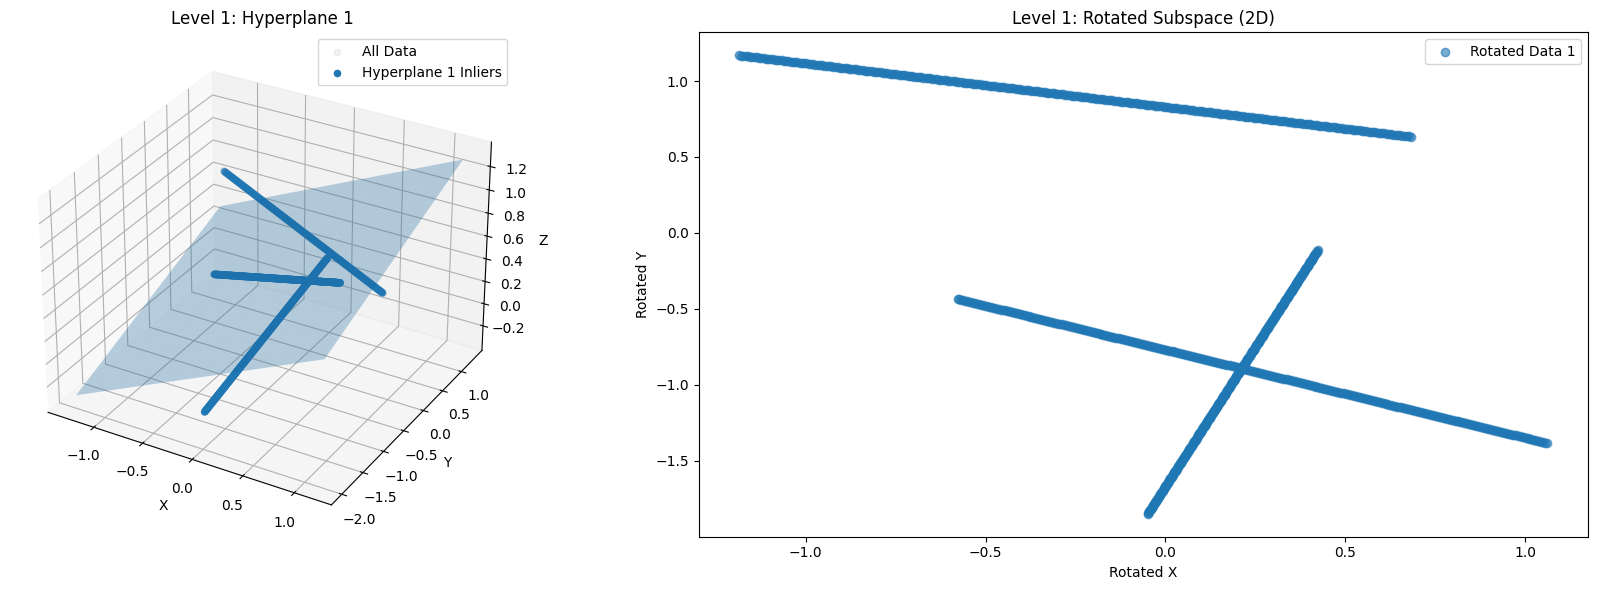

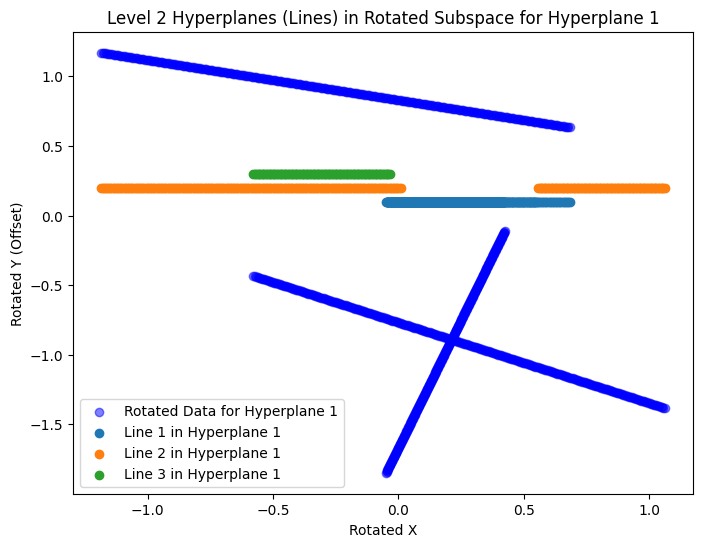

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib import cm
import matplotlib.colors as mcolors

# ------------------------------------------------------------------------
# 1) RANSAC-based Detection of Multiple Hyperplanes
# ------------------------------------------------------------------------
def find_multiple_hyperplanes_ransac(
    points,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01
):
    """
    Finds multiple hyperplanes in 'points' (NxD) via repeated RANSAC.
    Returns:
      - hyperplanes: list of (coef, intercept, n_inliers, total_error_for_inliers)
      - total_error: float
      - assigned_points: list of arrays, where assigned_points[i] = all points belonging to hyperplane i
    """
    residual_threshold *= (points.shape[1] - 1)

    def fit_hyperplane_ransac(sub_points):
        n_dims = sub_points.shape[1]
        # Randomly choose which dimension is "dependent"
        dependent_dim = np.random.randint(n_dims)
        X = np.delete(sub_points, dependent_dim, axis=1)
        y = sub_points[:, dependent_dim]

        ransac = RANSACRegressor(
            estimator=LinearRegression(),
            max_trials=1000,
            min_samples=n_dims,
            residual_threshold=residual_threshold,
            stop_probability=0.99
        )
        ransac.fit(X, y)
        return ransac, dependent_dim

    def get_hyperplane_eq(ransac, dependent_dim, n_dims):
        """
        Construct the "normal vector" (coef) and intercept
        from the RANSAC fit, so that coef . x + intercept = 0.
        The 'dependent_dim' is set to -1 in the full_coef to place
        that dimension in the normal.
        """
        coef = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_

        full_coef = np.zeros(n_dims)
        full_coef[:dependent_dim] = coef[:dependent_dim]
        full_coef[dependent_dim+1:] = coef[dependent_dim:]
        # the dimension chosen as 'dependent_dim' has the coefficient -1
        full_coef[dependent_dim] = -1
        return full_coef, intercept

    def point_to_hyperplane_distance(pt, cf, itcpt):
        return np.abs(np.dot(cf, pt) + itcpt) / np.linalg.norm(cf)

    def hyperplane_distance(cf1, it1, cf2, it2):
        """Angle and distance between two hyperplanes."""
        cos_angle = np.dot(cf1, cf2) / (np.linalg.norm(cf1) * np.linalg.norm(cf2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        d = np.abs(it1 - it2) / np.linalg.norm(cf1)
        return angle, d

    n_dims = points.shape[1]
    hyperplanes = []
    assigned_points = []
    total_error = 0

    remaining_points = points.copy()

    # --- Repeatedly find hyperplanes ---
    for _ in range(max_hyperplanes):
        if len(remaining_points) < min_points_for_hyperplane:
            break

        try:
            ransac, dep_dim = fit_hyperplane_ransac(remaining_points)
        except Exception as e:
            print(f"RANSAC failed: {e}")
            break

        cf, itcpt = get_hyperplane_eq(ransac, dep_dim, n_dims)
        inlier_mask = ransac.inlier_mask_
        inlier_pts = remaining_points[inlier_mask]
        if len(inlier_pts) == 0:
            break

        # Calculate error
        hyperplane_err = sum(point_to_hyperplane_distance(p, cf, itcpt) for p in inlier_pts)
        total_error += hyperplane_err

        # Save results
        hyperplanes.append((cf, itcpt, len(inlier_pts), hyperplane_err))
        assigned_points.append(inlier_pts)

        # Remove inliers
        remaining_points = remaining_points[~inlier_mask]

    if len(hyperplanes) == 0:
        return [], 0, []

    # Assign leftover points to nearest hyperplane
    for pt in remaining_points:
        dists = [point_to_hyperplane_distance(pt, h[0], h[1]) for h in hyperplanes]
        idx_min = np.argmin(dists)
        total_error += dists[idx_min]
        assigned_points[idx_min] = np.vstack([assigned_points[idx_min], pt])

    # Merge hyperplanes if angle < merge_threshold
    i = 0
    while i < len(hyperplanes):
        j = i + 1
        while j < len(hyperplanes):
            angle, dist = hyperplane_distance(
                hyperplanes[i][0], hyperplanes[i][1],
                hyperplanes[j][0], hyperplanes[j][1]
            )
            if angle < merge_threshold:
                # Merge them
                new_coef = (hyperplanes[i][0] + hyperplanes[j][0]) / 2
                new_itcpt = (hyperplanes[i][1] + hyperplanes[j][1]) / 2
                new_inliers = hyperplanes[i][2] + hyperplanes[j][2]
                new_error = hyperplanes[i][3] + hyperplanes[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])

                hyperplanes[i] = (new_coef, new_itcpt, new_inliers, new_error)
                assigned_points[i] = new_points

                del hyperplanes[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # Sort by descending # inliers
    hyperplanes, assigned_points = zip(
        *sorted(zip(hyperplanes, assigned_points), key=lambda x: x[0][2], reverse=True)
    )
    return list(hyperplanes), total_error, list(assigned_points)


# ------------------------------------------------------------------------
# 2) Rotating Data to Eliminate One Dimension
# ------------------------------------------------------------------------
def rotate_data_and_drop_dimension(points, coef):
    """
    Rotate 'points' so that 'coef' (the hyperplane normal) becomes the
    LAST basis vector, and then drop that last dimension.

    Steps:
      1. Normalize 'coef' -> w
      2. Construct orthonormal basis Q = [v1, v2, ..., v_{D-1}, w]
         so that w is the last column.
      3. Compute points_rot = points * Q  (shape: NxD)
      4. Return points_rot[:, :D-1], i.e. drop the last dimension
         which corresponds to 'w'.

    This effectively removes the dimension spanned by 'coef'.
    """
    D = points.shape[1]
    w = coef / np.linalg.norm(coef)

    # Create an orthonormal matrix Q where the last column is w
    # Start with w as the last column
    Q = np.eye(D)
    Q[:, -1] = w

    # Orthonormalize the matrix using QR decomposition
    Q, _ = np.linalg.qr(Q)

    # Rotate data
    points_rot = points @ Q

    # Return dropping the last dimension
    return points_rot[:, :D-1]


# ------------------------------------------------------------------------
# 3) Hierarchical Procedure: Processing All Hyperplanes
# ------------------------------------------------------------------------
def hierarchical_spike_detection_nd(
    points,
    min_dim=1,
    max_recursion_depth=None,
    max_hyperplanes=30,
    min_points_for_hyperplane=100,
    residual_threshold=0.5,
    merge_threshold=0.01,
    recursion_level=0
):
    """
    Hierarchically peel off one dimension at a time by:
      1) Finding all hyperplanes in the current dimension (with RANSAC).
      2) For each hyperplane:
         a. Rotate the data so that the hyperplane normal becomes the last dimension.
         b. Drop the last dimension to reduce dimensionality by 1.
         c. Recursively search for lines within the rotated subspace.
    3) Aggregate all results.

    Returns a list of dicts, each describing one hyperplane and its sub-results:
      [ 
        {
          'dimension': D, 
          'coef': best_coef,
          'intercept': best_intercept,
          'n_inliers': n_inliers,
          'inlier_points_original_dim': best_inlier_points (N_k x D),
          'rotated_points_(D-1)': new_points_after_rotation (N_k x (D-1)),
          'children': [ ... ]  # Recursive sub-results
        },
        ...
      ]
    """
    D = points.shape[1]
    if max_recursion_depth is not None and recursion_level >= max_recursion_depth:
        # Reached recursion limit
        return []
    if D <= min_dim:
        # Already at or below desired dimension
        return []
    if len(points) < min_points_for_hyperplane:
        # Not enough points to meaningfully do RANSAC
        return []

    # 1) Detect all hyperplanes in the current dimension
    hyperplanes, total_error, assigned_sets = find_multiple_hyperplanes_ransac(
        points,
        max_hyperplanes=max_hyperplanes,
        min_points_for_hyperplane=min_points_for_hyperplane,
        residual_threshold=residual_threshold,
        merge_threshold=merge_threshold
    )
    if not hyperplanes:
        # Could not find any hyperplane
        return []

    results = []
    # 2) Iterate over all detected hyperplanes
    for idx, (best_coef, best_intercept, n_inliers, best_err) in enumerate(hyperplanes):
        best_inlier_points = assigned_sets[idx]  # shape NxD

        # Log details
        print(f"Level {recursion_level + 1}, Hyperplane {idx + 1}:")
        print(f"  Dimension: {D}")
        print(f"  Number of inliers: {n_inliers}")
        print(f"  Hyperplane normal vector: {best_coef}")
        print(f"  Hyperplane intercept: {best_intercept}\n")

        # 3) Rotate data so that 'best_coef' is the last dimension, then drop it
        #    => shape Nx(D-1)
        rotated_points = rotate_data_and_drop_dimension(best_inlier_points, best_coef)

        # 4) Recursively detect next hyperplanes in the new (D-1) space
        children = hierarchical_spike_detection_nd(
            rotated_points,
            min_dim=min_dim,
            max_recursion_depth=max_recursion_depth,
            max_hyperplanes=max_hyperplanes,
            min_points_for_hyperplane=min_points_for_hyperplane,
            residual_threshold=residual_threshold,
            merge_threshold=merge_threshold,
            recursion_level=recursion_level + 1
        )

        # 5) Build the info for the current hyperplane
        this_level_info = {
            "dimension": D,
            "coef": best_coef,
            "intercept": best_intercept,
            "n_inliers": n_inliers,
            "inlier_points_original_dim": best_inlier_points,      # shape NxD
            "rotated_points_(D-1)": rotated_points,                # shape Nx(D-1)
            "children": children                                    # Recursive sub-results
        }

        results.append(this_level_info)

    return results


# ------------------------------------------------------------------------
# 4) Example Data Generation & Visualization Helpers
# ------------------------------------------------------------------------
def generate_3d_lines(n_lines=3, points_per_line=300, noise=0.02, random_state=42):
    """
    Generate 3D data points lying near multiple lines.
    Each line is defined by a random point and direction.
    """
    np.random.seed(random_state)
    data = []
    for _ in range(n_lines):
        point = np.random.uniform(-1, 1, size=3)
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)

        t = np.linspace(-1, 1, points_per_line)
        line_points = point + np.outer(t, direction)

        # Add Gaussian noise
        line_points += np.random.normal(scale=noise, size=line_points.shape)
        data.append(line_points)

    data = np.vstack(data)
    return data


def plot_hyperplanes_3d(ax, coef, intercept, xlim, ylim, color='r', alpha=0.3):
    """
    Plot a hyperplane in 3D defined by coef . x + intercept = 0
    """
    if coef[2] != 0:
        xx, yy = np.meshgrid(
            np.linspace(xlim[0], xlim[1], 10),
            np.linspace(ylim[0], ylim[1], 10)
        )
        zz = (-coef[0]*xx - coef[1]*yy - intercept) / coef[2]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[1] != 0:
        # Solve for y
        xx, zz = np.meshgrid(
            np.linspace(xlim[0], xlim[1], 10),
            np.linspace(-1, 1, 10)
        )
        yy = (-coef[0]*xx - coef[2]*zz - intercept) / coef[1]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)
    elif coef[0] != 0:
        # Solve for x
        yy, zz = np.meshgrid(
            np.linspace(-1, 1, 10),
            np.linspace(-1, 1, 10)
        )
        xx = (-coef[1]*yy - coef[2]*zz - intercept) / coef[0]
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha)


def get_unique_colors(n):
    """
    Generate 'n' distinct colors.
    """
    colors = list(mcolors.TABLEAU_COLORS.values())
    if n <= len(colors):
        return colors[:n]
    else:
        # If more colors are needed, use a colormap
        cmap = cm.get_cmap('hsv', n)
        return [cmap(i) for i in range(n)]


# ------------------------------------------------------------------------
# 5) Enhanced Visualization Function
# ------------------------------------------------------------------------
def visualize_hierarchical_results(data, results):
    """
    Visualize all hierarchical levels with unique colors for each hyperplane and line.

    This function recursively traverses the hierarchical results and plots each hyperplane
    and its corresponding lines or points in their respective subspaces.
    """
    fig = plt.figure(figsize=(18, 6 * len(results)))
    
    # Assign unique colors for top-level hyperplanes
    top_level_colors = get_unique_colors(len(results))
    
    # Recursive function to plot hyperplanes and their children
    def plot_recursive(result, color, depth=1):
        D = result['dimension']
        coef = result['coef']
        intercept = result['intercept']
        inliers = result['inlier_points_original_dim']
        rotated = result['rotated_points_(D-1)']
        children = result['children']
        
        if D == 3:
            # 3D Plot
            ax = fig.add_subplot(len(results), 2, 2*(depth-1) + 1, projection='3d')
            ax.scatter(data[:,0], data[:,1], data[:,2], color='lightgray', label='All Data', alpha=0.3)
            ax.scatter(inliers[:,0], inliers[:,1], inliers[:,2], color=color, label=f'Hyperplane {depth} Inliers')
            plot_hyperplanes_3d(ax, coef, intercept, ax.get_xlim(), ax.get_ylim(), color=color, alpha=0.3)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f'Level {depth}: Hyperplane {depth}')
            ax.legend()
            
            # Rotated Subspace Plot
            ax2 = fig.add_subplot(len(results), 2, 2*(depth-1) + 2)
            if rotated.shape[1] == 2:
                ax2.scatter(rotated[:,0], rotated[:,1], color=color, alpha=0.6, label=f'Rotated Data {depth}')
                ax2.set_xlabel('Rotated X')
                ax2.set_ylabel('Rotated Y')
                ax2.set_title(f'Level {depth}: Rotated Subspace (2D)')
                ax2.legend()
            elif rotated.shape[1] ==1:
                ax2.scatter(rotated[:,0], np.zeros_like(rotated[:,0]), color=color, alpha=0.6, label=f'Rotated Data {depth}')
                ax2.set_xlabel('Rotated X')
                ax2.set_yticks([])
                ax2.set_title(f'Level {depth}: Rotated Subspace (1D)')
                ax2.legend()
            else:
                ax2.axis('off')
            # Recursively plot children
            for child in children:
                plot_recursive(child, color, depth +1)
            
        elif D == 2:
            print(rotated.shape)
            # 2D Plot
            # ax = fig.add_subplot(len(results), 2, 2*(depth-1) + 1)
            # # ax.scatter(rotated[:,0], color=color, label=f'Hyperplane {depth} Inliers')
            # # Fit a line for visualization
            # if len(rotated) >= 2:
            #     A = np.vstack([rotated[:,0], np.ones(len(rotated))]).T
            #     m, c = np.linalg.lstsq(A, rotated[:,1], rcond=None)[0]
            #     x = np.linspace(rotated[:,0].min(), rotated[:,0].max(), 100)
            #     y = m*x + c
            #     ax.plot(x, y, 'k-', label='Detected Line')
            # ax.set_xlabel('Rotated X')
            # ax.set_ylabel('Rotated Y')
            # ax.set_title(f'Level {depth}: Hyperplane {depth}')
            # ax.legend()
            
            # # Rotated Subspace Plot
            # ax2 = fig.add_subplot(len(results), 2, 2*(depth-1) + 2)
            # if rotated.shape[1] ==1:
            #     ax2.scatter(rotated[:,0], np.zeros_like(rotated[:,0]), color=color, alpha=0.6, label=f'Rotated Data {depth}')
            #     ax2.set_xlabel('Rotated X')
            #     ax2.set_yticks([])
            #     ax2.set_title(f'Level {depth}: Rotated Subspace (1D)')
            #     ax2.legend()
            # else:
            #     ax2.axis('off')
            
        elif D ==1:
            # 1D Plot
            ax = fig.add_subplot(len(results), 2, 2*(depth-1) + 1)
            ax.scatter(rotated[:,0], np.zeros_like(rotated[:,0]), color=color, label=f'Hyperplane {depth} Inliers')
            ax.set_xlabel('Rotated X')
            ax.set_title(f'Level {depth}: Hyperplane {depth}')
            ax.legend()
            
            # No further rotation
            ax2 = fig.add_subplot(len(results), 2, 2*(depth-1) + 2)
            ax2.axis('off')
        
        else:
            print(f"Unsupported dimensionality for Level {depth}: {D}")
    
    # Iterate over all top-level hyperplanes
    for idx, hyperplane in enumerate(results):
        plot_recursive(hyperplane, top_level_colors[idx], depth=1)
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# 5) Dedicated Function to Plot Level 2 Hyperplanes (Lines)
# ------------------------------------------------------------------------
def plot_level2_hyperplanes(results):
    """
    Plot the level 2 detected hyperplanes (lines) within each rotated subspace.

    Args:
        results: hierarchical results from the detection algorithm.
    """
    for top_idx, top_hyperplane in enumerate(results, start=1):
        rotated = top_hyperplane['rotated_points_(D-1)']
        children = top_hyperplane['children']
        
        if rotated.shape[1] != 2:
            print(f"Skipping Level 2 plotting for Hyperplane {top_idx} as rotated data is not 2D.")
            continue
        
        plt.figure(figsize=(8,6))
        plt.scatter(rotated[:,0], rotated[:,1], color='b', alpha=0.5, label=f'Rotated Data for Hyperplane {top_idx}')
        
        # Assign unique colors for lines within the plane
        line_colors = get_unique_colors(len(children))
        
        for line_idx, child in enumerate(children, start=1):
            if child['dimension'] != 2:
                print(f"Skipping Line {line_idx} in Hyperplane {top_idx} as it is not in 2D.")
                continue
            inliers_rotated = child['rotated_points_(D-1)']
            if inliers_rotated.shape[1] != 1:
                print(f"Unexpected dimensionality for Line {line_idx} in Hyperplane {top_idx}.")
                continue
            
            # Since the data is 1D, fit a line in 2D space
            # We need to reconstruct 2D points; however, the data has been reduced to 1D
            # To visualize, we can plot them along one axis with some spread on the other
            # Alternatively, if we have the coefficients, we can plot the fitted line
            # Assuming each child represents a line, we can fit a line to the inliers in the rotated space
            # Here, we can re-fit using least squares
            # But since rotated_points_(D-1) is already 1D, this might represent points along one axis

            # To visualize lines, you may need to store the rotation matrices or additional info
            # For simplicity, we'll assume that each child corresponds to a set of points forming a line along the x-axis in rotated space

            # Alternatively, revisit the detection to ensure lines are detected as lines in 2D
            # Here, we plot them as vertical lines if their y-coordinate is consistent, or horizontal if x is consistent

            # For better visualization, consider storing the rotated coefficients for each child
            # Since this information is not currently stored, we'll make an assumption based on the rotation

            # Plot a vertical line if data is spread along x
            # Or horizontal if spread along y

            # Here, let's fit a line using the rotated data before dropping the dimension
            # However, since rotated_points_(D-1) is 1D, we need to adjust

            # As an alternative, plot the points with some y-value for visibility
            # Note: This is a workaround due to data being 1D

            # Assign a unique y-offset for each line for visualization
            y_offset = line_idx * 0.1
            plt.scatter(child['rotated_points_(D-1)'][:,0], np.full(child['rotated_points_(D-1)'].shape[0], y_offset), color=line_colors[line_idx-1], label=f'Line {line_idx} in Hyperplane {top_idx}')

        plt.xlabel('Rotated X')
        plt.ylabel('Rotated Y (Offset)')
        plt.title(f'Level 2 Hyperplanes (Lines) in Rotated Subspace for Hyperplane {top_idx}')
        plt.legend()
        plt.show()





# ------------------------------------------------------------------------
# 6) Putting It All Together
# ------------------------------------------------------------------------

# Generate 3 lines in 3D
data = generate_3d_lines(n_lines=3, points_per_line=300, noise=0.0)

# Run hierarchical spike detection with rotation
results = hierarchical_spike_detection_nd(
    data,
    min_dim=1,
    max_recursion_depth=4,  # Allow up to 4 recursive calls to detect all hyperplanes
    max_hyperplanes=5,
    min_points_for_hyperplane=100,
    residual_threshold=0.3,  # Adjusted for tighter fitting
    merge_threshold=0.1      # Adjusted to prevent over-merging
)

# Print summary of detected hyperplanes and lines
def print_hierarchical_results(results, depth=1):
    for idx, hyperplane in enumerate(results):
        indent = "  " * (depth - 1)
        print(f"{indent}Level {depth}, Hyperplane {idx + 1}:")
        print(f"{indent}  Dimension: {hyperplane['dimension']}")
        print(f"{indent}  Number of inliers: {hyperplane['n_inliers']}")
        print(f"{indent}  Hyperplane normal vector: {hyperplane['coef']}")
        print(f"{indent}  Hyperplane intercept: {hyperplane['intercept']}")
        print(f"{indent}  Shape of rotated data: {hyperplane['rotated_points_(D-1)'].shape}\n")
        # Recursively print children
        if hyperplane['children']:
            print_hierarchical_results(hyperplane['children'], depth + 1)

print(f"\nDetected {len(results)} hierarchical levels (planes).")
print_hierarchical_results(results)

# Visualize all hierarchical levels with multiple hyperplanes and lines
visualize_hierarchical_results(data, results)

plot_level2_hyperplanes(results)

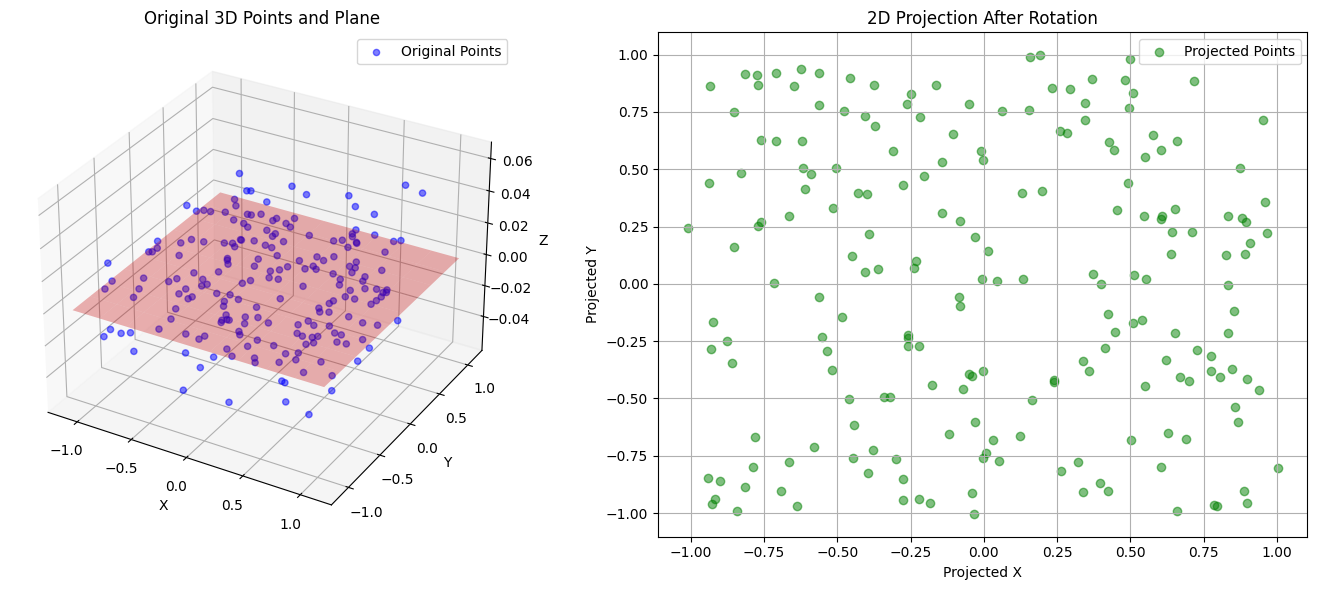

In [48]:
def generate_plane_points(normal_vector, point_on_plane, num_points=100, noise=0.01, random_state=42):
    """
    Generates random points on a plane defined by a normal vector and a point on the plane.
    
    Args:
        normal_vector (array-like): The normal vector of the plane (3 elements).
        point_on_plane (array-like): A point on the plane (3 elements).
        num_points (int): Number of points to generate.
        noise (float): Standard deviation of Gaussian noise to add.
        random_state (int): Seed for reproducibility.
    
    Returns:
        np.ndarray: Array of shape (num_points, 3) containing the points.
    """
    np.random.seed(random_state)
    normal = np.array(normal_vector)
    normal = normal / np.linalg.norm(normal)  # Ensure it's a unit vector
    
    # Find two orthogonal vectors in the plane
    if (normal == np.array([1, 0, 0])).all():
        v1 = np.array([0, 1, 0])
    else:
        v1 = np.cross(normal, [1, 0, 0])
        v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(normal, v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Generate random coefficients for v1 and v2
    coeffs = np.random.uniform(-1, 1, size=(num_points, 2))
    
    # Generate points on the plane
    points = point_on_plane + coeffs[:,0][:, np.newaxis] * v1 + coeffs[:,1][:, np.newaxis] * v2
    
    # Add Gaussian noise
    points += np.random.normal(scale=noise, size=points.shape)
    
    return points


# Define plane parameters
plane_normal = [0, 0, 1]  # Plane parallel to XY-plane
plane_origin = [0, 0, 0]  # Origin lies on the plane

# Generate points
points_3d = generate_plane_points(
    normal_vector=plane_normal,
    point_on_plane=plane_origin,
    num_points=200,
    noise=0.02,
    random_state=42
)


def compute_rotation_matrix(normal_vector):
    """
    Computes the rotation matrix that aligns the given normal vector with the z-axis.
    
    Args:
        normal_vector (array-like): The normal vector to align with the z-axis (3 elements).
    
    Returns:
        np.ndarray: A 3x3 rotation matrix.
    """
    normal = np.array(normal_vector)
    normal = normal / np.linalg.norm(normal)
    
    # Current z-axis
    z_axis = np.array([0, 0, 1])
    
    # If the normal is already aligned with z-axis, no rotation needed
    if np.allclose(normal, z_axis):
        return np.eye(3)
    if np.allclose(normal, -z_axis):
        # 180-degree rotation around x or y axis
        return np.array([[1, 0, 0],
                         [0, -1, 0],
                         [0, 0, -1]])
    
    # Compute the axis of rotation (cross product)
    v = np.cross(normal, z_axis)
    s = np.linalg.norm(v)
    c = np.dot(normal, z_axis)
    
    # Skew-symmetric cross-product matrix of v
    vx = np.array([[    0, -v[2],  v[1]],
                   [ v[2],     0, -v[0]],
                   [-v[1],  v[0],     0]])
    
    # Rodrigues' rotation formula
    R = np.eye(3) + vx + np.matmul(vx, vx) * ((1 - c) / (s**2))
    
    return R



# Compute rotation matrix
R = compute_rotation_matrix(plane_normal)


def rotate_and_project(points, rotation_matrix):
    """
    Rotates the points using the given rotation matrix and projects them onto 2D by dropping the z-axis.
    
    Args:
        points (np.ndarray): Array of shape (N, 3).
        rotation_matrix (np.ndarray): 3x3 rotation matrix.
    
    Returns:
        np.ndarray: Array of shape (N, 2) containing the projected 2D points.
    """
    rotated_points = points @ rotation_matrix.T  # Rotate
    projected_points = rotated_points[:, :2]    # Drop z-axis
    return projected_points


# Rotate and project points
points_2d = rotate_and_project(points_3d, R)


def visualize_rotation_projection(points_3d, points_2d, plane_normal, plane_origin):
    """
    Visualizes the original 3D points and their 2D projection after rotation.
    
    Args:
        points_3d (np.ndarray): Original 3D points (N x 3).
        points_2d (np.ndarray): Projected 2D points (N x 2).
        plane_normal (array-like): Normal vector of the plane.
        plane_origin (array-like): A point on the plane.
    """
    fig = plt.figure(figsize=(14, 6))
    
    # 3D Plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], color='b', alpha=0.5, label='Original Points')
    
    # Plot the plane
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                         np.linspace(ylim[0], ylim[1], 10))
    z = (-plane_normal[0]*xx - plane_normal[1]*yy - 0) / plane_normal[2]
    ax1.plot_surface(xx, yy, z, color='r', alpha=0.3)
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Original 3D Points and Plane')
    ax1.legend()
    
    # 2D Plot
    ax2 = fig.add_subplot(122)
    ax2.scatter(points_2d[:,0], points_2d[:,1], color='g', alpha=0.5, label='Projected Points')
    ax2.set_xlabel('Projected X')
    ax2.set_ylabel('Projected Y')
    ax2.set_title('2D Projection After Rotation')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


# Visualize
visualize_rotation_projection(points_3d, points_2d, plane_normal, plane_origin)



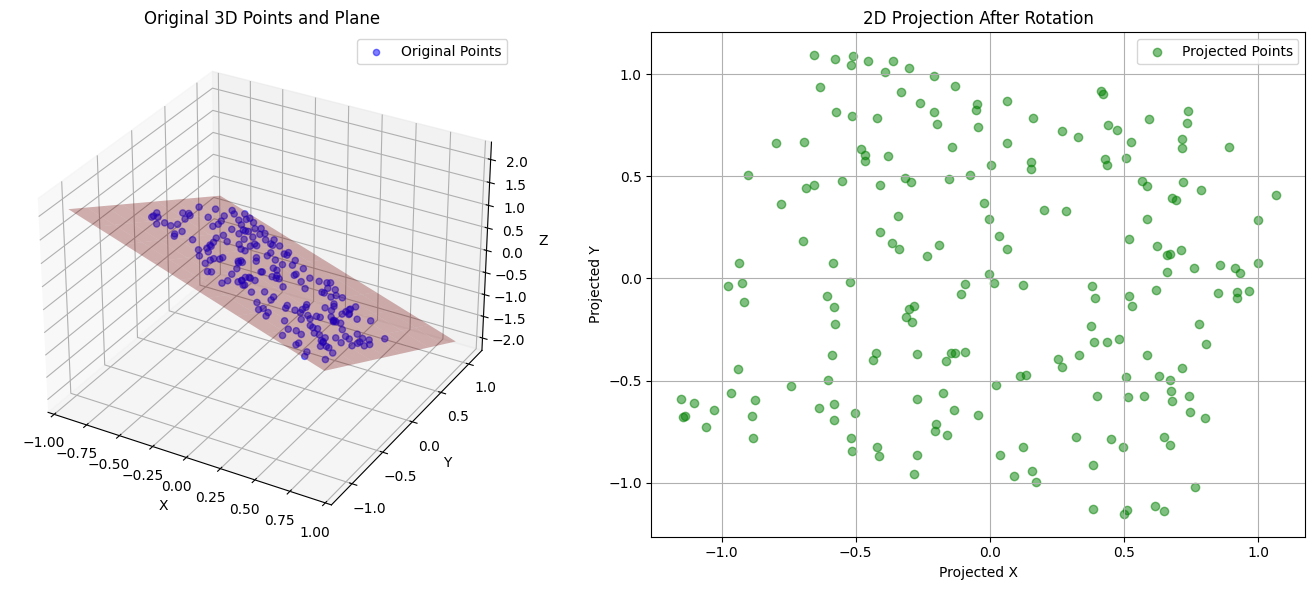

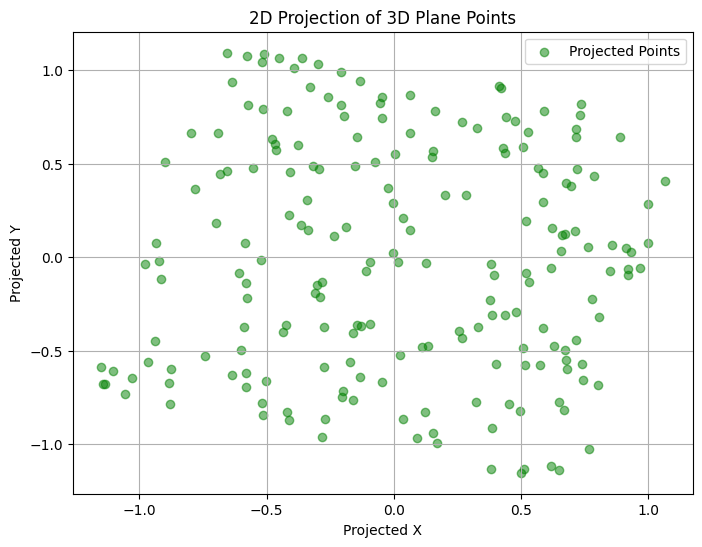

In [49]:
# 1. Define the plane
plane_normal = [1, 1, 1]  # Arbitrary normal vector
plane_normal = np.array(plane_normal)
plane_normal = plane_normal / np.linalg.norm(plane_normal)  # Normalize
plane_origin = [0, 0, 0]  # Origin lies on the plane

# 2. Generate 3D points on the plane
points_3d = generate_plane_points(
    normal_vector=plane_normal,
    point_on_plane=plane_origin,
    num_points=200,
    noise=0.02,
    random_state=42
)

# 3. Compute rotation matrix
R = compute_rotation_matrix(plane_normal)

# 4. Rotate and project points
points_2d = rotate_and_project(points_3d, R)

# 5. Visualize
visualize_rotation_projection(points_3d, points_2d, plane_normal, plane_origin)

# Optional: Scatter plot of 2D points
plt.figure(figsize=(8,6))
plt.scatter(points_2d[:,0], points_2d[:,1], color='g', alpha=0.5, label='Projected Points')
plt.xlabel('Projected X')
plt.ylabel('Projected Y')
plt.title('2D Projection of 3D Plane Points')
plt.legend()
plt.grid(True)
plt.show()

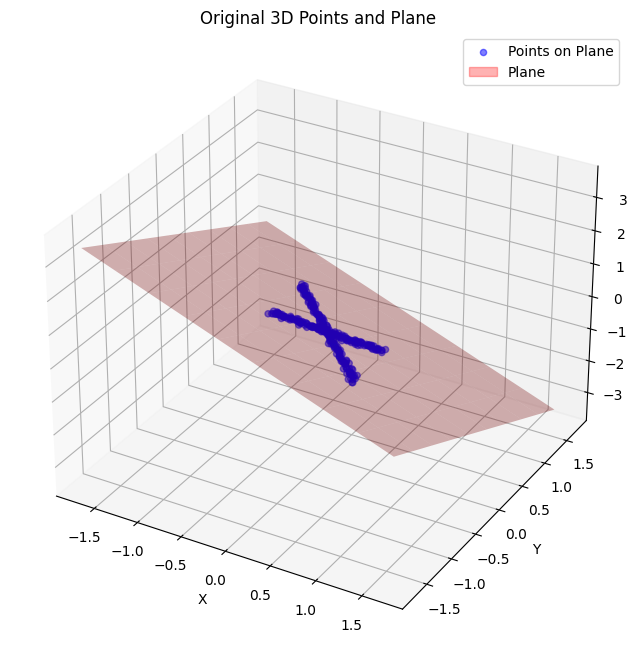

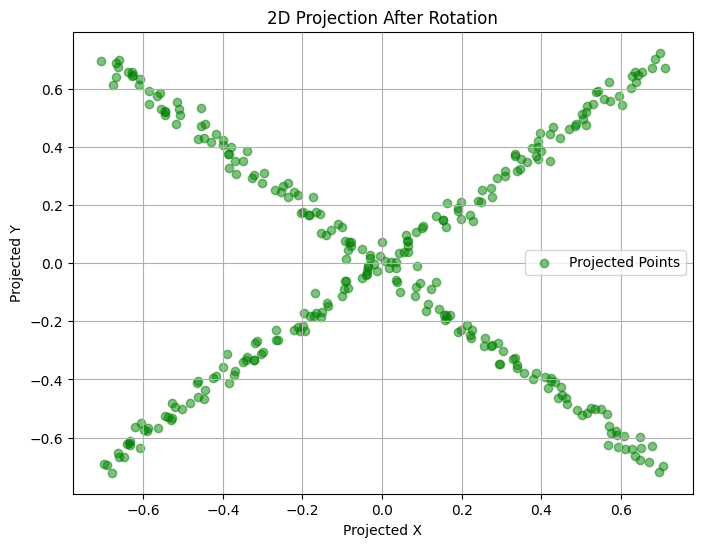

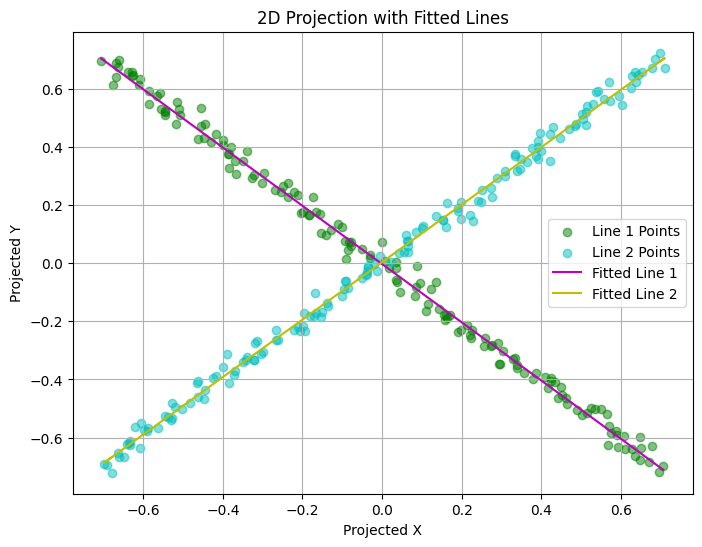

In [52]:
def define_plane_and_lines():
    """
    Defines a plane and two lines within that plane.
    
    Returns:
        plane_normal (np.ndarray): Normal vector of the plane (3,).
        plane_origin (np.ndarray): A point on the plane (3,).
        line1_dir (np.ndarray): Direction vector of Line 1 (3,).
        line2_dir (np.ndarray): Direction vector of Line 2 (3,).
    """
    # Define plane parameters
    plane_normal = np.array([1, 1, 1])  # Arbitrary normal vector
    plane_normal = plane_normal / np.linalg.norm(plane_normal)  # Normalize
    plane_origin = np.array([0, 0, 0])  # Origin lies on the plane
    
    # Define two distinct direction vectors within the plane
    # Ensure they are not parallel
    line1_dir = np.array([1, -1, 0])  # Lies within the plane
    line1_dir = line1_dir / np.linalg.norm(line1_dir)  # Normalize
    
    line2_dir = np.array([1, 1, -2])  # Lies within the plane
    line2_dir = line2_dir / np.linalg.norm(line2_dir)  # Normalize
    
    return plane_normal, plane_origin, line1_dir, line2_dir


def generate_line_points(plane_origin, line_dir, num_points=100, noise=0.02, random_state=None):
    """
    Generates points along a line within a plane with added noise.
    
    Args:
        plane_origin (np.ndarray): A point on the plane (3,).
        line_dir (np.ndarray): Direction vector of the line (3,).
        num_points (int): Number of points to generate.
        noise (float): Standard deviation of Gaussian noise to add.
        random_state (int or None): Seed for reproducibility.
    
    Returns:
        np.ndarray: Array of shape (num_points, 3) containing the points.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    t = np.linspace(-1, 1, num_points)
    points = plane_origin + np.outer(t, line_dir)
    
    # Add Gaussian noise
    points += np.random.normal(scale=noise, size=points.shape)
    
    return points


def compute_rotation_matrix(normal_vector):
    """
    Computes the rotation matrix that aligns the given normal vector with the z-axis.
    
    Args:
        normal_vector (array-like): The normal vector to align with the z-axis (3 elements).
    
    Returns:
        np.ndarray: A 3x3 rotation matrix.
    """
    normal = np.array(normal_vector)
    normal = normal / np.linalg.norm(normal)
    
    # Define the target normal (z-axis)
    z_axis = np.array([0, 0, 1])
    
    # Check if the normal is already aligned with the z-axis
    if np.allclose(normal, z_axis):
        return np.eye(3)
    if np.allclose(normal, -z_axis):
        # 180-degree rotation around x or y axis
        return np.array([[1, 0, 0],
                         [0, -1, 0],
                         [0, 0, -1]])
    
    # Compute the rotation axis (cross product)
    v = np.cross(normal, z_axis)
    s = np.linalg.norm(v)
    c = np.dot(normal, z_axis)
    
    # Skew-symmetric cross-product matrix of v
    vx = np.array([[    0, -v[2],  v[1]],
                   [ v[2],     0, -v[0]],
                   [-v[1],  v[0],     0]])
    
    # Rodrigues' rotation formula
    R = np.eye(3) + vx + np.matmul(vx, vx) * ((1 - c) / (s**2))
    
    return R


def rotate_and_project(points, rotation_matrix):
    """
    Rotates the points using the given rotation matrix and projects them onto 2D by dropping the z-axis.
    
    Args:
        points (np.ndarray): Array of shape (N, 3).
        rotation_matrix (np.ndarray): 3x3 rotation matrix.
    
    Returns:
        np.ndarray: Array of shape (N, 2) containing the projected 2D points.
    """
    rotated_points = points @ rotation_matrix.T  # Rotate
    projected_points = rotated_points[:, :2]    # Drop z-axis
    return projected_points

from matplotlib.patches import Patch

def visualize_3d_plane_and_points(points_3d, plane_normal, plane_origin, title='3D Plane and Points'):
    """
    Visualizes the 3D points and the plane they lie on.
    
    Args:
        points_3d (np.ndarray): Array of shape (N, 3) containing the points.
        plane_normal (np.ndarray): Normal vector of the plane (3,).
        plane_origin (np.ndarray): A point on the plane (3,).
        title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot of points
    scatter = ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], color='b', alpha=0.5, label='Points on Plane')
    
    # Create grid to plot the plane
    d = -plane_origin.dot(plane_normal)
    xx, yy = np.meshgrid(np.linspace(points_3d[:,0].min()-1, points_3d[:,0].max()+1, 10),
                         np.linspace(points_3d[:,1].min()-1, points_3d[:,1].max()+1, 10))
    zz = (-plane_normal[0]*xx - plane_normal[1]*yy - d) / plane_normal[2]
    
    # Plot the plane without label
    plane = ax.plot_surface(xx, yy, zz, color='r', alpha=0.3)
    
    # Create custom legend handle for the plane
    plane_proxy = Patch(facecolor='r', edgecolor='r', alpha=0.3, label='Plane')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Add legend with custom handles
    ax.legend(handles=[scatter, plane_proxy])
    
    plt.show()



def visualize_2d_projection(points_2d, lines_labels=None, title='2D Projection of Plane Points'):
    """
    Visualizes the 2D projected points, optionally labeling lines.
    
    Args:
        points_2d (np.ndarray): Array of shape (N, 2) containing the projected points.
        lines_labels (list of str or None): Labels for different lines. Length should match number of lines.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(points_2d[:,0], points_2d[:,1], color='g', alpha=0.5, label='Projected Points')
    
    if lines_labels is not None:
        for idx, label in enumerate(lines_labels):
            # Assuming lines are distinguishable by color or some other means
            pass  # Placeholder for line-specific plotting if labels are provided
    
    plt.xlabel('Projected X')
    plt.ylabel('Projected Y')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



# 1. Define the plane and two lines within it
plane_normal, plane_origin, line1_dir, line2_dir = define_plane_and_lines()

# 2. Generate 3D points on both lines
points_line1 = generate_line_points(
    plane_origin=plane_origin,
    line_dir=line1_dir,
    num_points=150,
    noise=0.02,
    random_state=42
)

points_line2 = generate_line_points(
    plane_origin=plane_origin,
    line_dir=line2_dir,
    num_points=150,
    noise=0.02,
    random_state=24  # Different seed for diversity
)

# Combine points from both lines
points_3d = np.vstack([points_line1, points_line2])

# 3. Compute the rotation matrix to align plane normal with z-axis
R = compute_rotation_matrix(plane_normal)

# 4. Rotate and project the points to 2D
points_2d = rotate_and_project(points_3d, R)

# 5. Visualize the original 3D plane and points
visualize_3d_plane_and_points(points_3d, plane_normal, plane_origin, title='Original 3D Points and Plane')

# 6. Visualize the 2D projection
visualize_2d_projection(points_2d, title='2D Projection After Rotation')

# 7. Additional Visualization: Plotting Lines in 2D (Optional)
# Since we have two distinct lines, we can attempt to fit and plot them
from sklearn.linear_model import LinearRegression

# Split points back into two lines
points_2d_line1 = points_2d[:150]
points_2d_line2 = points_2d[150:]

# Fit lines using Linear Regression
def fit_and_plot_line(ax, points, color, label):
    X = points[:,0].reshape(-1, 1)
    y = points[:,1]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    ax.plot(X, y_pred, color=color, label=label)

plt.figure(figsize=(8,6))
plt.scatter(points_2d_line1[:,0], points_2d_line1[:,1], color='g', alpha=0.5, label='Line 1 Points')
plt.scatter(points_2d_line2[:,0], points_2d_line2[:,1], color='c', alpha=0.5, label='Line 2 Points')

# Fit and plot Line 1
fit_and_plot_line(plt.gca(), points_2d_line1, 'm', 'Fitted Line 1')

# Fit and plot Line 2
fit_and_plot_line(plt.gca(), points_2d_line2, 'y', 'Fitted Line 2')

plt.xlabel('Projected X')
plt.ylabel('Projected Y')
plt.title('2D Projection with Fitted Lines')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# 1) Detect hyperplanes in the current dimension
hyperplanes, total_error, assigned_sets = find_multiple_hyperplanes_ransac(
    data,
    max_hyperplanes=5,
    min_points_for_hyperplane=100,
    residual_threshold=0.1,
    merge_threshold=0.01
)

# 2) Select the "best" hyperplane (the first one, since sorted by # inliers)
best_coef, best_intercept, n_inliers, best_err = hyperplanes[0]
best_inlier_points = assigned_sets[0]  # shape NxD

# 3) Rotate data so that 'best_coef' is the last dimension, then drop it
#    => shape Nx(D-1)
rotated_points = rotate_data_and_drop_dimension(best_inlier_points, best_coef)

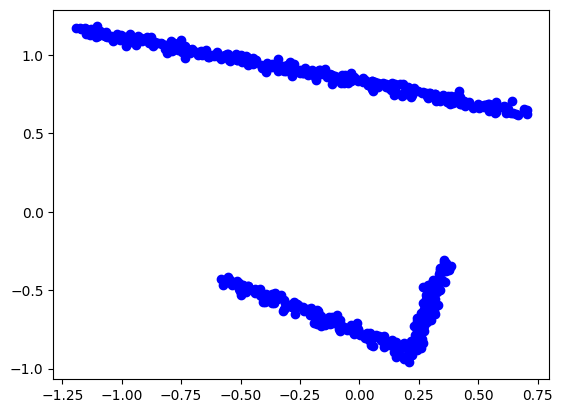

In [22]:
plt.scatter(rotated_points[:, 0], rotated_points[:, 1], color='b', label='Rotated Data')
plt.show()

In [9]:
mnist_labels =  dataset_target_labels.detach().cpu().numpy()
mnist_data = dataset_target_samples.detach().cpu().numpy().reshape(dataset_target_samples.shape[0], 28 * 28)
# Number of classes
num_classes = len(np.unique(mnist_labels))
key = 'representations'
results_dict['representations']

for idx_layer in tqdm(range(len(results_dict[key]))):

    # mnist_target_data = np.array(results_dict[key][idx_layer]).transpose()
    mnist_target_data = results_dict[key][idx_layer].detach().cpu().numpy()

    plot_target_data = np.array(results_dict['pca_2'][idx_layer]).transpose()

    # Create the overall figure
    fig = plt.figure(figsize=(36, 50))
    outer_grid = fig.add_gridspec(num_classes + 1, 2, width_ratios=[1.2, 1.8], height_ratios=[1] + [0.6] * num_classes)


    # Original PCA plot for the entire dataset
    ax_pca = fig.add_subplot(outer_grid[0, 0])
    ax_pca.set_title('2D PCA of Original MNIST Dataset')

    colors = np.array(plot_data_projection(ax_pca, idx_layer, results_dict['pca_2'], labels_all=results_dict['labels']))


    # Process each class for clustering and sample visualization
    for class_idx in range(num_classes):
        # Extract the data points belonging to the current class
        class_data_indices = np.where(mnist_labels == class_idx)[0]
        class_data = mnist_data[class_data_indices]
        mnist_class_data = mnist_target_data[np.where(mnist_labels == class_idx)[0]]

        plot_class_data = plot_target_data[np.where(mnist_labels == class_idx)[0]]

        points = class_data.copy()

        # Apply iterative line fitting clustering to the class data
        # clusters, cluster_indices = iterative_line_fitting(class_data)
        detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)
        if len(detected_hyperplanes) == 0:
            continue
        assignments, _, _ = assign_points_to_hyperplanes(torch.Tensor(points), detected_hyperplanes)

        # Plot the clustering for the current class
        class_cluster_ax = fig.add_subplot(outer_grid[class_idx + 1, 0])
        class_cluster_ax.set_title(f'Clustering of Class {class_idx} (PCA Reduced)')
        for cluster_idx in range(len(detected_hyperplanes)):
            cluster_color = colors[cluster_idx % len(colors)]
            class_cluster_ax.scatter(plot_class_data[assignments == cluster_idx, 0], plot_class_data[assignments == cluster_idx, 1], label=f'Spike {cluster_idx + 1}', color=cluster_color)
        class_cluster_ax.set_xlabel('First Principal Component')
        class_cluster_ax.set_ylabel('Second Principal Component')
        class_cluster_ax.legend(title='Clusters')

        # Create a grid to hold the sample images for each cluster of the current class
        # sample_grid = fig.add_subplot(outer_grid[class_idx + 1, 1])
        cluster_gridspec = gridspec.GridSpecFromSubplotSpec(1, len(detected_hyperplanes), subplot_spec=outer_grid[class_idx + 1, 1], wspace=0.3)

        for cluster_idx in range(len(detected_hyperplanes)):
            cluster = class_data[assignments == cluster_idx]
            # Create a subplot for each cluster to contain its samples
            cluster_ax = fig.add_subplot(cluster_gridspec[0, cluster_idx])
            cluster_ax.axis('off')
            cluster_ax.set_title(f'Cluster {cluster_idx + 1}', fontsize=10)

            # Plot 15 random samples for the current cluster in a 3x5 grid
            num_samples = min(60, len(cluster))
            rows, cols = 6, 10
            grid = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=cluster_gridspec[0, cluster_idx], wspace=0.1, hspace=0.1)

            for sample_idx in range(num_samples):
                random_idx = np.random.choice(np.where(assignments == cluster_idx)[0])
                sample_image = class_data[random_idx].reshape(28, 28)
                
                # Determine position within the 3x5 grid
                row, col = divmod(sample_idx, cols)
                sub_ax = fig.add_subplot(grid[row, col])
                sub_ax.imshow(sample_image, cmap='gray')
                sub_ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add spacing to avoid overlap
    fig.savefig(f"{anal_path}spike_plot{idx_layer}.png")
    plt.close()

100%|██████████| 12/12 [17:00<00:00, 85.07s/it]
